# Analysis Notebook for KV2.1 channels are not required for C-bouton amplification of motor output


### Authors: All analyses in this notebook were performed by Calvin Smith.

Importing all relevant python packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
from scipy.stats import shapiro
#import researchpy as rp
import dabest
from statsmodels.stats.anova import AnovaRM
from statsmodels.formula.api import ols
from scipy.stats import spearmanr

### Estimation Statistics
All estimation statistics were performed using code from the 'dabest' [python package](https://pypi.org/project/dabest/).
A tutorial to create similar visualisations and run estimation stats can be found at on the [github page](https://acclab.github.io/DABEST-python-docs/robust-beautiful.html)

⚠ Note that there seems to be a bug in the stats package causing warning messages, such as the example below, to appear when several tests are run in the same code block. When run separately the results are identical and no error message appears
<div class="alert-danger">  "UserWarning: Sample size too small for normal approximation. warnings.warn("Sample size too small for normal approximation.")" </div> 



## Defining functions needed for making figures and performing stats

Function for removing [spines](https://matplotlib.org/stable/api/spines_api.html) and setting [X](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.set_xticks.html) and [Y](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.set_yticks.html) ticks

In [2]:
def RM_allspines(AX):
    axx.flat[AX].spines['right'].set_visible(False) #remove right spine
    axx.flat[AX].spines['left'].set_visible(False)  #remove left spine
    axx.flat[AX].spines['bottom'].set_visible(False)  #remove bottom spine
    axx.flat[AX].spines['top'].set_visible(False)   #remove top spine
    axx.flat[AX].set_yticks([])   #remove Y ticks
    axx.flat[AX].set_xticks([])   #remove X ricks   

Setting parameters for scatter plot function.
See the [scatterplot page](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) from Seaborn for details on how to plot.

In [3]:
def Scatter_params(Ax, Dat,y,x,hue,pal1,pal2,legLoc,leg1,leg2,YLIM1,YLIM2,XLIM1,XLIM2,style,size,YLAB, face, edge):
    sns.scatterplot(ax=axx.flat[Ax],data=Dat,y=y,x=x,hue=hue,palette=[pal1,pal2],style=style, s=size,fc=face, ec=edge) #set scatterplot properties
    sns.despine(trim=False)  #remove top spine and spine opposite to y
    plt.legend(loc=legLoc, frameon=False,bbox_to_anchor=(leg1,leg2)) #set legend properties
    ax.set_ylim(YLIM1,YLIM2) #set y axes limits
    ax.set_xlim(XLIM1,XLIM2) #set x axes limits
    ax.set(ylabel=(YLAB)) #re-lavel y axes
    

Function for setting the stats [text](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html) to be printed above **unpaired** estimation plots 

In [4]:
def Stats_text(Ax,xpos, ypos, diff,s,loc,c):
    axx.flat[Ax].text(xpos, ypos, diff, size=s, ha=loc, color=c)

Function for setting the stats [text](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html) to be printed above **paired** estimation plots 

In [5]:
def Stats_text_paired(Ax,xpos1,xpos2, ypos, yposES,diffCon,diffDrug, esCon, esDrug,s,loc,c):
    axx.flat[Ax].text(xpos1, ypos, diffCon, size=s, ha=loc, color=c)
    axx.flat[Ax].text(xpos1, yposES, esCon, size=s, ha=loc, color=c)
    axx.flat[Ax].text(xpos2, ypos, diffDrug, size=s, ha=loc, color=c)
    axx.flat[Ax].text(xpos2, yposES, esDrug, size=s, ha=loc, color=c)

Function to set figure charactaristics on point plot. 


In [6]:
def Stats_text_paired_onegroup(Ax,xpos1,ypos,xposES,diffCon,esCon,s,loc,c):
    axx.flat[Ax].text(xpos1, ypos, diffCon, size=s, ha=loc, color=c)
    axx.flat[Ax].text(xposES, ypos, esCon, size=s, ha=loc, color=c)

Function to set figure charactaristics for scatter plot (version 5)

In [7]:
# setting style for scatter plot function.
def Scatter_params5(Ax, Dat,y,x,pal, legLoc,leg1,leg2,YLIM1,YLIM2,XLIM1,XLIM2,size,YLAB, face, edge):
    sns.scatterplot(ax=axx.flat[Ax],data=Dat,y=y,x=x,palette=pal,s=size,fc=face, ec=edge)
    sns.despine(trim=False)
    plt.legend(loc=legLoc, frameon=False,bbox_to_anchor=(leg1,leg2))
    ax.set_ylim(YLIM1,YLIM2)
    ax.set_xlim(XLIM1,XLIM2)
    ax.set(ylabel=(YLAB))


Function to set figure charactaristics for scatter plot (only 1 category)

In [8]:
def Scatter_params_1group(Dat,y,x,YLIM1,YLIM2,XLIM1,XLIM2,XLAB,YLAB,Clr,num,alph,linecol,lw):
    sns.regplot(data=Dat,y=y,x=x, color=Clr,n_boot=False, ci=False,robust=False,x_jitter=0,
                scatter_kws={"s": 30,'alpha':alph,'fc':'none', 'ec':'black','linewidth':0.5},line_kws={'lw': lw, 'color': linecol})
    sns.despine(trim=False)
    plt.legend([],[], frameon=False)
    num.set_ylim(YLIM1,YLIM2)
    num.set_xlim(XLIM1,XLIM2)
    num.set(xlabel=(XLAB))
    num.set(ylabel=(YLAB))

Function for computing Hedges g estimation statistics in non-paired comparison

These can either be __paired__ or __unpaired__

In [9]:
def STAT_hedges(Dat,lab1,lab2,xVal,yVal,param,P,ID,Group_param):
    df = dabest.load(Dat, idx=(lab1, lab2),x=xVal, y=yVal,paired=P,id_col=ID)
    df=df.hedges_g.statistical_tests
    df=df.assign(parameter=param)
    df=df.assign(group=Group_param)
    return df

Function for computing mean difference estimation stats in non-paired comparison

These can either be __paired__ or __unpaired__

In [10]:
# creating function for calculating the mean difference between groups. 
def STAT_mean(Dat,lab1,lab2,xVal,yVal,param,P,ID,Group_param):
    df = dabest.load(Dat, idx=(lab1, lab2),x=xVal, y=yVal,paired=P,id_col=ID)
    df=df.mean_diff.statistical_tests
    df=df.assign(parameter=param)
    df=df.assign(group=Group_param)
    return df


## 🧬🥊 Conditional knockout of K$_V$2.1

[Loading](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html) anatomy data set for testing knockout efficacy 

In [11]:
KO_Anat_dat = pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_paper_Allfiles_for_jupyterNB\Kv2.1_KO_anatomy_2021_forpaper.xlsx",sheet_name='all')

Adding new label column for proper labeling of graphs using pandas [where](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.where.html) logic

In [12]:
KO_Anat_dat['rel_cond']= np.where(KO_Anat_dat['group']=='Con', 'Con', "K$_V$2.1$^{OFF}$")

### 📊 Figure 1. Conditional knockout of KV2.1 in ChAT$^+$ lumbar motoneurons 

C:\Users\Calvi\anaconda3\lib\site-packages\dabest\_classes.py:779: UserWarning: The upper limit of the interval was in the top 10 values. The result should be considered unstable.
  warnings.warn(err_temp.substitute(lim_type="upper",


Text(0, 0.5, '')

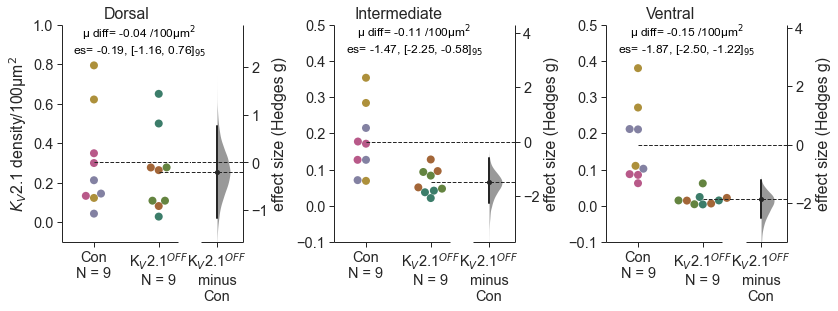

In [13]:
#setting plot styles using seaborn themes
sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.65,rc={"lines.linewidth": 1.6})

#setting figure dimensions
f, axx = plt.subplots(nrows=1, ncols=3, figsize=(13,4),gridspec_kw={'wspace': 0.5, 'hspace':0.5
                                                                  })
# loading and organising data for plotting using DaBest package
dorsal = dabest.load(KO_Anat_dat, idx=("Con","K$_V$2.1$^{OFF}$"),x='rel_cond', y='Dorsal_den',id_col="Cell_ID")  # dorsal
Int = dabest.load(KO_Anat_dat, idx=("Con","K$_V$2.1$^{OFF}$"),x='rel_cond', y='IM_den',id_col="Cell_ID")  # intermediate
Ven = dabest.load(KO_Anat_dat, idx=("Con","K$_V$2.1$^{OFF}$"),x='rel_cond', y='ven_den',id_col="Cell_ID")  # ventral


dorsal.hedges_g.plot(ax=axx.flat[0],swarm_label='$K_{V}$2.1 density/100\u03BCm$^2$', es_marker_size=4,
                  raw_marker_size=8,contrast_label='effect size (Hedges g)', 
                     swarm_ylim=(-0.1,1), contrast_ylim = (-1, 1), color_col="Animal_ID", custom_palette='Dark2',reflines_kwargs=dict(linestyle='--', linewidth=1),
                  swarmplot_kwargs=dict(clip_on=True));
Int.hedges_g.plot(ax=axx.flat[1],swarm_label='$K_{V}$2.1 density/100\u03BCm$^2$', es_marker_size=4,
                 raw_marker_size=8, contrast_label='effect size (Hedges g)', 
                  swarm_ylim=(-0.1,0.5),contrast_ylim=(-1,1),color_col="Animal_ID", custom_palette='Dark2',reflines_kwargs=dict(linestyle='--', linewidth=1),
                  swarmplot_kwargs=dict(clip_on=True));
Ven.hedges_g.plot(ax=axx.flat[2],swarm_label='$K_{V}$2.1 density/100\u03BCm$^2$', es_marker_size=4,
                  raw_marker_size=8, contrast_label='effect size (Hedges g)', 
                  swarm_ylim=(-0.1,0.5),contrast_ylim=(-1,1),color_col="Animal_ID", custom_palette='Dark2',reflines_kwargs=dict(linestyle='--', linewidth=1),
                  swarmplot_kwargs=dict(clip_on=True));



Stats_text(0,0.7, 0.85, '\u03BC diff= -0.04 /100\u03BCm$^2$\nes= -0.19, [-1.16, 0.76]$_{95}$',12,'center','black')  # Inserting text above graph for dorsal stats
Stats_text(1,0.75, 0.42,'\u03BC diff= -0.11 /100\u03BCm$^2$\nes= -1.47, [-2.25, -0.58]$_{95}$',12,'center','black') # Inserting text above graph for intermediate stats
Stats_text(2,0.75, 0.42, '\u03BC diff= -0.15 /100\u03BCm$^2$\nes= -1.87, [-2.50, -1.22]$_{95}$',12,'center','black') # Inserting text above graph for ventral stats



#removing legends
axx.flat[0].contrast_axes.get_legend().remove()
#setting titles
axx.flat[0].set_title('Dorsal')

axx.flat[1].contrast_axes.get_legend().remove()
axx.flat[1].set_title('Intermediate')
axx.flat[1].set_ylabel('')

axx.flat[2].contrast_axes.get_legend().remove()
axx.flat[2].set_title('Ventral')
axx.flat[2].set_ylabel('')

#saving to svg file
#plt.savefig(r"C:\Users\csmith\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\IHC_KO_esPlot.svg", dpi=600,bbox_inches='tight')

### Hedges g estimation statistics

Dorsal Hedges g

In [14]:
# Dorsal
Dorsal_intensity_stats=STAT_hedges(KO_Anat_dat,'Con','cKO','group','Dorsal_den','KV2.2 relative ratio',False,'Animal_ID','Dorsal_den')
Dorsal_intensity_stats


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,parameter,group
0,Con,cKO,9,9,Hedges' g,False,-0.195581,95,-1.163622,0.761684,0.672,0.669101,0.435692,0.668881,0.435692,0.536289,48.0,KV2.2 relative ratio,Dorsal_den


Intermediate Hedges g

In [15]:
# Intermediate
Intermediate_intensity_stats=STAT_hedges(KO_Anat_dat,'Con','cKO','group','IM_den','KV2.2 relative ratio',False,'Animal_ID','IM_den')
Intermediate_intensity_stats

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,parameter,group
0,Con,cKO,9,9,Hedges' g,False,-1.473156,95,-2.251409,-0.585424,0.0026,0.008131,3.281726,0.004697,3.281726,0.008039,71.0,KV2.2 relative ratio,IM_den


Ventral Hedges g

In [16]:
## Intermediateentral
ventral_intensity_stats=STAT_hedges(KO_Anat_dat,'Con','cKO','group','ven_den','KV2.2 relative ratio',False,'Animal_ID','ven_perc_area')
ventral_intensity_stats

C:\Users\Calvi\anaconda3\lib\site-packages\dabest\_classes.py:779: UserWarning: The upper limit of the interval was in the top 10 values. The result should be considered unstable.
  warnings.warn(err_temp.substitute(lim_type="upper",


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,parameter,group
0,Con,cKO,9,9,Hedges' g,False,-1.870909,95,-2.50276,-1.22261,0.0,0.002782,4.167793,0.000726,4.167793,0.000409,81.0,KV2.2 relative ratio,ven_perc_area


### Mean difference estimation statistics

Dorsal mean differences

In [17]:
Dorsal_intensity_stats_MEAN_DIFF=STAT_mean(KO_Anat_dat,'Con','cKO','group','Dorsal_den','KV2.2 relative ratio',False,'Animal_ID','Dorsal_den')
Dorsal_intensity_stats_MEAN_DIFF


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,parameter,group
0,Con,cKO,9,9,mean difference,False,-0.047222,95,-0.271056,0.139833,0.6718,0.669101,0.435692,0.668881,0.435692,0.536289,48.0,KV2.2 relative ratio,Dorsal_den


Intermediate mean differences

In [18]:
Intermediate_intensity_MEAN_DIFF=STAT_mean(KO_Anat_dat,'Con','cKO','group','IM_den','KV2.2 relative ratio',False,'Animal_ID','IM_den')
Intermediate_intensity_MEAN_DIFF

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,parameter,group
0,Con,cKO,9,9,mean difference,False,-0.110556,95,-0.184167,-0.056278,0.0026,0.008131,3.281726,0.004697,3.281726,0.008039,71.0,KV2.2 relative ratio,IM_den


Ventral mean differences

In [19]:
Ventral_intensity_MEAN_DIFF=STAT_mean(KO_Anat_dat,'Con','cKO','group','ven_den','KV2.2 relative ratio',False,'Animal_ID','IM_den')
Ventral_intensity_MEAN_DIFF

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,parameter,group
0,Con,cKO,9,9,mean difference,False,-0.150539,95,-0.228767,-0.094894,0.0,0.002782,4.167793,0.000726,4.167793,0.000409,81.0,KV2.2 relative ratio,IM_den


## Firing characteristics are similar in control and K$_V$2.1$^{OFF}$ motoneurons

[Loading](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html) patch clamp data data for analysis

In [20]:
# Loading the data for gxtx patching
gxtx_dat = pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_paper_Allfiles_for_jupyterNB\KV2_patching_Data_2021_06.xlsx",sheet_name='Final')

Converting Tau units to ms from seconds

In [21]:
gxtx_dat["Tau_s"] = 1000 * gxtx_dat["Tau_s"] # converting tau to ms

Creating new data frame from original contains differences between ACSF and pharmacological treatment during patching. 
The pandas function used are:
[groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html), [join](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html), [diff](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html),

In [22]:
ALL_with_difs = gxtx_dat.join(gxtx_dat.groupby(['Animal','Cell_ID', 'genotype','gender'])[['Max_FF', 'slope_max', 'Mean_FF', 'slope_mean',
       'SS_FF', 'slope_SSFF', 'Max_Spikes', 'AP_AMP', 'AP_HW', 'fAHP_AMP', 'Mean_AP_3x_thresh',
       'AP1_HW_3x_thresh', 'APlast_HW_3x_thresh', 'Mean_trough_3x_thresh',
       'AP1_trough_3x_thresh', 'APlast_trough_3x_thresh', 'Apamp_mean',
       'Amp_first', 'Amp_last', 'mAHP_AMP', 'mAHP_half_Duration','Rheo_nA', 'Res_Mohm', 'Tau_s', 'Cap_pF', 'block_thresh_nA']].diff(), rsuffix='_diff')


Creating new data frame from original that contains *percentage* differences between ACSF and pharmacological treatment during patching. 

In [23]:
ALL_with_Perc_change = gxtx_dat.join(gxtx_dat.groupby(['Animal', 'Cell_ID', 'genotype', 'gender'])[['Max_FF', 'slope_max', 'Mean_FF', 'slope_mean',
       'SS_FF', 'slope_SSFF', 'Max_Spikes', 'AP_AMP', 'AP_HW', 'fAHP_AMP', 'Mean_AP_3x_thresh',
       'AP1_HW_3x_thresh', 'APlast_HW_3x_thresh', 'Mean_trough_3x_thresh',
       'AP1_trough_3x_thresh', 'APlast_trough_3x_thresh', 'Apamp_mean',
       'Amp_first', 'Amp_last', 'mAHP_AMP', 'mAHP_half_Duration','Rheo_nA', 'Res_Mohm', 'Tau_s', 'Cap_pF', 'block_thresh_nA','RMP']].pct_change()*100, rsuffix='_diff')


Creating new DF from original with only __mature (>P13)__, __control motneurons__ treated with __GXTX__

This was done by [dropping](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) cells meeting any the following criteria: ChAT-K$_V$2.1$^{OFF}$ motoneurons, age <P13, compounds used not GXTX,cell is cortical pyramidal, motoneurons with input resistances greater than 49 MOhms from the dataframe

⁉️ Note that motoneurons with input resistances greater than 49 MOhms were dropped due to a sampling bias between groups ⁉️


In [24]:
# creating new DF from master with only Mature, control motneurons treated with GXTX
Gxtx_WT_Mature=ALL_with_Perc_change.drop(ALL_with_Perc_change[(ALL_with_Perc_change['genotype'] == "cKO")].index)
Gxtx_WT_Mature=Gxtx_WT_Mature.drop(Gxtx_WT_Mature[(Gxtx_WT_Mature['agegroup'] != "P13plus")].index)
Gxtx_WT_Mature=Gxtx_WT_Mature.drop(Gxtx_WT_Mature[(Gxtx_WT_Mature['Compound'] != "gxtx-1E")].index)
Gxtx_WT_Mature=Gxtx_WT_Mature.drop(Gxtx_WT_Mature[(Gxtx_WT_Mature['celltype'] == "Cortical_L5_Pyramidal")].index)
#dropping cells with Res greater than 70MOHms (to avoid potential gammas, and because there is a bias)
Gxtx_WT_Mature=Gxtx_WT_Mature.drop(Gxtx_WT_Mature[(Gxtx_WT_Mature['Res_Mohm'] > 49)].index)


Creating new DF from original with only __mature (>P13)__, __ChAT-K$_V$2.1$^{OFF}$ motneurons__ treated with __GXTX__


In [25]:
# creating DF with only Mature,KO  motneurons treated with GXTX
Gxtx_KO_Mature=ALL_with_Perc_change.drop(ALL_with_Perc_change[(ALL_with_Perc_change['genotype'] == "Con")].index)
Gxtx_KO_Mature=Gxtx_KO_Mature.drop(Gxtx_KO_Mature[(Gxtx_KO_Mature['agegroup'] != "P13plus")].index)
Gxtx_KO_Mature=Gxtx_KO_Mature.drop(Gxtx_KO_Mature[(Gxtx_KO_Mature['Compound'] != "gxtx-1E")].index)
Gxtx_KO_Mature=Gxtx_KO_Mature.drop(Gxtx_KO_Mature[(Gxtx_KO_Mature['celltype'] == "Cortical_L5_Pyramidal")].index)
#dropping cells with Res greater than 70MOHms (to avoid potential gammas, and because there is a bias)
Gxtx_KO_Mature=Gxtx_KO_Mature.drop(Gxtx_KO_Mature[(Gxtx_KO_Mature['Res_Mohm'] > 49)].index)

Combining __Control__ and __ChAT-K$_V$2.1$^{OFF}$__, __mature (>P13)__, __GXTX only__ treated cells

In [26]:
#creating combined DF with KO and WT data
to_concat=[Gxtx_WT_Mature,Gxtx_KO_Mature]
ALL_Mature_MN_KO=pd.concat(to_concat)

#### Including only mature motoneurons for comparing Con and cKO charactaristics (w/o compounds). 


In [27]:
#including only mature motoneurons for comparing Con and cKO charactaristics (w/o compounds). 
Gxtx_ALL_Mature=ALL_with_Perc_change.drop(ALL_with_Perc_change[(ALL_with_Perc_change['agegroup'] != "P13plus")].index)
Gxtx_ALL_Mature=Gxtx_ALL_Mature.drop(Gxtx_ALL_Mature[(Gxtx_ALL_Mature['celltype'] == "Cortical_L5_Pyramidal")].index)

#excluding NA values.

#excluding compound values
Gxtx_ALL_Mature=Gxtx_ALL_Mature.drop(Gxtx_ALL_Mature[(Gxtx_ALL_Mature['condition_normalised'] != 'nACSF')].index)

#### Excluding cells with Resistance greater than 50 to avoid bias in cell type between groups.


In [28]:
#Excluding cells with Resistance greater than 50 to avoid bias in cell type between groups.
Gxtx_ALL_Mature=Gxtx_ALL_Mature.drop(Gxtx_ALL_Mature[(Gxtx_ALL_Mature['Res_Mohm'] >49)].index)

#### Setting aesthetic parameters for plots


In [29]:
## Setting aesthetis parameters for plots
sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.5 ,rc={"lines.linewidth": 1.6})
meanpointprops = dict(marker='-', markeredgecolor='r',
                      markerfacecolor='none',markeredgewidth=2,markersize=8)
medianprops = dict(linestyle='-.', linewidth=0, color='firebrick')
meanlineprops = dict(linestyle='-', linewidth=1.5, color='black')



#### Adding new label column for proper labeling of graphs

In [30]:
#adding new label column for proper labeling of graphs
Gxtx_ALL_Mature['rel_cond']= np.where(Gxtx_ALL_Mature['genotype']=='Con', 'Con', "K$_V$2.1$^{OFF}$")

## 📊 Figure 2- Supplemental 1. KV2.1 cKO does not alter motoneuron passive membrane properties

Text(-4, 4, 'E')

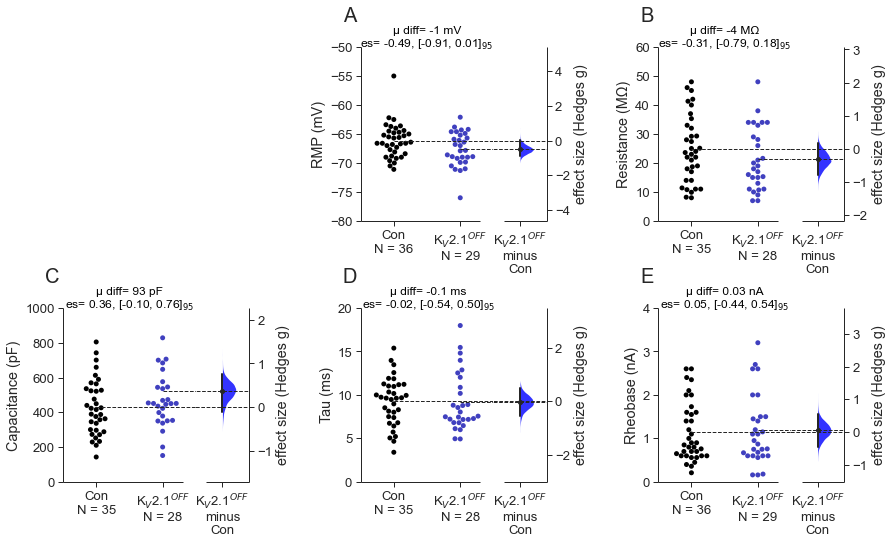

In [31]:
 my_color_palette = {"Con" : "black",
                      "K$_V$2.1$^{OFF}$" : "blue"}
    
f, axx = plt.subplots(nrows=2, ncols=3, figsize=(14,8),gridspec_kw={'wspace': 0.6, 'hspace':0.5})


Res = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="Res_Mohm",id_col="Cell_ID")
Cap = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="Cap_pF",id_col="Cell_ID")
tau = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="Tau_s",id_col="Cell_ID")
Rheo = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="Rheo_nA",id_col="Cell_ID")
RMP = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="RMP",id_col="Cell_ID")

RM_allspines(0) #removing the last plot for example traces



RMP.hedges_g.plot(ax=axx.flat[1],swarm_label='RMP (mV)', es_marker_size=4,
                 raw_marker_size=5, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                  swarm_ylim=(-80,-50), contrast_ylim=(-1,1),reflines_kwargs=dict(linestyle='--', linewidth=1),
                  swarmplot_kwargs=dict(clip_on=True));

Res.hedges_g.plot(ax=axx.flat[2],swarm_label='Resistance (M\u03A9)', es_marker_size=4,
                  raw_marker_size=5,custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                  swarm_ylim=(0,60), contrast_ylim = (-1, 1),reflines_kwargs=dict(linestyle='--', linewidth=1),
                  swarmplot_kwargs=dict(clip_on=True));

Cap.hedges_g.plot(ax=axx.flat[3],swarm_label='Capacitance (pF)', es_marker_size=4,
                 raw_marker_size=5, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                  swarm_ylim=(0,1000),contrast_ylim=(-1,1),reflines_kwargs=dict(linestyle='--', linewidth=1),
                  swarmplot_kwargs=dict(clip_on=True));

tau.hedges_g.plot(ax=axx.flat[4],swarm_label='Tau (ms)', es_marker_size=4,
                 raw_marker_size=5, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                  swarm_ylim=(0,20), contrast_ylim=(-1,1),reflines_kwargs=dict(linestyle='--', linewidth=1),
                  swarmplot_kwargs=dict(clip_on=True));

Rheo.hedges_g.plot(ax=axx.flat[5],swarm_label='Rheobase (nA)', es_marker_size=4,
                  raw_marker_size=5, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                   swarm_ylim=(0,4),contrast_ylim=(-1,1),reflines_kwargs=dict(linestyle='--', linewidth=1),
                  swarmplot_kwargs=dict(clip_on=True));


Stats_text(1,0.5, -50, '\u03BC diff= -1 mV\nes= -0.49, [-0.91, 0.01]$_{95}$',12,'center','black')
Stats_text(2,0.5, 60, '\u03BC diff= -4 M\u03A9\nes= -0.31, [-0.79, 0.18]$_{95}$',12,'center','black')
Stats_text(3,0.5, 1000,'\u03BC diff= 93 pF\nes= 0.36, [-0.10, 0.76]$_{95}$',12,'center','black')
Stats_text(4,0.52, 20, '\u03BC diff= -0.1 ms\nes= -0.02, [-0.54, 0.50]$_{95}$',12,'center','black')
Stats_text(5,0.5, 4, '\u03BC diff= 0.03 nA\nes= 0.05, [-0.44, 0.54]$_{95}$',12,'center','black')

axx.flat[1].annotate('A', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[2].annotate('B', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[3].annotate('C', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[4].annotate('D', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[5].annotate('E', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
#axx.flat[6].annotate('F', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')




#plt.savefig(r"C:\Users\csmith\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\Con_KO_membrane_esPlot.svg", dpi=300,bbox_inches='tight')

Number of Males and females for mature GXTX experiments in WT (gender, animal, cell count)

In [32]:
AP_menas=Gxtx_WT_Mature.groupby(['gender', 'Animal'],as_index=False).agg(['count'])
AP_menas.slope_mean

count
gender Animal       
F      AAS         4
       ABR         4
       ABS         6
       ABU         2
       ABX         2
       AEP         4
M      AAT         2
       ABI         2
       ABL         4
       ABM         4
       ABP         2
       AEQ         2
       DQ          2

Number of Males and females for mature GXTX experiments in KO (gender, Animal, cell count)

In [33]:
AP_menas=Gxtx_WT_Mature.groupby(['gender', 'Animal'],as_index=False).agg(['count'])
AP_menas.block_thresh_nA

count
gender Animal       
F      AAS         2
       ABR         4
       ABS         4
       ABU         0
       ABX         2
       AEP         4
M      AAT         2
       ABI         0
       ABL         4
       ABM         2
       ABP         0
       AEQ         2
       DQ          0

### Hedges g estimation statistics for figure 2. supplement 1


In [34]:
####Resistance stats
Res_Mohm_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con","cKO","genotype","Res_Mohm",'Resistance',False,"Cell_ID","MN_Both")

####Capacitance stats
Cap_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con","cKO","genotype","Cap_pF",'Capacitance',False,"Cell_ID","MN_Both")

####Tau stats
Tau_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con","cKO","genotype","Tau_s",'Tau',False,"Cell_ID","MN_Both")

####Tau stats
Rheo_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con","cKO","genotype","Rheo_nA",'Rheobase',False,"Cell_ID","MN_Both")

####Tau stats
RMP_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con","cKO","genotype","RMP",'RMP',False,"Cell_ID","MN_Both")


Combining all estimation stats for figure 2. supplement 1 into single DF


In [35]:
to_concat=[Res_Mohm_Stats_no_compound,Cap_Stats_no_compound,Tau_Stats_no_compound,Rheo_Stats_no_compound,RMP_Stats_no_compound]
ALL_passive_Stats=pd.concat(to_concat)

In [36]:
ALL_passive_Stats             


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,parameter,group
0,Con,cKO,35,28,Hedges' g,False,-0.316990,95,-0.797741,0.186820,0.2082,0.206773,1.276381,0.210375,1.265863,0.210477,581.0,Resistance,MN_Both
0,Con,cKO,35,28,Hedges' g,False,0.369783,95,-0.103172,0.763291,0.1364,0.176388,-1.378053,0.144904,-1.476686,0.177456,392.0,Capacitance,MN_Both
0,Con,cKO,35,28,Hedges' g,False,-0.025012,95,-0.542904,0.500131,0.9138,0.922623,0.097606,0.920765,0.099883,0.511166,538.0,Tau,MN_Both
0,Con,cKO,36,29,Hedges' g,False,0.050403,95,-0.447438,0.541387,0.8390,0.841447,-0.200986,0.838666,-0.204443,0.942058,516.0,Rheobase,MN_Both
0,Con,cKO,36,29,Hedges' g,False,-0.492384,95,-0.915402,0.008577,0.0482,0.050338,1.997203,0.050126,1.997209,0.096270,648.5,RMP,MN_Both


### Mean difference estimation statistics for figure 2. supplement 1

In [37]:
####Resistance stats
Res_Mohm_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con","cKO","genotype","Res_Mohm",'Resistance',False,"Cell_ID","MN_Both")

####Capacitance stats
Cap_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con","cKO","genotype","Cap_pF",'Capacitance',False,"Cell_ID","MN_Both")

####Tau stats
Tau_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con","cKO","genotype","Tau_s",'Tau',False,"Cell_ID","MN_Both")

####Tau stats
Rheo_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con","cKO","genotype","Rheo_nA",'Rheobase',False,"Cell_ID","MN_Both")

####Tau stats
RMP_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con","cKO","genotype","RMP",'RMP',False,"Cell_ID","MN_Both")


Combining all mean difference stats for figure 2. supplement 1 into single DF


In [38]:
to_concat=[Res_Mohm_Stats_no_compound_MEAN_DIFF,Cap_Stats_no_compound_MEAN_DIFF,Tau_Stats_no_compound_MEAN_DIFF,Rheo_Stats_no_compound_MEAN_DIFF,RMP_Stats_no_compound_MEAN_DIFF]
ALL_passive_Stats_MeanDiff=pd.concat(to_concat)

In [39]:
ALL_passive_Stats_MeanDiff

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,parameter,group
0,Con,cKO,35,28,mean difference,False,-3.623571,95,-8.937143,1.900714,0.2082,0.206773,1.276381,0.210375,1.265863,0.210477,581.0,Resistance,MN_Both
0,Con,cKO,35,28,mean difference,False,92.916721,95,2.767061,303.139881,0.1364,0.176388,-1.378053,0.144904,-1.476686,0.177456,392.0,Capacitance,MN_Both
0,Con,cKO,35,28,mean difference,False,-0.077053,95,-1.449072,1.602506,0.9138,0.922623,0.097606,0.920765,0.099883,0.511166,538.0,Tau,MN_Both
0,Con,cKO,36,29,mean difference,False,0.037841,95,-0.318446,0.412347,0.8390,0.841447,-0.200986,0.838666,-0.204443,0.942058,516.0,Rheobase,MN_Both
0,Con,cKO,36,29,mean difference,False,-1.480584,95,-3.015345,-0.115766,0.0482,0.050338,1.997203,0.050126,1.997209,0.096270,648.5,RMP,MN_Both


## 📊 Figure 2. Comparing firing capabilities of  K$_V$2.1$^{OFF}$ and control motoneurons

Note that empty axes in A, B are space holders for example traces

Text(0.5, 1.0, 'K$_V$2.1$^{OFF}$')

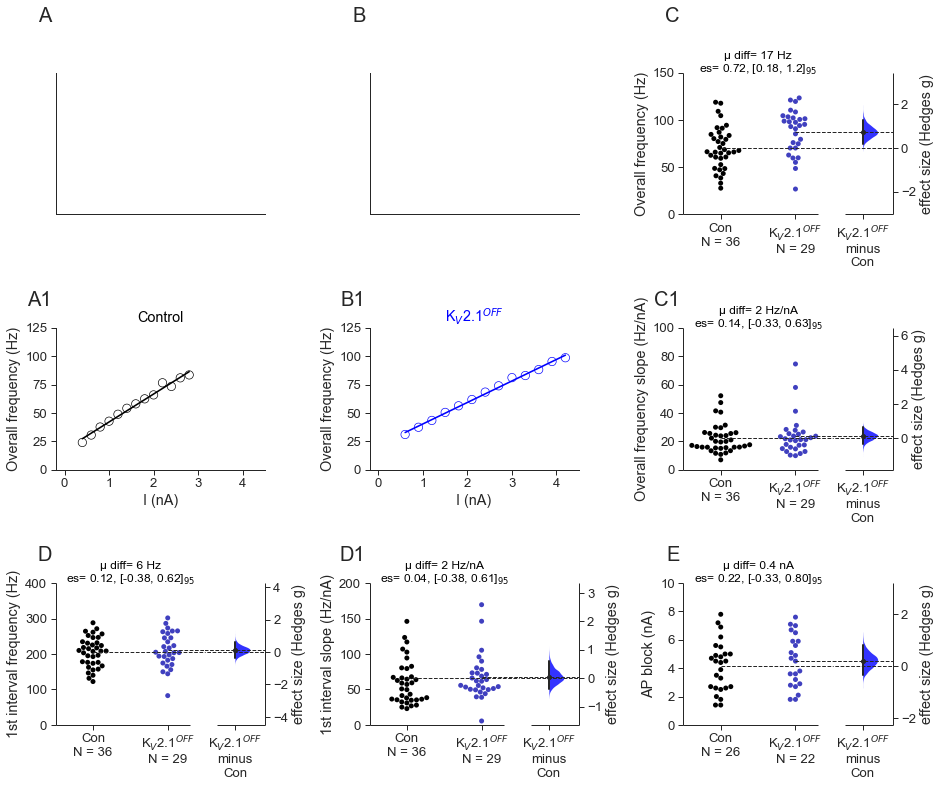

In [40]:
 my_color_palette = {"Con" : "black",
                      "K$_V$2.1$^{OFF}$" : "blue"}

f, axx = plt.subplots(nrows=3, ncols=3, figsize=(15,12), gridspec_kw={'wspace': 0.5, 'hspace':0.8})
                                                                  

Mean_freq = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="Mean_FF",id_col="Cell_ID")
Mean_freq_slop = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="slope_mean",id_col="Cell_ID")
Max_Spikes = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="Max_Spikes",id_col="Cell_ID")
first_In = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="Max_FF",id_col="Cell_ID")
first_slope = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="slope_max",id_col="Cell_ID")
AP_block = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="block_thresh_nA",id_col="Cell_ID")



Mean_freq.hedges_g.plot(ax=axx.flat[2],swarm_ylim=(0,150),contrast_ylim=(-1,1),swarm_label='Overall frequency (Hz)', es_marker_size=4,
                        raw_marker_size=5, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
Mean_freq_slop.hedges_g.plot(ax=axx.flat[5],swarm_ylim=(0,100),swarm_label='Overall frequency slope (Hz/nA)', es_marker_size=4, contrast_ylim=(-1,1),
                             raw_marker_size=5, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));

first_In.hedges_g.plot(ax=axx.flat[6],swarm_ylim=(0,400),swarm_label='1st interval frequency (Hz)', es_marker_size=4, contrast_ylim=(-1,1),
                       raw_marker_size=5, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
first_slope.hedges_g.plot(ax=axx.flat[7],swarm_ylim=(0,200),swarm_label='1st interval slope (Hz/nA)', es_marker_size=4, contrast_ylim=(-1,1),
                          raw_marker_size=5, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
AP_block.hedges_g.plot(ax=axx.flat[8],swarm_ylim=(0,10),swarm_label='AP block (nA)', es_marker_size=4, contrast_ylim=(-1,1),
                       raw_marker_size=5, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));



Stats_text(2,0.5, 150, '\u03BC diff= 17 Hz\nes= 0.72, [0.18, 1.2]$_{95}$',12,'center','black') #mean
Stats_text(5,0.5, 100,'\u03BC diff= 2 Hz/nA\nes= 0.14, [-0.33, 0.63]$_{95}$',12,'center','black')  #mean slope
#Stats_text(5,0.5, 80, '\u03BC diff= 6.16 spikes\nes= 0.51, [0.001, 1.05]$_{95}$',12,'center','black')  #spikes
Stats_text(6,0.5, 400, '\u03BC diff= 6 Hz\nes= 0.12, [-0.38, 0.62]$_{95}$',12,'center','black')     #initial
Stats_text(7,0.5, 200, '\u03BC diff= 2 Hz/nA\nes= 0.04, [-0.38, 0.61]$_{95}$',12,'center','black')  #initial slope
Stats_text(8,0.5, 10, '\u03BC diff= 0.4 nA\nes= 0.22, [-0.33, 0.80]$_{95}$',12,'center','black')      #ap block

axx.flat[0].annotate('A', xy=(0,1.3), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[1].annotate('B', xy=(0,1.3), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[2].annotate('C', xy=(0,1.3), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')

axx.flat[3].annotate('A1', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[4].annotate('B1', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[5].annotate('C1', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')

axx.flat[6].annotate('D', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[7].annotate('D1', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[8].annotate('E', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')

RM_allspines(0) #making first plot blank
RM_allspines(1) #making first plot blank

Example_FI_plots = pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_paper_Allfiles_for_jupyterNB\Example_F_I_plots_paper.xlsx",
                         sheet_name='merge')
Example_FI_plots_ABS=Example_FI_plots.drop(Example_FI_plots[(Example_FI_plots['genotype'] == "cKO")].index)
Example_FI_plots_ACG=Example_FI_plots.drop(Example_FI_plots[(Example_FI_plots['genotype'] == "Con")].index)


##setting bestfit line for ABS
Example_FI_plots_ABS.dropna()
x=Example_FI_plots_ABS['I (nA)']
y=Example_FI_plots_ABS['Mean frequency (Hz)']
m, b = np.polyfit(x, y, 1)

##setting bestfit line for ACG
x1=Example_FI_plots_ACG['I (nA)']
y1=Example_FI_plots_ACG['Mean frequency (Hz)']
m1, b1 = np.polyfit(x1, y1, 1)

ax = axx.flat[3]
ax= Scatter_params5(3,Example_FI_plots_ABS,"Mean frequency (Hz)","I (nA)","black","upper left",0, 1
               ,0,125,-0.2,4.5,70,"Overall frequency (Hz)", 'none', 'black')
axx.flat[3].plot(x, m*x + b,color='black')
axx.flat[3].set_title("Control",color='black')

ax = axx.flat[4]
ax= Scatter_params5(4,Example_FI_plots_ACG,"Mean frequency (Hz)","I (nA)","blue","upper left",0, 1
               ,0,125,-0.2,4.5,70,"Overall frequency (Hz)", 'none', 'blue')
axx.flat[4].plot(x1, m1*x1 + b1,color='blue')
axx.flat[4].set_title("K$_V$2.1$^{OFF}$",color='blue')


#plt.savefig(r"C:\Users\csmith\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\Firing_con_vsKOesPlot.svg", dpi=400,bbox_inches='tight')

### Hedges g estimation statistics for figure 2.


In [41]:
####Max stats
Max_FF_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con", "cKO","genotype","Max_FF",'Peak init freq',False,"Cell_ID","Con MN (mature)")
####slope stats
slope_max_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con", "cKO","genotype","slope_max",'initial FI',False,"Cell_ID","Con MN (mature)")
####block_thresh stats
block_thresh_nA_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con", "cKO","genotype","block_thresh_nA",'block thresh nA',False,"Cell_ID","Con MN (mature)")
####Mean_FF
Mean_FF_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con", "cKO","genotype","Mean_FF",'Peak mean freq',False,"Cell_ID","Con MN (mature)")
####slope_mean
slope_mean_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con", "cKO","genotype","slope_mean",'mean freq FI',False,"Cell_ID","Con MN (mature)")
####Max_Spikes
Max_Spikes_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con", "cKO","genotype","Max_Spikes",'Max spikes',False,"Cell_ID","Con MN (mature)")

Combining all firing and AP charactaristics into single DF

In [42]:
to_concat=[Max_FF_Stats_no_compound,slope_max_Stats_no_compound,block_thresh_nA_Stats_no_compound,
           Mean_FF_Stats_no_compound,slope_mean_Stats_no_compound,Max_Spikes_Stats_no_compound]
ALL_firing_Stats_hedges=pd.concat(to_concat)
ALL_firing_Stats_hedges

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,parameter,group
0,Con,cKO,36,29,Hedges' g,False,0.120840,95,-0.386344,0.629033,0.6184,0.631680,-0.482034,0.625729,-0.490152,0.677630,490.0,Peak init freq,Con MN (mature)
0,Con,cKO,36,29,Hedges' g,False,0.040118,95,-0.389925,0.619501,0.8796,0.866519,-0.168780,0.871254,-0.162728,0.259182,436.0,initial FI,Con MN (mature)
0,Con,cKO,26,22,Hedges' g,False,0.221287,95,-0.335867,0.806245,0.4352,0.442378,-0.775129,0.441348,-0.776638,0.384563,243.5,block thresh nA,Con MN (mature)
0,Con,cKO,36,29,Hedges' g,False,0.724434,95,0.182964,1.286633,0.0056,0.004848,-2.927193,0.004605,-2.938449,0.004456,306.0,Peak mean freq,Con MN (mature)
0,Con,cKO,36,29,Hedges' g,False,0.145428,95,-0.335364,0.634842,0.5558,0.570112,-0.571624,0.557376,-0.589887,0.756466,498.0,mean freq FI,Con MN (mature)
0,Con,cKO,36,29,Hedges' g,False,0.515754,95,0.001182,1.050555,0.0422,0.040675,-2.091973,0.040474,-2.092000,0.038091,364.5,Max spikes,Con MN (mature)


### Mean difference estimation statistics for figure 2. 

In [43]:
####Max stats
Max_FF_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con", "cKO","genotype","Max_FF",'Peak init freq',False,"Cell_ID","Con MN (mature)")
####slope stats
slope_max_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con", "cKO","genotype","slope_max",'initial FI',False,"Cell_ID","Con MN (mature)")
####block_thresh stats
block_thresh_nA_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con", "cKO","genotype","block_thresh_nA",'block thresh nA',False,"Cell_ID","Con MN (mature)")
####Mean_FF
Mean_FF_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con", "cKO","genotype","Mean_FF",'Peak mean freq',False,"Cell_ID","Con MN (mature)")
####slope_mean
slope_mean_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con", "cKO","genotype","slope_mean",'mean freq FI',False,"Cell_ID","Con MN (mature)")
####Max_Spikes
Max_Spikes_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con", "cKO","genotype","Max_Spikes",'Max spikes',False,"Cell_ID","Con MN (mature)")

Combining all firing and AP charactaristics into single DF

In [44]:
to_concat=[Max_FF_Stats_no_compound_MEAN_DIFF,slope_max_Stats_no_compound_MEAN_DIFF,block_thresh_nA_Stats_no_compound_MEAN_DIFF,
           Mean_FF_Stats_no_compound_MEAN_DIFF,slope_mean_Stats_no_compound_MEAN_DIFF,Max_Spikes_Stats_no_compound_MEAN_DIFF]
ALL_firing_Stats_MEAN_DIFF=pd.concat(to_concat)

## 📊 Figure 3. Comparing action potential characteristic of control and K$_V$2.1$^{OFF}$ motoneurons

Note that A is a place holder for represetative trace insert

C:\Users\Calvi\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(-4, 4, 'I')

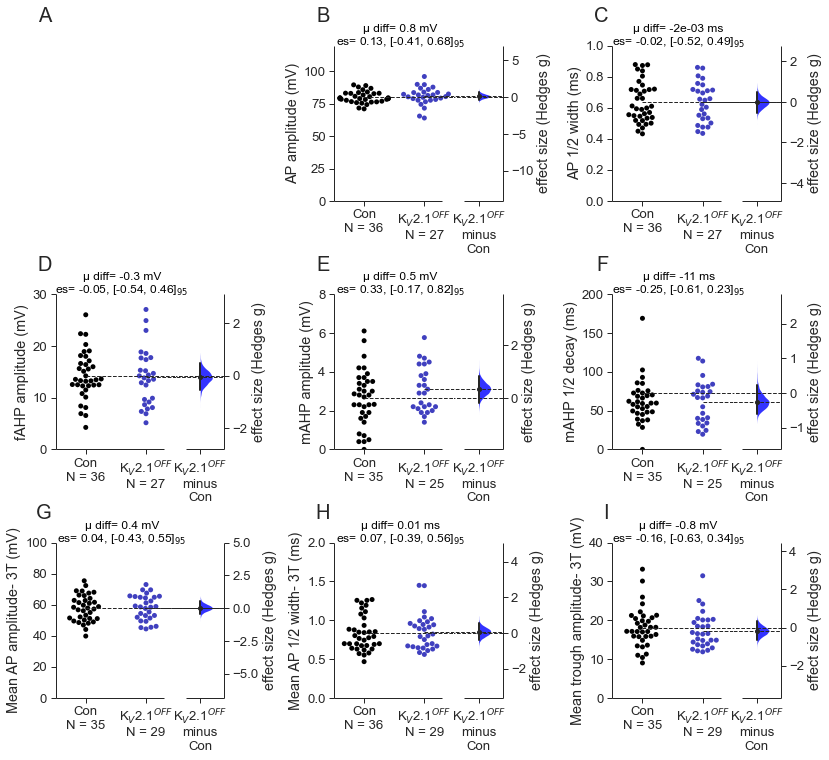

In [45]:
 my_color_palette = {"Con" : "black",
                      "K$_V$2.1$^{OFF}$" : "blue"}

f, axx = plt.subplots(nrows=3, ncols=3, figsize=(13,12), gridspec_kw={'wspace': 0.65, 'hspace':0.6})

AP_HW = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="AP_HW",id_col="Cell_ID")
fAHP = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="fAHP_AMP",id_col="Cell_ID")
AP_Amp = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="AP_AMP",id_col="Cell_ID")
mAHP = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="mAHP_AMP",id_col="Cell_ID")
mAHP_Dur = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="mAHP_half_Duration",id_col="Cell_ID")
MeanAP_HW = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="Mean_AP_3x_thresh",id_col="Cell_ID")
Mean_AHP = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="Mean_trough_3x_thresh",id_col="Cell_ID")
MeanAPamp = dabest.load(Gxtx_ALL_Mature, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="Apamp_mean",id_col="Cell_ID")


RM_allspines(0) #removing the last plot for example traces

AP_Amp.hedges_g.plot(ax=axx.flat[1],swarm_ylim=(0,120),swarm_label='AP amplitude (mV)', es_marker_size=4, contrast_ylim=(-1,1),
                     raw_marker_size=5, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
AP_HW.hedges_g.plot(ax=axx.flat[2], swarm_ylim=(0,1),swarm_label='AP 1/2 width (ms)', es_marker_size=4,
                    raw_marker_size=5,custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
fAHP.hedges_g.plot(ax=axx.flat[3],swarm_ylim=(0,30),contrast_ylim=(-1,1),swarm_label='fAHP amplitude (mV)', es_marker_size=4,
                   raw_marker_size=5, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));

mAHP.hedges_g.plot(ax=axx.flat[4],swarm_ylim=(0,8),swarm_label='mAHP amplitude (mV)', es_marker_size=4, contrast_ylim=(-1,1),
                   raw_marker_size=5, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
mAHP_Dur.hedges_g.plot(ax=axx.flat[5],swarm_ylim=(0,200),swarm_label='mAHP 1/2 decay (ms)', es_marker_size=4, contrast_ylim=(-1,1),
                       raw_marker_size=5, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
MeanAPamp.hedges_g.plot(ax=axx.flat[6],swarm_ylim=(0,100),swarm_label='Mean AP amplitude- 3T (mV)', es_marker_size=4, contrast_ylim=(-1,1),
                        raw_marker_size=5, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
MeanAP_HW.hedges_g.plot(ax=axx.flat[7],swarm_ylim=(0,2),swarm_label='Mean AP 1/2 width- 3T (ms)', es_marker_size=4, contrast_ylim=(-1,1),
                        raw_marker_size=5, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
Mean_AHP.hedges_g.plot(ax=axx.flat[8],swarm_ylim=(0,40),swarm_label='Mean trough amplitude- 3T (mV)', es_marker_size=4, contrast_ylim=(-1,1),
                       raw_marker_size=5, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));

Stats_text(1,0.6, 120, '\u03BC diff= 0.8 mV\nes= 0.13, [-0.41, 0.68]$_{95}$',12,'center','black')  
Stats_text(2,0.6, 1, '\u03BC diff= -2e-03 ms\nes= -0.02, [-0.52, 0.49]$_{95}$',12,'center','black') 
Stats_text(3,0.6, 30,'\u03BC diff= -0.3 mV\nes= -0.05, [-0.54, 0.46]$_{95}$',12,'center','black')  
Stats_text(4,0.6, 8, '\u03BC diff= 0.5 mV\nes= 0.33, [-0.17, 0.82]$_{95}$',12,'center','black')    
Stats_text(5,0.6, 200, '\u03BC diff= -11 ms\nes= -0.25, [-0.61, 0.23]$_{95}$',12,'center','black')  
Stats_text(6,0.6, 100, '\u03BC diff= 0.4 mV\nes= 0.04, [-0.43, 0.55]$_{95}$',12,'center','black') 
Stats_text(7,0.6, 2, '\u03BC diff= 0.01 ms\nes= 0.07, [-0.39, 0.56]$_{95}$',12,'center','black')  
Stats_text(8,0.6, 40, '\u03BC diff= -0.8 mV\nes= -0.16, [-0.63, 0.34]$_{95}$',12,'center','black') 

axx.flat[0].annotate('A', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[1].annotate('B', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[2].annotate('C', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[3].annotate('D', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[4].annotate('E', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[5].annotate('F', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[6].annotate('G', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[7].annotate('H', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[8].annotate('I', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')

#plt.savefig(r"C:\Users\csmith\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\APS_con_vsKOesPlot.svg", dpi=600,bbox_inches='tight')

### Hedges g Estimation statistics for figure 3.


In [46]:
####AP_HW
AP_HW_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con", "cKO","genotype","AP_HW",'AP HW',False,"Cell_ID","Con MN (mature)")
####AP_AMP
AP_AMP_AMP_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con", "cKO","genotype","AP_AMP",'AP amp',False,"Cell_ID","Con MN (mature)")
####Mean_AP_3x_thresh
Mean_AP_3x_thresh_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con", "cKO","genotype","Mean_AP_3x_thresh",'Mean AP HW 3T',False,"Cell_ID","Con MN (mature)")
####Mean_trough_3x_thresh
Mean_trough_3x_thresh_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con", "cKO","genotype","Mean_trough_3x_thresh",'Mean trough amp 3T',False,"Cell_ID","Con MN (mature)")
####Apamp_mean
Apamp_mean_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con", "cKO","genotype","Apamp_mean",'mean AP amp 3T',False,"Cell_ID","Con MN (mature)")
####mAHP_AMP
mAHP_AMP_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con", "cKO","genotype","mAHP_AMP",'mAHP amp',False,"Cell_ID","Con MN (mature)")
####mAHP_AMP
mAHP_half_Duration_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con", "cKO","genotype","mAHP_half_Duration",'mAHP half duration',False,"Cell_ID","Con MN (mature)")
###fAHP
fAHP_half_Duration_Stats_no_compound=STAT_hedges(Gxtx_ALL_Mature,"Con", "cKO","genotype","fAHP_AMP",'fAHP amp',False,"Cell_ID","Con MN (mature)")

Combining all firing and AP charactaristics into single DF


In [47]:
to_concat=[AP_HW_Stats_no_compound,AP_AMP_AMP_Stats_no_compound,Mean_AP_3x_thresh_Stats_no_compound,
           Mean_trough_3x_thresh_Stats_no_compound,Apamp_mean_Stats_no_compound,mAHP_AMP_Stats_no_compound,
           mAHP_half_Duration_Stats_no_compound,fAHP_half_Duration_Stats_no_compound]
ALL_AP_Stats=pd.concat(to_concat)
ALL_AP_Stats

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,parameter,group
0,Con,cKO,36,27,Hedges' g,False,-0.022534,95,-0.521081,0.493049,0.9270,0.928476,0.090158,0.928884,0.089619,0.939109,492.0,AP HW,Con MN (mature)
0,Con,cKO,36,27,Hedges' g,False,0.136680,95,-0.411201,0.688700,0.5984,0.612013,-0.511081,0.588710,-0.543583,0.294357,410.0,AP amp,Con MN (mature)
0,Con,cKO,36,29,Hedges' g,False,0.077009,95,-0.396748,0.565526,0.7628,0.755858,-0.312347,0.755797,-0.312362,0.741458,496.5,Mean AP HW 3T,Con MN (mature)
0,Con,cKO,35,29,Hedges' g,False,-0.166554,95,-0.638244,0.340987,0.5060,0.499664,0.679022,0.504434,0.671441,0.399268,570.5,Mean trough amp 3T,Con MN (mature)
0,Con,cKO,35,29,Hedges' g,False,0.042836,95,-0.435233,0.556577,0.8598,0.862951,-0.173354,0.863461,-0.172686,0.813417,489.5,mean AP amp 3T,Con MN (mature)
0,Con,cKO,35,25,Hedges' g,False,0.333115,95,-0.177252,0.822932,0.1948,0.187180,-1.335010,0.202566,-1.288855,0.290298,366.5,mAHP amp,Con MN (mature)
0,Con,cKO,35,25,Hedges' g,False,-0.251097,95,-0.617539,0.231805,0.3566,0.289123,1.070616,0.335323,0.971521,0.816218,453.5,mAHP half duration,Con MN (mature)
0,Con,cKO,36,27,Hedges' g,False,-0.052454,95,-0.549813,0.466727,0.8404,0.839678,0.203357,0.835445,0.208613,0.807962,504.0,fAHP amp,Con MN (mature)


### Mean difference dstimation statistics for figure 3.

In [48]:
####AP_HW
AP_HW_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con", "cKO","genotype","AP_HW",'AP HW',False,"Cell_ID","Con MN (mature)")
####AP_AMP
AP_AMP_AMP_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con", "cKO","genotype","AP_AMP",'AP amp',False,"Cell_ID","Con MN (mature)")
####Mean_AP_3x_thresh
Mean_AP_3x_thresh_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con", "cKO","genotype","Mean_AP_3x_thresh",'Mean AP HW 3T',False,"Cell_ID","Con MN (mature)")
####Mean_trough_3x_thresh
Mean_trough_3x_thresh_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con", "cKO","genotype","Mean_trough_3x_thresh",'Mean trough amp 3T',False,"Cell_ID","Con MN (mature)")
####Apamp_mean
Apamp_mean_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con", "cKO","genotype","Apamp_mean",'mean AP amp 3T',False,"Cell_ID","Con MN (mature)")
####mAHP_AMP
mAHP_AMP_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con", "cKO","genotype","mAHP_AMP",'mAHP amp',False,"Cell_ID","Con MN (mature)")
####mAHP_AMP
mAHP_half_Duration_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con", "cKO","genotype","mAHP_half_Duration",'mAHP half duration',False,"Cell_ID","Con MN (mature)")
###fAHP
fAHP_half_Duration_Stats_no_compound_MEAN_DIFF=STAT_mean(Gxtx_ALL_Mature,"Con", "cKO","genotype","fAHP_AMP",'fAHP amp',False,"Cell_ID","Con MN (mature)")

Combining all firing and AP charactaristics into single DF

In [49]:
to_concat=[AP_HW_Stats_no_compound_MEAN_DIFF,AP_AMP_AMP_Stats_no_compound_MEAN_DIFF,Mean_AP_3x_thresh_Stats_no_compound_MEAN_DIFF,
           Mean_trough_3x_thresh_Stats_no_compound_MEAN_DIFF,Apamp_mean_Stats_no_compound_MEAN_DIFF,mAHP_AMP_Stats_no_compound_MEAN_DIFF,
           mAHP_half_Duration_Stats_no_compound_MEAN_DIFF,fAHP_half_Duration_Stats_no_compound_MEAN_DIFF]
ALL_AP_Stats_MEAN_DIFF=pd.concat(to_concat)
ALL_AP_Stats_MEAN_DIFF

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,parameter,group
0,Con,cKO,36,27,mean difference,False,-0.002941,95,-0.068982,0.060663,0.9270,0.928476,0.090158,0.928884,0.089619,0.939109,492.0,AP HW,Con MN (mature)
0,Con,cKO,36,27,mean difference,False,0.774778,95,-2.274880,3.597395,0.5984,0.612013,-0.511081,0.588710,-0.543583,0.294357,410.0,AP amp,Con MN (mature)
0,Con,cKO,36,29,mean difference,False,0.017685,95,-0.086531,0.128460,0.7628,0.755858,-0.312347,0.755797,-0.312362,0.741458,496.5,Mean AP HW 3T,Con MN (mature)
0,Con,cKO,35,29,mean difference,False,-0.815992,95,-3.086046,1.560133,0.5060,0.499664,0.679022,0.504434,0.671441,0.399268,570.5,Mean trough amp 3T,Con MN (mature)
0,Con,cKO,35,29,mean difference,False,0.361157,95,-3.547962,4.517772,0.8598,0.862951,-0.173354,0.863461,-0.172686,0.813417,489.5,mean AP amp 3T,Con MN (mature)
0,Con,cKO,35,25,mean difference,False,0.452000,95,-0.208571,1.091543,0.1948,0.187180,-1.335010,0.202566,-1.288855,0.290298,366.5,mAHP amp,Con MN (mature)
0,Con,cKO,35,25,mean difference,False,-11.229429,95,-36.623429,5.550000,0.3566,0.289123,1.070616,0.335323,0.971521,0.816218,453.5,mAHP half duration,Con MN (mature)
0,Con,cKO,36,27,mean difference,False,-0.267201,95,-2.660065,2.329008,0.8404,0.839678,0.203357,0.835445,0.208613,0.807962,504.0,fAHP amp,Con MN (mature)


## 📊 Figure 4- Supplement 1. The effect of GxTX-1E on K$_V$2.1$^{OFF}$ and control motneurons passive membrane properties

Note that A,B are place holders for example traces inserted in corel draw

Adding new label column for proper labeling of graphs


In [50]:
Gxtx_KO_Mature['rel_cond']= np.where(Gxtx_KO_Mature['condition']=='nACSF', 'nACSF$_{KO}$', "GxTX$_{KO}$")
#creating new column to match with the KO DF
Gxtx_WT_Mature['rel_cond']= np.where(Gxtx_WT_Mature['condition']=='nACSF', 'nACSF', "GxTX")


Concatenating dataframes with new labels

In [51]:
#concatenating mature DFs
df=pd.concat([Gxtx_KO_Mature, Gxtx_WT_Mature])

C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Text(-4, 4, 'E')

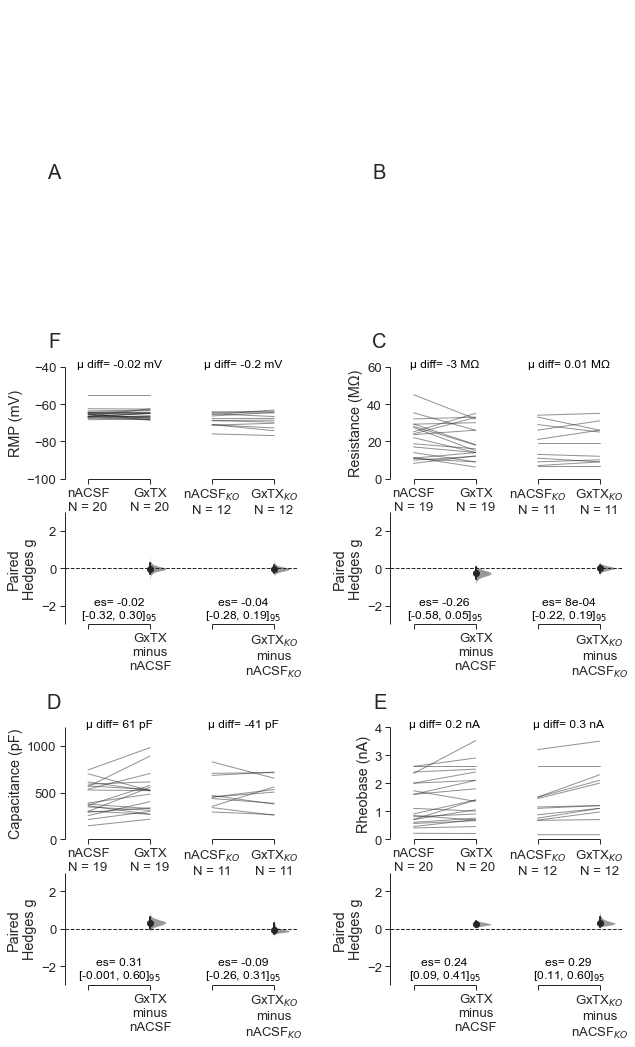

In [52]:
 my_color_palette = {"Con" : "black",
                      "cKO" : "blue"}
f, axx = plt.subplots(nrows=3, ncols=2, figsize=(10,18),gridspec_kw={'wspace': 0.4, 'hspace':0.4})

Res = dabest.load(df, idx=(("nACSF", "GxTX"),('nACSF$_{KO}$', 'GxTX$_{KO}$')),x="rel_cond", y="Res_Mohm",paired=True, id_col="Cell_ID")
Cap = dabest.load(df, idx=(("nACSF", "GxTX"),('nACSF$_{KO}$', 'GxTX$_{KO}$')),x="rel_cond", y="Cap_pF",paired=True, id_col="Cell_ID")
Rheo = dabest.load(df, idx=(("nACSF", "GxTX"),('nACSF$_{KO}$', 'GxTX$_{KO}$')),x="rel_cond", y="Rheo_nA",paired=True, id_col="Cell_ID")
RMP = dabest.load(df, idx=(("nACSF", "GxTX"),('nACSF$_{KO}$', 'GxTX$_{KO}$')),x="rel_cond", y="RMP",paired=True, id_col="Cell_ID")

RM_allspines(0) #removing the last plot for example traces
RM_allspines(1) #removing the last plot for example traces

RMP.hedges_g.plot(ax=axx.flat[2],swarm_ylim=(-100,-40),swarm_label='RMP (mV)', 
                  es_marker_size=6, contrast_ylim=(-3,3), contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
Res.hedges_g.plot(ax=axx.flat[3],swarm_ylim=(0,60),swarm_label='Resistance (M\u03A9)',
                  es_marker_size=6, contrast_ylim=(-3,3), contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
Cap.hedges_g.plot(ax=axx.flat[4],swarm_ylim=(0,1200),swarm_label='Capacitance (pF)', 
                  es_marker_size=6, contrast_ylim=(-3,3), contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
Rheo.hedges_g.plot(ax=axx.flat[5],swarm_ylim=(0,4),swarm_label='Rheobase (nA)', 
                   es_marker_size=6, contrast_ylim=(-3,3), contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));


###Adding text with mean differences and ES values
#text for hedges g plot always 90% lower that diff
#RMP
Stats_text_paired(2,0.5,2.5, -40, -175,'\u03BC diff= -0.02 mV','\u03BC diff= -0.2 mV', "es= -0.02\n[-0.32, 0.30]$_{95}$", "es= -0.04\n[-0.28, 0.19]$_{95}$",12,'center','black')
#Res
Stats_text_paired(3,0.5,2.5, 60, -75,'\u03BC diff= -3 M\u03A9','\u03BC diff= 0.01 M\u03A9', "es= -0.26\n[-0.58, 0.05]$_{95}$", "es= 8e-04\n[-0.22, 0.19]$_{95}$",12,'center','black')
#Cap
Stats_text_paired(4,0.5,2.5, 1200, -1500,'\u03BC diff= 61 pF','\u03BC diff= -41 pF', "es= 0.31\n[-0.001, 0.60]$_{95}$", "es= -0.09\n[-0.26, 0.31]$_{95}$",12,'center','black')
#Rheo
Stats_text_paired(5,0.5,2.5, 4, -5,'\u03BC diff= 0.2 nA','\u03BC diff= 0.3 nA', "es= 0.24\n[0.09, 0.41]$_{95}$", "es= 0.29\n[0.11, 0.60]$_{95}$",12,'center','black')



axx.flat[0].annotate('A', xy=(0,0.3), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[1].annotate('B', xy=(0,0.3), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[2].annotate('F', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[3].annotate('C', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[4].annotate('D', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[5].annotate('E', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')


#plt.savefig(r"C:\Users\csmith\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\GXTX_Passive_ES.svg", dpi=400,bbox_inches='tight')

### (WT) Hedges g Estimation statistics for figure 4 supplement 1



In [53]:
####Passive gxtx HEDGES
Res_Mohm_diff_Stats_GXTX=STAT_hedges(Gxtx_WT_Mature,"nACSF","gxtx-1E","condition","Res_Mohm",'Resistance',True,'Cell_ID',"Con MN (mature)")
Cap_pF_Mohm_diff_Stats_GXTX=STAT_hedges(Gxtx_WT_Mature,"nACSF","gxtx-1E","condition","Cap_pF",'Capacitance',True,'Cell_ID',"Con MN (mature)")
Rheo_nA_diff_Mohm_diff_Stats_GXTX=STAT_hedges(Gxtx_WT_Mature,"nACSF","gxtx-1E","condition","Rheo_nA",'Rheobase',True,'Cell_ID',"COn MN (mature)")
Tau_diff_Mohm_diff_Stats_GXTX=STAT_hedges(Gxtx_WT_Mature,"nACSF","gxtx-1E","condition","Tau_s",'Tau',True,'Cell_ID',"Con MN (mature)")
RMP_diff_Stats_GXTX=STAT_hedges(Gxtx_WT_Mature,"nACSF","gxtx-1E","condition","RMP",'RMP',True,'Cell_ID',"Con MN (mature)")

Combining all firing and AP charactaristics into single DF


In [54]:
to_concat=[Res_Mohm_diff_Stats_GXTX,Cap_pF_Mohm_diff_Stats_GXTX,Rheo_nA_diff_Mohm_diff_Stats_GXTX,Tau_diff_Mohm_diff_Stats_GXTX,RMP_diff_Stats_GXTX]
Con_MN_Mat_Con_Passive_Stats=pd.concat(to_concat)
Con_MN_Mat_Con_Passive_Stats


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,gxtx-1E,19,19,Hedges' g,True,-0.264141,95,-0.585144,0.052854,0.1230,0.133621,56.5,0.115607,1.653288,Resistance,Con MN (mature)
0,nACSF,gxtx-1E,19,19,Hedges' g,True,0.311763,95,-0.001822,0.605453,0.0760,0.123188,56.0,0.069539,-1.929847,Capacitance,Con MN (mature)
0,nACSF,gxtx-1E,20,20,Hedges' g,True,0.244945,95,0.094521,0.414624,0.0052,0.008869,30.0,0.009963,-2.862643,Rheobase,COn MN (mature)
0,nACSF,gxtx-1E,19,19,Hedges' g,True,-0.067787,95,-0.507283,0.247501,0.7466,0.984322,94.0,0.721552,0.362020,Tau,Con MN (mature)
0,nACSF,gxtx-1E,20,20,Hedges' g,True,-0.022150,95,-0.322361,0.306382,0.8618,0.743774,78.0,0.855792,0.184221,RMP,Con MN (mature)


### (WT) Mean Difference Estimation statistics for figure 4 supplement 1

Resistance

In [55]:
Res_Mohm_diff_Stats_GXTX_DIFFS=STAT_mean(Gxtx_WT_Mature,"nACSF","gxtx-1E","condition","Res_Mohm",'Resistance',True,'Cell_ID',"Con MN (mature)")


Capacitance

In [56]:
Cap_pF_Mohm_diff_Stats_GXTX_DIFFS=STAT_mean(Gxtx_WT_Mature,"nACSF","gxtx-1E","condition","Cap_pF",'Capacitance',True,'Cell_ID',"Con MN (mature)")


Rheobase

Note that the warning message is related to P values, which are not used in this study. 


In [57]:
Rheo_nA_diff_Mohm_diff_Stats_GXTX_DIFFS=STAT_mean(Gxtx_WT_Mature,"nACSF","gxtx-1E","condition","Rheo_nA",'Rheobase',True,'Cell_ID',"COn MN (mature)")



C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Tau

In [58]:
Tau_diff_Mohm_diff_Stats_GXTX_DIFFS=STAT_mean(Gxtx_WT_Mature,"nACSF","gxtx-1E","condition","Tau_s",'Tau',True,'Cell_ID',"Con MN (mature)")


RMP

In [59]:
RMP_diff_Stats_GXTX_DIFFS=STAT_mean(Gxtx_WT_Mature,"nACSF","gxtx-1E","condition","RMP",'RMP',True,'Cell_ID',"Con MN (mature)")

Combining all firing and AP charactaristics into single DF


In [60]:
to_concat=[Res_Mohm_diff_Stats_GXTX_DIFFS,Cap_pF_Mohm_diff_Stats_GXTX_DIFFS,Rheo_nA_diff_Mohm_diff_Stats_GXTX_DIFFS,Tau_diff_Mohm_diff_Stats_GXTX_DIFFS,RMP_diff_Stats_GXTX_DIFFS]
Con_MN_Mat_Con_Passive_Stats_DIFFS=pd.concat(to_concat)
Con_MN_Mat_Con_Passive_Stats_DIFFS


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,gxtx-1E,19,19,mean difference,True,-2.610526,95,-5.542105,0.352632,0.1230,0.133621,56.5,0.115607,1.653288,Resistance,Con MN (mature)
0,nACSF,gxtx-1E,19,19,mean difference,True,60.705256,95,3.334118,121.969624,0.0760,0.123188,56.0,0.069539,-1.929847,Capacitance,Con MN (mature)
0,nACSF,gxtx-1E,20,20,mean difference,True,0.215500,95,0.089000,0.383500,0.0052,0.008869,30.0,0.009963,-2.862643,Rheobase,COn MN (mature)
0,nACSF,gxtx-1E,19,19,mean difference,True,-0.128263,95,-0.955482,0.422194,0.7466,0.984322,94.0,0.721552,0.362020,Tau,Con MN (mature)
0,nACSF,gxtx-1E,20,20,mean difference,True,-0.067000,95,-0.699000,0.707000,0.8618,0.743774,78.0,0.855792,0.184221,RMP,Con MN (mature)


### (cKO) Hedges g Estimation statistics for figure 4 supplement 1


KO Resistance

Note warning for small sample size only related to traditional P-value hypothesis testing. Boot strapped confidence intervals used in this study

In [61]:
KO_Res_Mohm_diff_Stats_GXTX=STAT_hedges(Gxtx_KO_Mature,"nACSF","gxtx-1E","condition","Res_Mohm",'Resistance',True,'Cell_ID',"cKO MN (mature)")


C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


KO Capacitance

In [62]:
KO_Cap_pF_Mohm_diff_Stats_GXTX=STAT_hedges(Gxtx_KO_Mature,"nACSF","gxtx-1E","condition","Cap_pF",'Capacitance',True,'Cell_ID',"cKO MN (mature)")


KO Rheobase

In [63]:
KO_Rheo_nA_diff_Mohm_diff_Stats_GXTX=STAT_hedges(Gxtx_KO_Mature,"nACSF","gxtx-1E","condition","Rheo_nA",'Rheobase',True,'Cell_ID',"cKO MN (mature)")


KO Tau

In [64]:
KO_Tau_diff_Mohm_diff_Stats_GXTX=STAT_hedges(Gxtx_KO_Mature,"nACSF","gxtx-1E","condition","Tau_s",'Tau',True,'Cell_ID',"cKO MN (mature)")


KO RMP

In [65]:
KO_RMP_diff_Stats_GXTX=STAT_hedges(Gxtx_KO_Mature,"nACSF","gxtx-1E","condition","RMP",'RMP',True,'Cell_ID',"cKO MN (mature)")

In [66]:
#Combining all firing and AP charactaristics into single DF
to_concat=[KO_Res_Mohm_diff_Stats_GXTX,KO_Cap_pF_Mohm_diff_Stats_GXTX,KO_Rheo_nA_diff_Mohm_diff_Stats_GXTX,
          KO_Tau_diff_Mohm_diff_Stats_GXTX,KO_RMP_diff_Stats_GXTX]
KO_MN_Mat_Con_Passive_Stats_Hedges=pd.concat(to_concat)
KO_MN_Mat_Con_Passive_Stats_Hedges


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,gxtx-1E,11,11,Hedges' g,True,0.000860,95,-0.229032,0.194208,0.9246,0.858586,21.0,0.993395,-0.008487,Resistance,cKO MN (mature)
0,nACSF,gxtx-1E,11,11,Hedges' g,True,-0.092877,95,-0.260208,0.313436,0.4604,0.519531,25.0,0.410427,0.859061,Capacitance,cKO MN (mature)
0,nACSF,gxtx-1E,12,12,Hedges' g,True,0.296449,95,0.117457,0.601849,0.0008,0.004439,1.0,0.003979,-3.626806,Rheobase,cKO MN (mature)
0,nACSF,gxtx-1E,11,11,Hedges' g,True,-0.079067,95,-0.488836,0.239406,0.6438,0.700195,28.0,0.671688,0.436585,Tau,cKO MN (mature)
0,nACSF,gxtx-1E,12,12,Hedges' g,True,-0.043650,95,-0.280720,0.196020,0.7030,0.909668,37.0,0.705522,0.387857,RMP,cKO MN (mature)


### Mean Differences Estimation statistics for figure 4 supplement 1


Resistance

In [67]:
Res_Mohm_diff_Stats_GXTX_DIFFS_KO=STAT_mean(Gxtx_KO_Mature,"nACSF","gxtx-1E","condition","Res_Mohm",'Resistance',True,'Cell_ID',"cKO MN (mature)")


C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Capacitance

In [68]:
Cap_pF_Mohm_diff_Stats_GXTX_DIFFS_KO=STAT_mean(Gxtx_KO_Mature,"nACSF","gxtx-1E","condition","Cap_pF",'Capacitance',True,'Cell_ID',"cKO MN (mature)")


Rheobase

In [69]:
Rheo_nA_diff_Mohm_diff_Stats_GXTX_DIFFS_KO=STAT_mean(Gxtx_KO_Mature,"nACSF","gxtx-1E","condition","Rheo_nA",'Rheobase',True,'Cell_ID',"cKO MN (mature)")


Tau

In [70]:
Tau_diff_Mohm_diff_Stats_GXTX_DIFFS_KO=STAT_mean(Gxtx_KO_Mature,"nACSF","gxtx-1E","condition","Tau_s",'Tau',True,'Cell_ID',"cKO MN (mature)")


RMP

In [71]:
RMP_diff_Stats_GXTX_DIFFS_KO=STAT_mean(Gxtx_KO_Mature,"nACSF","gxtx-1E","condition","RMP",'RMP',True,'Cell_ID',"cKO MN (mature)")

In [72]:
to_concat=[Res_Mohm_diff_Stats_GXTX_DIFFS_KO,Cap_pF_Mohm_diff_Stats_GXTX_DIFFS_KO, Rheo_nA_diff_Mohm_diff_Stats_GXTX_DIFFS_KO,Tau_diff_Mohm_diff_Stats_GXTX_DIFFS_KO,RMP_diff_Stats_GXTX_DIFFS_KO
]
KO_MN_Mat_Con_Passive_Stats_Mean_diffs=pd.concat(to_concat)
KO_MN_Mat_Con_Passive_Stats_Mean_diffs

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,gxtx-1E,11,11,mean difference,True,0.009091,95,-2.272727,1.836364,0.9246,0.858586,21.0,0.993395,-0.008487,Resistance,cKO MN (mature)
0,nACSF,gxtx-1E,11,11,mean difference,True,-41.336600,95,-162.921332,28.989013,0.4604,0.519531,25.0,0.410427,0.859061,Capacitance,cKO MN (mature)
0,nACSF,gxtx-1E,12,12,mean difference,True,0.274917,95,0.154917,0.445833,0.0008,0.004439,1.0,0.003979,-3.626806,Rheobase,cKO MN (mature)
0,nACSF,gxtx-1E,11,11,mean difference,True,-0.297359,95,-1.809278,0.759730,0.6438,0.700195,28.0,0.671688,0.436585,Tau,cKO MN (mature)
0,nACSF,gxtx-1E,12,12,mean difference,True,-0.179167,95,-1.058333,0.641667,0.7030,0.909668,37.0,0.705522,0.387857,RMP,cKO MN (mature)


## 📊 Figure 4. K$_V$2 inhibition does not significantly affect motoneuron maximal firing or excitability.

Note F is a place holder

Adding new label column for proper labeling of graphs


In [73]:
Gxtx_KO_Mature['rel_cond']= np.where(Gxtx_KO_Mature['condition']=='nACSF', 'nACSF$_{KO}$', "GxTX$_{KO}$")
Gxtx_WT_Mature['rel_cond']= np.where(Gxtx_WT_Mature['condition']=='nACSF', 'nACSF', "GxTX")
df=pd.concat([Gxtx_WT_Mature, Gxtx_KO_Mature], ignore_index=True)

C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Text(-4, 4, 'F')

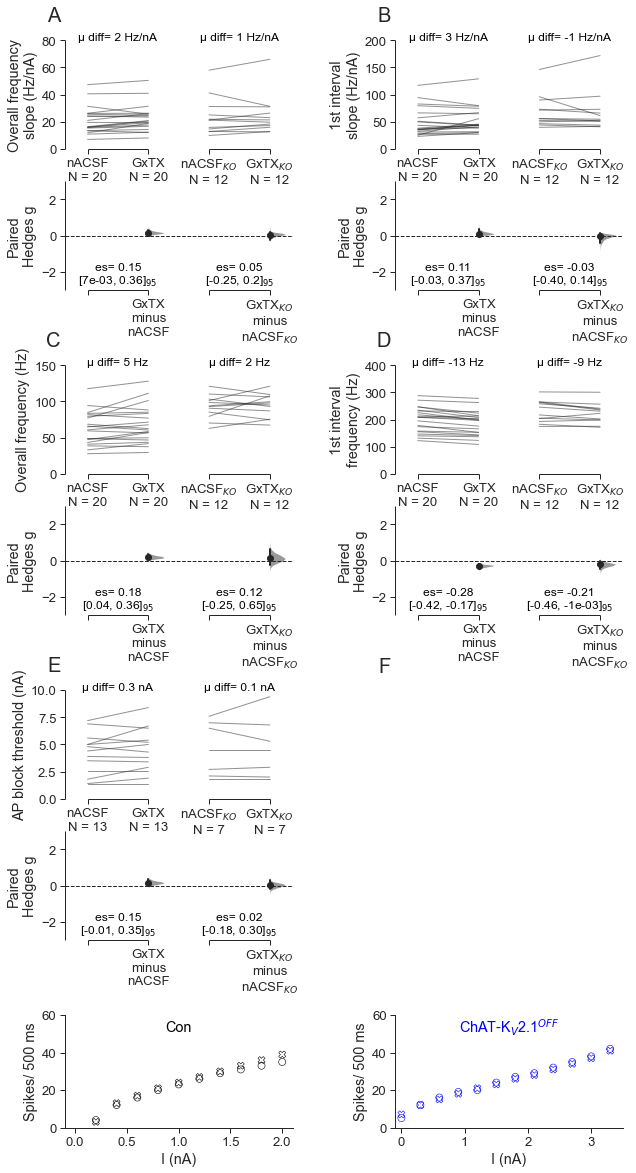

In [74]:
f, axx = plt.subplots(nrows=4, ncols=2, figsize=(10,20),gridspec_kw={'wspace': 0.45, 'hspace':0.35, 'height_ratios': [1,1,1,0.45] })



MeanSlope = dabest.load(df, idx=(("nACSF", "GxTX"),('nACSF$_{KO}$', "GxTX$_{KO}$")),x="rel_cond", y="slope_mean",paired=True, id_col="Cell_ID")
MaxSlope = dabest.load(df, idx=(("nACSF", "GxTX"),('nACSF$_{KO}$', "GxTX$_{KO}$")),x="rel_cond", y="slope_max",paired=True, id_col="Cell_ID")
MeanFrq = dabest.load(df, idx=(("nACSF", "GxTX"),('nACSF$_{KO}$', "GxTX$_{KO}$")),x="rel_cond", y="Mean_FF",paired=True, id_col="Cell_ID")
InitialFrq = dabest.load(df, idx=(("nACSF", "GxTX"),('nACSF$_{KO}$', "GxTX$_{KO}$")),x="rel_cond", y="Max_FF",paired=True, id_col="Cell_ID")
#MaxAPs = dabest.load(df, idx=(("nACSF", "GxTX"),('nACSF$_{KO}$', "GxTX$_{KO}$")),x="rel_cond", y="Max_Spikes",paired=True, id_col="Cell_ID")
AP_Block = dabest.load(df, idx=(("nACSF", "GxTX"),('nACSF$_{KO}$', "GxTX$_{KO}$")),x="rel_cond", y="block_thresh_nA",paired=True, id_col="Cell_ID")



MeanSlope.hedges_g.plot(ax=axx.flat[0],swarm_ylim=(0,80),swarm_label='Overall frequency\nslope (Hz/nA)', 
                        es_marker_size=6, contrast_ylim=(-3,3),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
MaxSlope.hedges_g.plot(ax=axx.flat[1],swarm_ylim=(0,200),swarm_label='1st interval\nslope (Hz/nA)',
                       es_marker_size=6, contrast_ylim=(-3,3),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
MeanFrq.hedges_g.plot(ax=axx.flat[2],swarm_ylim=(0,150),swarm_label='Overall frequency (Hz)',
                      es_marker_size=6, contrast_ylim=(-3,3),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
InitialFrq.hedges_g.plot(ax=axx.flat[3],swarm_ylim=(0,400),swarm_label='1st interval\nfrequency (Hz)',
                         es_marker_size=6, contrast_ylim=(-3,3),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
#MaxAPs.hedges_g.plot(ax=axx.flat[4],swarm_ylim=(0,100),swarm_label='Maximum spikes',
    #                 es_marker_size=6, contrast_ylim=(-3,3),contrast_label='Paired\nHedges g',
    #                    reflines_kwargs=dict(linestyle='--', linewidth=1));
AP_Block.hedges_g.plot(ax=axx.flat[4],swarm_ylim=(0,10),swarm_label='AP block threshold (nA)',
                       es_marker_size=6, contrast_ylim=(-3,3),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));



###Adding text with mean differences and ES values
#text for hedges g plot always 43.75% lower that diff
#MeanSlope
Stats_text_paired(0,0.5,2.5, 80, -100,'\u03BC diff= 2 Hz/nA','\u03BC diff= 1 Hz/nA', "es= 0.15\n[7e-03, 0.36]$_{95}$", "es= 0.05\n[-0.25, 0.2]$_{95}$",12,'center','black')
#MaxSlope
Stats_text_paired(1,0.5,2.5, 200, -250,'\u03BC diff= 3 Hz/nA','\u03BC diff= -1 Hz/nA', "es= 0.11\n[-0.03, 0.37]$_{95}$", "es= -0.03\n[-0.40, 0.14]$_{95}$",12,'center','black')
#mean frequency
Stats_text_paired(2,0.5,2.5, 150, -187.5,'\u03BC diff= 5 Hz','\u03BC diff= 2 Hz', "es= 0.18\n[0.04, 0.36]$_{95}$", "es= 0.12\n[-0.25, 0.65]$_{95}$",12,'center','black')

#initial freq
Stats_text_paired(3,0.5,2.5, 400, -500,'\u03BC diff= -13 Hz','\u03BC diff= -9 Hz', "es= -0.28\n[-0.42, -0.17]$_{95}$", "es= -0.21\n[-0.46, -1e-03]$_{95}$",12,'center','black')

#Max APs
#Stats_text_paired(4,0.5,2.5, 100, -125,'\u03BC diff= 0.75','\u03BC diff= 2.33', "es= 0.05\n[-0.05, 0.16]$_{95}$", "es= 0.24\n[-0.20, 0.80]$_{95}$",12,'center','black')

#AP block
Stats_text_paired(4,0.5,2.5, 10, -12.5,'\u03BC diff= 0.3 nA','\u03BC diff= 0.1 nA', "es= 0.15\n[-0.01, 0.35]$_{95}$", "es= 0.02\n[-0.18, 0.30]$_{95}$",12,'center','black')




##########Example F-I###############
from matplotlib.lines import Line2D
Example_FI_plots = pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\Kv2.1_KO_Analysis\Example_F_I_plots_paper.xlsx",
                         sheet_name='ABS_C2')
##Max spikes ABS_C2###
ax = axx.flat[6]
Scatter_params(6,Example_FI_plots,"Max spikes","I (nA)","condition","black","black","upper right",1.35, 0.7
               ,0,60,-0.1,2.1,"condition",50, "Spikes/ 500 ms",'none','black')
ax.set_title('Con', x=0.5, y=0.8,color='black')
axx.flat[6].get_legend().remove()
#legend_elements = [Line2D([0], [0], marker='o', color='0.1', lw=0, label='nACSF'),
#                   Line2D([0], [0], marker='x', color='0.1',lw=0, label='GxTX')]            #defining custom legend params


##Max spikes ACG_C2###
Example_FI_plots = pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_paper_Allfiles_for_jupyterNB\Example_F_I_plots_paper.xlsx",
                         sheet_name='ACG_C2')
ax = axx.flat[7]
Scatter_params(7,Example_FI_plots,"Max spikes","I (nA)","condition","blue","blue","upper left",0, 1
               ,0,60,-0.1,3.5,"condition",50,"Spikes/ 500 ms", 'none', 'blue')

ax.set_title("ChAT-K$_V$2.1$^{OFF}$", x=0.5, y=0.8, color='blue')
plt.legend([],[], frameon=False)

RM_allspines(5) #removing the last plot for example traces

axx.flat[0].annotate('A', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[1].annotate('B', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[2].annotate('C', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[3].annotate('D', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[4].annotate('E', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[5].annotate('F', xy=(0,1.04), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
#axx.flat[6].annotate('G', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
#axx.flat[7].annotate('H', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')

#plt.savefig(r"C:\Users\csmith\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\GXTX_Firing_Con_KO_ES.svg", dpi=300,bbox_inches='tight')
#multi_2group_paired.mean_diff.plot(swarm_ylim=(0,1),swarm_label='AP HW (ms)', es_marker_size=6);
#plt.tight_layout()


### (WT) Hedges g Estimation statistics for figure 4 

Overall frequency slope 

In [75]:
Con_MN_Mat_slope_mean_Stats_gxtx=STAT_hedges(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","slope_mean",'mean freq FI',True,"Cell_ID","Con MN (mature)")


1st interval slope

In [76]:
Con_MN_Mat_slope_max_Stats_gxtx=STAT_hedges(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","slope_max",'initial FI',True,"Cell_ID","Con MN (mature)")


Overall frequency

In [77]:
Con_MN_Mat_Mean_FF_Stats_gxtx=STAT_hedges(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","Mean_FF",'Peak mean freq',True,"Cell_ID","Con MN (mature)")


1st interval frequency

In [78]:
Con_MN_Mat_Max_FF_Stats_gxtx=STAT_hedges(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","Max_FF",'Peak init freq',True,"Cell_ID","Con MN (mature)")


AP block threshold

In [79]:
Con_MN_Mat_block_thresh_nA_Stats_gxtx=STAT_hedges(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","block_thresh_nA",'block thresh nA',True,"Cell_ID","Con MN (mature)")


C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [80]:
#Combining all WT firing charactaristics stats into single DF
to_concat=[Con_MN_Mat_slope_mean_Stats_gxtx,Con_MN_Mat_slope_max_Stats_gxtx,Con_MN_Mat_Mean_FF_Stats_gxtx,
           Con_MN_Mat_Max_FF_Stats_gxtx,Con_MN_Mat_block_thresh_nA_Stats_gxtx]
ALL_MN_Mat_Con_firing_Stats_Hedges=pd.concat(to_concat)
ALL_MN_Mat_Con_firing_Stats_Hedges


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,gxtx-1E,20,20,Hedges' g,True,0.154858,95,0.007330,0.336210,0.0312,0.017181,42.0,0.026213,-2.410739,mean freq FI,Con MN (mature)
0,nACSF,gxtx-1E,20,20,Hedges' g,True,0.116968,95,-0.030768,0.379389,0.1872,0.123093,63.0,0.178222,-1.398000,initial FI,Con MN (mature)
0,nACSF,gxtx-1E,20,20,Hedges' g,True,0.184947,95,0.041795,0.369533,0.0286,0.069580,56.0,0.039487,-2.211095,Peak mean freq,Con MN (mature)
0,nACSF,gxtx-1E,20,20,Hedges' g,True,-0.280657,95,-0.421870,-0.177146,0.0000,0.000006,2.0,0.000010,5.968728,Peak init freq,Con MN (mature)
0,nACSF,gxtx-1E,13,13,Hedges' g,True,0.150380,95,-0.014492,0.350135,0.1528,0.154248,17.0,0.132488,-1.614050,block thresh nA,Con MN (mature)


### (WT) Mean difference estimation statistics for figure 4 

Overall frequency slope

In [82]:
Con_MN_Mat_slope_mean_Stats_gxtx_MEAN_DIFF=STAT_mean(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","slope_mean",'mean freq FI',True,"Cell_ID","Con MN (mature)")


1st interval frequency slope

In [83]:
Con_MN_Mat_slope_max_Stats_gxtx_MEAN_DIFF=STAT_mean(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","slope_max",'initial FI',True,"Cell_ID","Con MN (mature)")


Overall frequency

In [84]:
Con_MN_Mat_Mean_FF_Stats_gxtx_MEAN_DIFF=STAT_mean(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","Mean_FF",'Peak mean freq',True,"Cell_ID","Con MN (mature)")


1st interval frequency

In [85]:
Con_MN_Mat_Max_FF_Stats_gxtx_MEAN_DIFF=STAT_mean(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","Max_FF",'Peak init freq',True,"Cell_ID","Con MN (mature)")


AP block threshold

In [86]:
Con_MN_Mat_block_thresh_nA_Stats_gxtx_MEAN_DIFF=STAT_mean(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","block_thresh_nA",'block thresh nA',True,"Cell_ID","Con MN (mature)")


In [87]:
#Combining all WT firing charactaristics stats into single DF
to_concat=[Con_MN_Mat_slope_mean_Stats_gxtx_MEAN_DIFF,Con_MN_Mat_slope_max_Stats_gxtx_MEAN_DIFF,Con_MN_Mat_Mean_FF_Stats_gxtx_MEAN_DIFF,
           Con_MN_Mat_Max_FF_Stats_gxtx_MEAN_DIFF,Con_MN_Mat_block_thresh_nA_Stats_gxtx_MEAN_DIFF]
ALL_MN_Mat_Con_firing_Stats_Mean=pd.concat(to_concat)
ALL_MN_Mat_Con_firing_Stats_Mean


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,gxtx-1E,20,20,mean difference,True,1.569476,95,1.861217e-01,2.762410,0.0312,0.017181,42.0,0.026213,-2.410739,mean freq FI,Con MN (mature)
0,nACSF,gxtx-1E,20,20,mean difference,True,2.995786,95,-5.509240e-01,7.786225,0.1872,0.123093,63.0,0.178222,-1.398000,initial FI,Con MN (mature)
0,nACSF,gxtx-1E,20,20,mean difference,True,4.595716,95,1.182203e+00,9.501345,0.0286,0.069580,56.0,0.039487,-2.211095,Peak mean freq,Con MN (mature)
0,nACSF,gxtx-1E,20,20,mean difference,True,-13.309660,95,-1.791144e+01,-9.562571,0.0000,0.000006,2.0,0.000010,5.968728,Peak init freq,Con MN (mature)
0,nACSF,gxtx-1E,13,13,mean difference,True,0.307692,95,-1.024821e-16,0.738462,0.1528,0.154248,17.0,0.132488,-1.614050,block thresh nA,Con MN (mature)


### (cKO) Hedges g Estimation statistics for figure 4

Overall frequency slope

In [88]:
KO_MN_Mat_slope_mean_Stats_gxtx=STAT_hedges(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","slope_mean",'mean freq FI',True,"Cell_ID","cKO MN (mature)")


1st interval frequncy slope

In [89]:
KO_MN_Mat_slope_max_Stats_gxtx=STAT_hedges(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","slope_max",'initial FI',True,"Cell_ID","cKO MN (mature)")


Overall frequency

In [90]:
KO_MN_Mat_Mean_FF_Stats_gxtx=STAT_hedges(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","Mean_FF",'Peak mean freq',True,"Cell_ID","cKO MN (mature)")


1st interval frequency

In [91]:
KO_MN_Mat_Max_FF_Stats_gxtx=STAT_hedges(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","Max_FF",'Peak init freq',True,"Cell_ID","cKO MN (mature)")


AP block threshold

In [92]:
KO_MN_Mat_block_thresh_nA_Stats_gxtx=STAT_hedges(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","block_thresh_nA",'block thresh nA',True,"Cell_ID","cKO MN (mature)")


C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [93]:
#Combining all firing and AP charactaristics into single DF
to_concat=[KO_MN_Mat_slope_mean_Stats_gxtx,KO_MN_Mat_slope_max_Stats_gxtx,KO_MN_Mat_Mean_FF_Stats_gxtx,KO_MN_Mat_Max_FF_Stats_gxtx,KO_MN_Mat_block_thresh_nA_Stats_gxtx]
ALL_KO_MN_Mat_Con_firing_Stats_HedgesG=pd.concat(to_concat)
ALL_KO_MN_Mat_Con_firing_Stats_HedgesG


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,gxtx-1E,12,12,Hedges' g,True,0.054735,95,-0.252276,0.201114,0.5310,0.469727,29.0,0.546319,-0.622472,mean freq FI,cKO MN (mature)
0,nACSF,gxtx-1E,12,12,Hedges' g,True,-0.038207,95,-0.401651,0.148095,0.6624,0.569336,31.0,0.738846,0.341931,initial FI,cKO MN (mature)
0,nACSF,gxtx-1E,12,12,Hedges' g,True,0.125219,95,-0.251835,0.657460,0.5674,0.733398,34.0,0.574633,-0.578418,Peak mean freq,cKO MN (mature)
0,nACSF,gxtx-1E,12,12,Hedges' g,True,-0.214908,95,-0.465806,-0.001972,0.0510,0.052246,14.0,0.048505,2.218353,Peak init freq,cKO MN (mature)
0,nACSF,gxtx-1E,7,7,Hedges' g,True,0.025588,95,-0.189081,0.306811,0.8130,0.892738,7.0,0.838566,-0.212750,block thresh nA,cKO MN (mature)


### (cKO) Mean Differences Estimation statistics for figure 4

Overall frequency slope

In [94]:
KO_MN_Mat_slope_mean_Stats_gxtx_DIFFS=STAT_mean(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","slope_mean",'mean freq FI',True,"Cell_ID","cKO MN (mature)")


1st interval frequency

In [95]:
KO_MN_Mat_slope_max_Stats_gxtx_DIFFS=STAT_mean(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","slope_max",'initial FI',True,"Cell_ID","cKO MN (mature)")


Overall frequency

In [96]:
KO_MN_Mat_Mean_FF_Stats_gxtx_DIFFS=STAT_mean(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","Mean_FF",'Peak mean freq',True,"Cell_ID","cKO MN (mature)")


1st interval frequency

In [97]:
KO_MN_Mat_Max_FF_Stats_gxtx_DIFFS=STAT_mean(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","Max_FF",'Peak init freq',True,"Cell_ID","cKO MN (mature)")


AP block threshold

In [98]:
KO_MN_Mat_block_thresh_nA_Stats_gxtx_DIFFS=STAT_mean(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","block_thresh_nA",'block thresh nA',True,"Cell_ID","cKO MN (mature)")


C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [99]:
#Combining all firing and AP charactaristics into single DF
to_concat=[KO_MN_Mat_slope_mean_Stats_gxtx_DIFFS,KO_MN_Mat_slope_max_Stats_gxtx_DIFFS,KO_MN_Mat_Mean_FF_Stats_gxtx_DIFFS,KO_MN_Mat_Max_FF_Stats_gxtx_DIFFS,
KO_MN_Mat_block_thresh_nA_Stats_gxtx_DIFFS]
ALL_KO_MN_Mat_Con_firing_Stats_gxtx_DIFFS=pd.concat(to_concat)
ALL_KO_MN_Mat_Con_firing_Stats_gxtx_DIFFS


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,gxtx-1E,12,12,mean difference,True,0.803928,95,-2.149050,2.941354,0.5310,0.469727,29.0,0.546319,-0.622472,mean freq FI,cKO MN (mature)
0,nACSF,gxtx-1E,12,12,mean difference,True,-1.330749,95,-9.923546,5.332107,0.6624,0.569336,31.0,0.738846,0.341931,initial FI,cKO MN (mature)
0,nACSF,gxtx-1E,12,12,mean difference,True,2.107272,95,-3.687798,10.457641,0.5674,0.733398,34.0,0.574633,-0.578418,Peak mean freq,cKO MN (mature)
0,nACSF,gxtx-1E,12,12,mean difference,True,-8.545008,95,-15.127021,-0.668847,0.0510,0.052246,14.0,0.048505,2.218353,Peak init freq,cKO MN (mature)
0,nACSF,gxtx-1E,7,7,mean difference,True,0.071429,95,-0.414286,0.828571,0.8130,0.892738,7.0,0.838566,-0.212750,block thresh nA,cKO MN (mature)


## 📊 Figure 5. Comparing the effects of K$_V$2 inhibition with GxTX-1E on action potential characteristics in control and K$_V$2.1$^{OFF}$ motoneurons

Note A is a place holder for exmaple traces inserted in corel draw. 

C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Text(-4, 4, 'F')

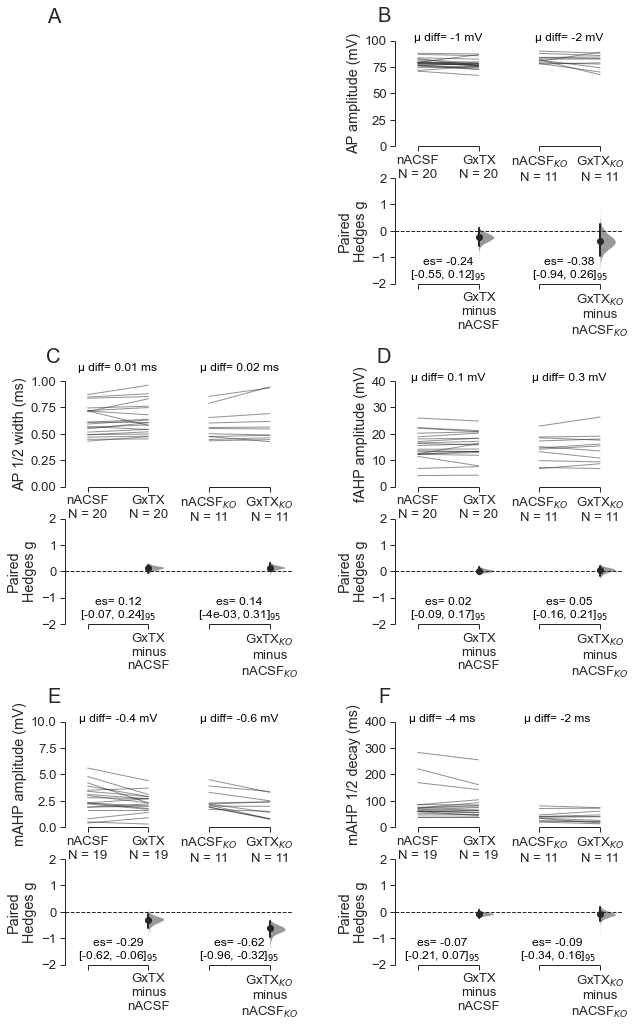

In [100]:
f, axx = plt.subplots(nrows=3, ncols=2, figsize=(10,17),gridspec_kw={'wspace': 0.45, 'hspace':0.4 })

AP_HW = dabest.load(df, idx=(("nACSF", "GxTX"),('nACSF$_{KO}$', "GxTX$_{KO}$")),x="rel_cond", y="AP_HW",paired=True, id_col="Cell_ID")
fAHP = dabest.load(df, idx=(("nACSF", "GxTX"),('nACSF$_{KO}$', "GxTX$_{KO}$")),x="rel_cond", y="fAHP_AMP",paired=True, id_col="Cell_ID")
AP_Amp = dabest.load(df, idx=(("nACSF", "GxTX"),('nACSF$_{KO}$', "GxTX$_{KO}$")),x="rel_cond", y="AP_AMP",paired=True, id_col="Cell_ID")
mAHP_amp = dabest.load(df, idx=(("nACSF", "GxTX"),('nACSF$_{KO}$', "GxTX$_{KO}$")),x="rel_cond", y="mAHP_AMP",paired=True, id_col="Cell_ID")
mAHP_Dur = dabest.load(df, idx=(("nACSF", "GxTX"),('nACSF$_{KO}$', "GxTX$_{KO}$")),x="rel_cond", y="mAHP_half_Duration",paired=True, id_col="Cell_ID")

RM_allspines(0) #removing the 1st plot for example traces
AP_Amp.hedges_g.plot(ax=axx.flat[1],swarm_ylim=(0,100),swarm_label='AP amplitude (mV)', es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
AP_HW.hedges_g.plot(ax=axx.flat[2],swarm_ylim=(0,1),swarm_label='AP 1/2 width (ms)', es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
fAHP.hedges_g.plot(ax=axx.flat[3],swarm_ylim=(0,40),swarm_label='fAHP amplitude (mV)', es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));

mAHP_amp.hedges_g.plot(ax=axx.flat[4],swarm_ylim=(0,10),swarm_label='mAHP amplitude (mV)', es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
mAHP_Dur.hedges_g.plot(ax=axx.flat[5],swarm_ylim=(0,400),swarm_label='mAHP 1/2 decay (ms)', es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));

#AP_AMP
Stats_text_paired(1,0.5,2.5, 100, -125,'\u03BC diff= -1 mV','\u03BC diff= -2 mV', "es= -0.24\n[-0.55, 0.12]$_{95}$", "es= -0.38\n[-0.94, 0.26]$_{95}$",12,'center','black')

#HW
Stats_text_paired(2,0.5,2.5, 1.1, -1.25,'\u03BC diff= 0.01 ms','\u03BC diff= 0.02 ms', "es= 0.12\n[-0.07, 0.24]$_{95}$", "es= 0.14\n[-4e-03, 0.31]$_{95}$",12,'center','black')

#fAHP

Stats_text_paired(3,0.5,2.5, 40, -50,'\u03BC diff= 0.1 mV','\u03BC diff= 0.3 mV', "es= 0.02\n[-0.09, 0.17]$_{95}$", "es= 0.05\n[-0.16, 0.21]$_{95}$",12,'center','black')

#mAHP
Stats_text_paired(4,0.5,2.5, 10, -12.5,'\u03BC diff= -0.4 mV','\u03BC diff= -0.6 mV', "es= -0.29\n[-0.62, -0.06]$_{95}$", "es= -0.62\n[-0.96, -0.32]$_{95}$",12,'center','black')

#mAHP duration
Stats_text_paired(5,0.4,2.3, 400, -500,'\u03BC diff= -4 ms','\u03BC diff= -2 ms', "es= -0.07\n[-0.21, 0.07]$_{95}$", "es= -0.09\n[-0.34, 0.16]$_{95}$",12,'center','black')

axx.flat[0].annotate('A', xy=(0,1.04), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[1].annotate('B', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[2].annotate('C', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[3].annotate('D', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[4].annotate('E', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[5].annotate('F', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')



#plt.savefig(r"C:\Users\csmith\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\GXTX_APs_Con_KO_Dabest.svg", dpi=300,bbox_inches='tight')
#multi_2group_paired.mean_diff.plot(swarm_ylim=(0,1),swarm_label='AP HW (ms)', es_marker_size=6);
#plt.tight_layout()
#find out how graphs are labelled in script

### (WT) Hedges g Estimation statistics for figure 5 

AP 1/2 wdth

In [101]:
Con_MN_Mat_AP_HW_Stats_gxtx=STAT_hedges(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","AP_HW",'AP HW',True,"Cell_ID","Con MN (mature)")


fAHP amplitude

In [102]:
Con_MN_Mat_fAHP_Stats_gxtx=STAT_hedges(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","fAHP_AMP",'fAHP amp',True,"Cell_ID","Con MN (mature)")


AP amplitude 

In [103]:
Con_MN_Mat_AP_AMP_AMP_Stats_gxtx=STAT_hedges(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","AP_AMP",'AP amp',True,"Cell_ID","Con MN (mature)")


mAHP amplitude

In [104]:
Con_MN_Mat_mAHP_AMP_Stats_gxtx=STAT_hedges(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","mAHP_AMP",'mAHP amp',True,"Cell_ID","Con MN (mature)")


mAHP 1/2 duration

In [105]:
Con_MN_Mat_mAHP_half_Duration_Stats_gxtx=STAT_hedges(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","mAHP_half_Duration",'mAHP half duration',True,"Cell_ID","Con MN (mature)")


AP 1/2 width at 3 X

In [106]:
Con_MN_Mat_Mean_AP_3x_thresh_Stats_gxtx=STAT_hedges(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","Mean_AP_3x_thresh",'Mean AP HW 3T',True,"Cell_ID","Con MN (mature)")


AP trough potential at 3 X

In [107]:
Con_MN_Mat_Mean_trough_3x_thresh_Stats_gxtx=STAT_hedges(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","Mean_trough_3x_thresh",'Mean trough amp 3T',True,"Cell_ID","Con MN (mature)")


AP amplitude at 3 X

In [108]:
Con_MN_Mat_Apamp_mean_Stats_gxtx=STAT_hedges(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","Apamp_mean",'mean AP amp 3T',True,"Cell_ID","Con MN (mature)")


In [109]:
#Combining all AP charactaristics into single DF
to_concat=[Con_MN_Mat_AP_HW_Stats_gxtx,Con_MN_Mat_fAHP_Stats_gxtx,Con_MN_Mat_AP_AMP_AMP_Stats_gxtx,Con_MN_Mat_mAHP_AMP_Stats_gxtx,
           Con_MN_Mat_mAHP_half_Duration_Stats_gxtx,Con_MN_Mat_Mean_AP_3x_thresh_Stats_gxtx,Con_MN_Mat_Mean_trough_3x_thresh_Stats_gxtx,Con_MN_Mat_Apamp_mean_Stats_gxtx]
ALL_MN_Mat_Con_AP_Stats_GXTX_Hedges=pd.concat(to_concat)


### (WT) Mean Difference Estimation statistics for figure 5

In [110]:
#### fAHP
#### AP AMP
#### mAHP AMP
#### mAHP AMP
#### Mean AP 3x thresh
#### Mean trough 3x thresh
#### Ap amp mean



AP 1/2 width

In [111]:
Con_MN_Mat_AP_HW_Stats_gxtx_MeanDIFF=STAT_mean(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","AP_HW",'AP HW',True,"Cell_ID","Con MN (mature)")


fAHP amplitude

In [112]:
Con_MN_Mat_fAHP_Stats_gxtx_MeanDIFF=STAT_mean(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","fAHP_AMP",'fAHP amp',True,"Cell_ID","Con MN (mature)")


AP amplitude

In [113]:
Con_MN_Mat_AP_AMP_AMP_Stats_gxtx_MeanDIFF=STAT_mean(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","AP_AMP",'AP amp',True,"Cell_ID","Con MN (mature)")


mAHP amplitude

In [114]:
Con_MN_Mat_mAHP_AMP_Stats_gxtx_MeanDIFF=STAT_mean(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","mAHP_AMP",'mAHP amp',True,"Cell_ID","Con MN (mature)")


mAHP 1/2 duration

In [115]:
Con_MN_Mat_mAHP_half_Duration_Stats_gxtx_MeanDIFF=STAT_mean(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","mAHP_half_Duration",'mAHP half duration',True,"Cell_ID","Con MN (mature)")


AP 1/2 width at 3 X

In [116]:
Con_MN_Mat_Mean_AP_3x_thresh_Stats_gxtx_MeanDIFF=STAT_mean(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","Mean_AP_3x_thresh",'Mean AP HW 3T',True,"Cell_ID","Con MN (mature)")


AP trough potenital at 3 X

In [117]:
Con_MN_Mat_Mean_trough_3x_thresh_Stats_gxtx_MeanDIFF=STAT_mean(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","Mean_trough_3x_thresh",'Mean trough amp 3T',True,"Cell_ID","Con MN (mature)")


AP amplitude at 3 X

In [118]:
Con_MN_Mat_Apamp_mean_Stats_gxtx_MeanDIFF=STAT_mean(Gxtx_WT_Mature,"nACSF", "gxtx-1E","condition","Apamp_mean",'mean AP amp 3T',True,"Cell_ID","Con MN (mature)")


In [119]:
#Combining all AP charactaristics into single DF
to_concat=[Con_MN_Mat_AP_HW_Stats_gxtx_MeanDIFF,Con_MN_Mat_fAHP_Stats_gxtx_MeanDIFF,Con_MN_Mat_AP_AMP_AMP_Stats_gxtx_MeanDIFF,Con_MN_Mat_mAHP_AMP_Stats_gxtx_MeanDIFF,
           Con_MN_Mat_mAHP_half_Duration_Stats_gxtx_MeanDIFF,Con_MN_Mat_Mean_AP_3x_thresh_Stats_gxtx_MeanDIFF,Con_MN_Mat_Mean_trough_3x_thresh_Stats_gxtx_MeanDIFF,Con_MN_Mat_Apamp_mean_Stats_gxtx_MeanDIFF]
ALL_MN_Mat_Con_AP_Stats_GXTX_Mean_Diff=pd.concat(to_concat)
ALL_MN_Mat_Con_AP_Stats_GXTX_Mean_Diff

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,gxtx-1E,20,20,mean difference,True,0.018105,95,-0.007758,0.036276,0.1206,0.023951,45.0,0.125619,-1.602144,AP HW,Con MN (mature)
0,nACSF,gxtx-1E,20,20,mean difference,True,0.147604,95,-0.467986,0.774598,0.6484,0.430433,83.0,0.651602,-0.458772,fAHP amp,Con MN (mature)
0,nACSF,gxtx-1E,20,20,mean difference,True,-1.134208,95,-2.321899,0.400215,0.1138,0.058258,54.0,0.124002,1.609476,AP amp,Con MN (mature)
0,nACSF,gxtx-1E,19,19,mean difference,True,-0.364737,95,-0.736842,-0.105263,0.0338,0.066288,48.5,0.036320,2.261840,mAHP amp,Con MN (mature)
0,nACSF,gxtx-1E,19,19,mean difference,True,-4.428947,95,-15.628947,1.834211,0.3254,0.472347,69.0,0.304777,1.056359,mAHP half duration,Con MN (mature)
0,nACSF,gxtx-1E,20,20,mean difference,True,-0.009399,95,-0.042244,0.022596,0.5942,0.674223,93.0,0.588134,0.550882,Mean AP HW 3T,Con MN (mature)
0,nACSF,gxtx-1E,20,20,mean difference,True,0.314604,95,-0.340629,0.938159,0.3552,0.474905,85.0,0.356260,-0.945527,Mean trough amp 3T,Con MN (mature)
0,nACSF,gxtx-1E,20,20,mean difference,True,-0.255725,95,-2.604821,2.383059,0.8588,0.674223,93.0,0.849079,0.192906,mean AP amp 3T,Con MN (mature)


### (cKO) Hedges g Estimation statistics for figure 5

AP 1/2 width

In [120]:
KO_MN_Mat_AP_HW_Stats_gxtx=STAT_hedges(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","AP_HW",'AP HW',True,"Cell_ID","cKO MN (mature)")


fAHP amplitude

In [121]:
KO_MN_Mat_fAHP_Stats_gxtx=STAT_hedges(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","fAHP_AMP",'fAHP amp',True,"Cell_ID","cKO MN (mature)")


AP amplitude 

In [122]:
KO_MN_Mat_AP_AMP_AMP_Stats_gxtx=STAT_hedges(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","AP_AMP",'AP amp',True,"Cell_ID","cKO MN (mature)")


mAHP amlpitude

In [123]:
KO_MN_Mat_mAHP_AMP_Stats_gxtx=STAT_hedges(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","mAHP_AMP",'mAHP amp',True,"Cell_ID","cKO MN (mature)")


mAHP 1/2 duration

In [124]:
KO_MN_Mat_mAHP_half_Duration_Stats_gxtx=STAT_hedges(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","mAHP_half_Duration",'mAHP half duration',True,"Cell_ID","cKO MN (mature)")


AP amplitude 3 X

In [125]:
KO_MN_Mat_Mean_AP_3x_thresh_Stats_gxtx=STAT_hedges(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","Mean_AP_3x_thresh",'Mean AP HW 3T',True,"Cell_ID","cKO MN (mature)")


Trough potential at 3 X

In [126]:
KO_MN_Mat_Mean_trough_3x_thresh_Stats_gxtx=STAT_hedges(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","Mean_trough_3x_thresh",'Mean trough amp 3T',True,"Cell_ID","cKO MN (mature)")


AP amplitude at 3 X

In [127]:
KO_MN_Mat_Apamp_mean_Stats_gxtx=STAT_hedges(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","Apamp_mean",'mean AP amp 3T',True,"Cell_ID","cKO MN (mature)")


In [128]:
#Combining all AP charactaristics into single DF
to_concat=[KO_MN_Mat_AP_HW_Stats_gxtx,KO_MN_Mat_fAHP_Stats_gxtx,KO_MN_Mat_AP_AMP_AMP_Stats_gxtx,KO_MN_Mat_mAHP_AMP_Stats_gxtx,
           KO_MN_Mat_mAHP_half_Duration_Stats_gxtx,KO_MN_Mat_Mean_AP_3x_thresh_Stats_gxtx,KO_MN_Mat_Mean_trough_3x_thresh_Stats_gxtx,KO_MN_Mat_Apamp_mean_Stats_gxtx]
ALL_MN_Mat_KO_AP_Stats_GXTX_Hedges=pd.concat(to_concat)
ALL_MN_Mat_KO_AP_Stats_GXTX_Hedges




,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,gxtx-1E,11,11,Hedges' g,True,0.144072,95,-0.004538,0.319592,0.1412,0.101562,14.0,0.160697,-1.515103,AP HW,cKO MN (mature)
0,nACSF,gxtx-1E,11,11,Hedges' g,True,0.052303,95,-0.168254,0.214814,0.5618,0.700195,28.0,0.579449,-0.572771,fAHP amp,cKO MN (mature)
0,nACSF,gxtx-1E,11,11,Hedges' g,True,-0.388360,95,-0.949134,0.265252,0.1930,0.147461,16.0,0.225208,1.292626,AP amp,cKO MN (mature)
0,nACSF,gxtx-1E,11,11,Hedges' g,True,-0.628945,95,-0.964895,-0.328606,0.0096,0.013672,6.0,0.004387,3.660337,mAHP amp,cKO MN (mature)
0,nACSF,gxtx-1E,11,11,Hedges' g,True,-0.090042,95,-0.344352,0.166448,0.4582,0.320312,21.0,0.449641,0.786803,mAHP half duration,cKO MN (mature)
0,nACSF,gxtx-1E,12,12,Hedges' g,True,0.053033,95,-0.118563,0.191794,0.3538,0.233398,23.0,0.359556,-0.956114,Mean AP HW 3T,cKO MN (mature)
0,nACSF,gxtx-1E,12,12,Hedges' g,True,-0.173580,95,-0.358033,-0.019342,0.0460,0.063965,15.0,0.038638,2.347788,Mean trough amp 3T,cKO MN (mature)
0,nACSF,gxtx-1E,12,12,Hedges' g,True,-0.346828,95,-0.633684,-0.096772,0.0134,0.012207,8.0,0.008593,3.190908,mean AP amp 3T,cKO MN (mature)


### (cKO) Mean Differences Estimation statistics for figure 5

AP amplitude

In [129]:
KO_MN_Mat_AP_HW_Stats_gxtx_MeanDIFF=STAT_mean(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","AP_HW",'AP HW',True,"Cell_ID","cKO MN (mature)")


fAHP amplitude

In [130]:
KO_MN_Mat_fAHP_Stats_gxtx_MeanDIFF=STAT_mean(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","fAHP_AMP",'fAHP amp',True,"Cell_ID","cKO MN (mature)")


AP amplitude

In [131]:
KO_MN_Mat_AP_AMP_AMP_Stats_gxtx_MeanDIFF=STAT_mean(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","AP_AMP",'AP amp',True,"Cell_ID","cKO MN (mature)")


mAHP amplitude

In [132]:
KO_MN_Mat_mAHP_AMP_Stats_gxtx_MeanDIFF=STAT_mean(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","mAHP_AMP",'mAHP amp',True,"Cell_ID","cKO MN (mature)")


mAHP 1/2 duration

In [133]:
KO_MN_Mat_mAHP_half_Duration_Stats_gxtx_MeanDIFF=STAT_mean(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","mAHP_half_Duration",'mAHP amp',True,"Cell_ID","cKO MN (mature)")


AP 1/2 width at 3 X

In [134]:
KO_MN_Mat_Mean_AP_3x_thresh_Stats_gxtx_MeanDIFF=STAT_mean(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","Mean_AP_3x_thresh",'Mean AP HW 3T',True,"Cell_ID","cKO MN (mature)")


Trough at 3 X

In [135]:
KO_MN_Mat_Mean_trough_3x_thresh_Stats_gxtx_MeanDIFF=STAT_mean(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","Mean_trough_3x_thresh",'Mean trough amp 3T',True,"Cell_ID","cKO MN (mature)")


AP amplitude at 3 X

In [136]:
KO_MN_Mat_Apamp_mean_Stats_gxtx_MeanDIFF=STAT_mean(Gxtx_KO_Mature,"nACSF", "gxtx-1E","condition","Apamp_mean",'mean AP amp 3T',True,"Cell_ID","cKO MN (mature)")


In [137]:
#Combining all AP charactaristics into single DF
to_concat=[KO_MN_Mat_AP_HW_Stats_gxtx_MeanDIFF,KO_MN_Mat_fAHP_Stats_gxtx_MeanDIFF,KO_MN_Mat_AP_AMP_AMP_Stats_gxtx_MeanDIFF,KO_MN_Mat_mAHP_AMP_Stats_gxtx_MeanDIFF,
           KO_MN_Mat_mAHP_half_Duration_Stats_gxtx_MeanDIFF,KO_MN_Mat_Mean_AP_3x_thresh_Stats_gxtx_MeanDIFF,KO_MN_Mat_Mean_trough_3x_thresh_Stats_gxtx_MeanDIFF,KO_MN_Mat_Apamp_mean_Stats_gxtx_MeanDIFF]
ALL_MN_Mat_KO_AP_Stats_GXTX_Mean_Diff=pd.concat(to_concat)
ALL_MN_Mat_KO_AP_Stats_GXTX_Mean_Diff

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,gxtx-1E,11,11,mean difference,True,0.024514,95,0.001840,0.066810,0.1416,0.101562,14.0,0.160697,-1.515103,AP HW,cKO MN (mature)
0,nACSF,gxtx-1E,11,11,mean difference,True,0.289676,95,-0.641535,1.283413,0.5618,0.700195,28.0,0.579449,-0.572771,fAHP amp,cKO MN (mature)
0,nACSF,gxtx-1E,11,11,mean difference,True,-2.299044,95,-5.936434,0.728584,0.1930,0.147461,16.0,0.225208,1.292626,AP amp,cKO MN (mature)
0,nACSF,gxtx-1E,11,11,mean difference,True,-0.615455,95,-0.900000,-0.284545,0.0096,0.013672,6.0,0.004387,3.660337,mAHP amp,cKO MN (mature)
0,nACSF,gxtx-1E,11,11,mean difference,True,-1.936364,95,-6.300000,2.763636,0.4582,0.320312,21.0,0.449641,0.786803,mAHP amp,cKO MN (mature)
0,nACSF,gxtx-1E,12,12,mean difference,True,0.014063,95,-0.019171,0.037165,0.3538,0.233398,23.0,0.359556,-0.956114,Mean AP HW 3T,cKO MN (mature)
0,nACSF,gxtx-1E,12,12,mean difference,True,-0.717775,95,-1.273857,-0.158418,0.0460,0.063965,15.0,0.038638,2.347788,Mean trough amp 3T,cKO MN (mature)
0,nACSF,gxtx-1E,12,12,mean difference,True,-2.779953,95,-4.389622,-1.139473,0.0134,0.012207,8.0,0.008593,3.190908,mean AP amp 3T,cKO MN (mature)


## K$_V$2 inhibition increases maximum output and excitability in cortical pyramidal neurons 

Creating new DF with only __mature__, __control__, __CORTICAL pyramidal (layer V approx__) treated with __GXTX__


In [138]:
# creating DF with only Mature, control CORTICAL pyramidal (layer V approx) treated with GXTX
Gxtx_WT_Cortical_Mature=ALL_with_Perc_change.drop(ALL_with_Perc_change[(ALL_with_Perc_change['genotype'] == "cKO")].index)
Gxtx_WT_Cortical_Mature=Gxtx_WT_Cortical_Mature.drop(Gxtx_WT_Cortical_Mature[(Gxtx_WT_Cortical_Mature['celltype'] != "Cortical_L5_Pyramidal")].index)


Adding new label column for proper labeling of graphs


In [139]:
Gxtx_WT_Cortical_Mature['rel_cond']= np.where(Gxtx_WT_Cortical_Mature['condition']=='nACSF', 'nACSF', 'GxTX')

Setting style for cortex scatter plot function.


In [140]:
def Scatter_params_cortex(Ax, Dat,y,x,hue,pal1,pal2,YLIM1,YLIM2,XLIM1,XLIM2,style,size,YLAB):
    sns.scatterplot(ax=axx.flat[Ax],data=Dat,y=y,x=x,hue=hue,palette=[pal1,pal2],style=style, s=size, legend=False)
    sns.despine(trim=False)
    #plt.legend(loc=legLoc, frameon=False,bbox_to_anchor=(leg1,leg2))
    ax.set_ylim(YLIM1,YLIM2)
    ax.set_xlim(XLIM1,XLIM2)
    ax.set(ylabel=(YLAB))

Setting aesthetis parameters for plots


In [141]:
sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.5 ,rc={"lines.linewidth": 1.6})
meanpointprops = dict(marker='-', markeredgecolor='r',
                      markerfacecolor='none',markeredgewidth=2,markersize=8)
medianprops = dict(linestyle='-.', linewidth=0, color='firebrick')
meanlineprops = dict(linestyle='-', linewidth=1.5, color='black')



### 📊 Figure 6. K$_V$2 inhibition increases excitability and maximum spike output in cortical pyramidal neurons. 
Note A is a place holder. 

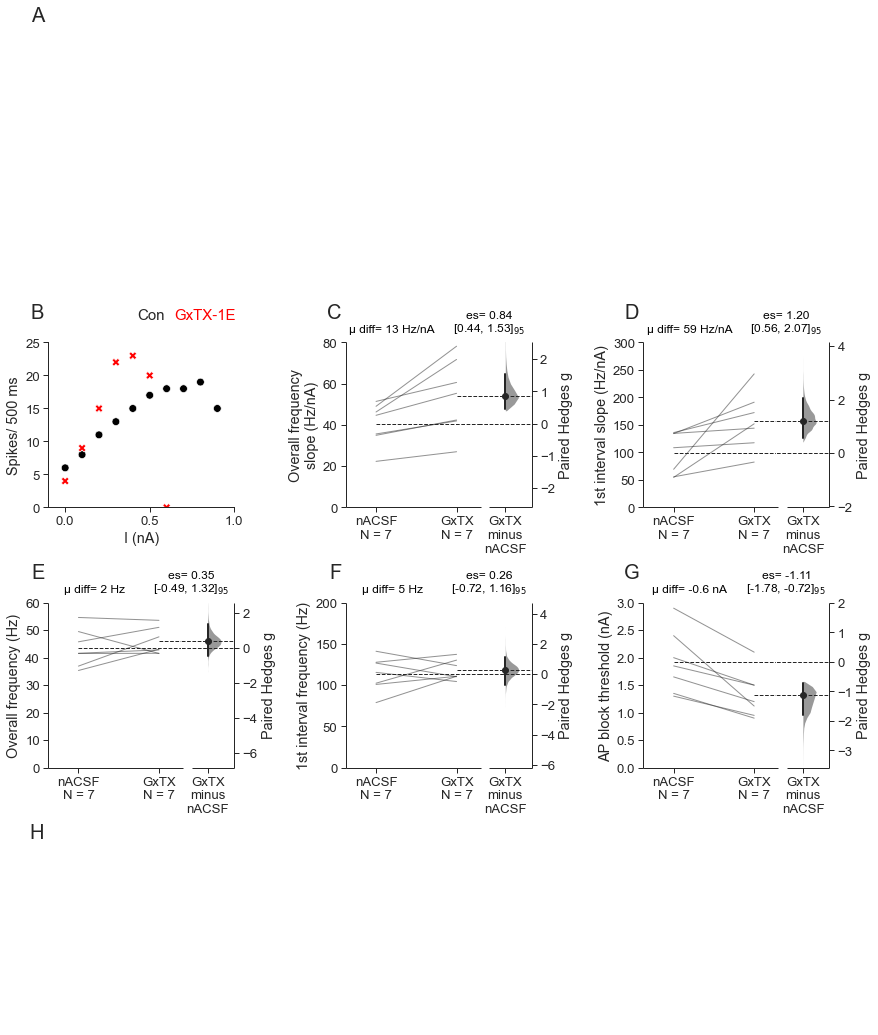

In [142]:
sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.5 ,rc={"lines.linewidth": 1.6})
Example_FI_plots_Cortex = pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_paper_Allfiles_for_jupyterNB\Example_F_I_plots_paper.xlsx",
                         sheet_name='Ex_spikes_AEV3')






f, axx = plt.subplots(nrows=4, ncols=3, figsize=(14,18),gridspec_kw={'wspace': 0.6, 'hspace':0.55, 'height_ratios': [1.2,1,1,1]})
# creating grid for subplots


MeanSlope = dabest.load(Gxtx_WT_Cortical_Mature, idx=("nACSF", "GxTX"),x="rel_cond", y="slope_mean",paired=True, id_col="Cell_ID")
MaxSlope = dabest.load(Gxtx_WT_Cortical_Mature, idx=("nACSF", "GxTX"),x="rel_cond", y="slope_max",paired=True, id_col="Cell_ID")
MeanFrq = dabest.load(Gxtx_WT_Cortical_Mature, idx=("nACSF", "GxTX"),x="rel_cond", y="Mean_FF",paired=True, id_col="Cell_ID")
InitialFrq = dabest.load(Gxtx_WT_Cortical_Mature, idx=("nACSF", "GxTX"),x="rel_cond", y="Max_FF",paired=True, id_col="Cell_ID")
MaxAPs = dabest.load(Gxtx_WT_Cortical_Mature, idx=("nACSF", "GxTX"),x="rel_cond", y="Max_Spikes",paired=True, id_col="Cell_ID")
AP_Block = dabest.load(Gxtx_WT_Cortical_Mature, idx=("nACSF", "GxTX"),x="rel_cond", y="block_thresh_nA",paired=True, id_col="Cell_ID")



ax = axx.flat[3]
ax=Scatter_params_cortex(3, Example_FI_plots_Cortex,"Max spikes","I (nA)","condition",'black','red',0,25,-0.1,1,'condition',60,"Spikes/ 500 ms")


MeanSlope.hedges_g.plot(ax=axx.flat[4],swarm_ylim=(0,80),swarm_label='Overall frequency\nslope (Hz/nA)', es_marker_size=6,
                        contrast_ylim=(-1,1),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
MaxSlope.hedges_g.plot(ax=axx.flat[5],swarm_ylim=(0,300),swarm_label='1st interval slope (Hz/nA)', es_marker_size=6,
                       contrast_ylim=(-1,1),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
MeanFrq.hedges_g.plot(ax=axx.flat[6],swarm_ylim=(0,60),swarm_label='Overall frequency (Hz)', es_marker_size=6,
                      contrast_ylim=(-1,1),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
InitialFrq.hedges_g.plot(ax=axx.flat[7],swarm_ylim=(0,200),swarm_label='1st interval frequency (Hz)', es_marker_size=6,
                         contrast_ylim=(-1,1),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
AP_Block.hedges_g.plot(ax=axx.flat[8],swarm_ylim=(0,3),swarm_label='AP block threshold (nA)', es_marker_size=6,
                       contrast_ylim=(-1,1),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));

Stats_text_paired_onegroup(4,0.2,85,1.4, '\u03BC diff= 13 Hz/nA',"es= 0.84\n[0.44, 1.53]$_{95}$",12,'center','black')
Stats_text_paired_onegroup(5,0.2,318.75,1.4, '\u03BC diff= 59 Hz/nA',"es= 1.20\n[0.56, 2.07]$_{95}$",12,'center','black')
Stats_text_paired_onegroup(6,0.2,63.75,1.4, '\u03BC diff= 2 Hz',"es= 0.35\n[-0.49, 1.32]$_{95}$",12,'center','black')
Stats_text_paired_onegroup(7,0.2,212.5,1.4, '\u03BC diff= 5 Hz',"es= 0.26\n[-0.72, 1.16]$_{95}$",12,'center','black')
#Stats_text_paired_onegroup(4,0.2,31.87,1.4, '\u03BC diff= 4.42',"es= 1.62\n[0.60, 2.59]$_{95}$",12,'center','black')
Stats_text_paired_onegroup(8,0.2,3.187,1.4, '\u03BC diff= -0.6 nA',"es= -1.11\n[-1.78, -0.72]$_{95}$",12,'center','black')


#adding labels
axx.flat[0].annotate('A', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[3].annotate('B', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[3].annotate('Con', xy=(0.5,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=15, va='bottom', ha='left')
axx.flat[3].annotate('GxTX-1E', xy=(0.7,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=15, va='bottom', ha='left',color='red')

axx.flat[4].annotate('C', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[5].annotate('D', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[6].annotate('E', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[7].annotate('F', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[8].annotate('G', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[9].annotate('H', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')


RM_allspines(0) #removing the 1st plot for example traces
RM_allspines(1) #removing the 2nd plot for example traces
RM_allspines(2) #removing the 3rd st plot for example traces
RM_allspines(9) #removing the 3rd st plot for example traces
RM_allspines(10) #removing the 3rd st plot for example traces
RM_allspines(11) #removing the 3rd st plot for example traces

#plt.savefig(r"C:\Users\csmith\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\GXTX_Firing_PYD.svg", dpi=300,bbox_inches='tight')


### Hedges g estimation statistics for cortical neuron firing frequency

Overall frequency slope

In [143]:
pyN_slope_mean_Stats_gxtx=STAT_hedges(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","slope_mean",'mean freq FI',True,"Cell_ID","PyN")


1st interval slope

In [144]:
pyN_slope_max_Stats_gxtx=STAT_hedges(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","slope_max",'initial FI',True,"Cell_ID","PyN")


Overall frequency

In [145]:
pyN_Mean_FF_Stats_gxtx=STAT_hedges(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","Mean_FF",'Peak mean freq',True,"Cell_ID","PyN")


1st interval frequency

In [146]:
pyN_Max_FF_Stats_gxtx=STAT_hedges(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","Max_FF",'Peak init freq',True,"Cell_ID","PyN")


AP block threshold

In [147]:
pyN_block_thresh_nA_Stats_gxtx=STAT_hedges(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","block_thresh_nA",'block thresh nA',True,"Cell_ID","PyN")


In [148]:
#Combining all firing and AP charactaristics into single DF
to_concat=[pyN_slope_mean_Stats_gxtx,pyN_slope_max_Stats_gxtx,pyN_Mean_FF_Stats_gxtx,pyN_Max_FF_Stats_gxtx,pyN_block_thresh_nA_Stats_gxtx]
ALL_pyN_firing_Stats_hedges=pd.concat(to_concat)




### Cortical Neuron Stats Mean DIff for effects of GxTX on firring

Overall frequency slope

In [149]:
pyN_slope_mean_Stats_gxtx_DIFF=STAT_mean(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","slope_mean",'mean freq FI',True,"Cell_ID","PyN")


1st interval frequency slope

In [150]:
pyN_slope_max_Stats_gxtx_DIFF=STAT_mean(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","slope_max",'initial FI',True,"Cell_ID","PyN")


Overall frequency

In [151]:
pyN_Mean_FF_Stats_gxtx_DIFF=STAT_mean(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","Mean_FF",'Peak mean freq',True,"Cell_ID","PyN")


1st interval frequency

In [152]:
pyN_Max_FF_Stats_gxtx_DIFF=STAT_mean(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","Max_FF",'Peak init freq',True,"Cell_ID","PyN")


AP block threshold

In [153]:
pyN_block_thresh_nA_Stats_gxtx_DIFF=STAT_mean(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","block_thresh_nA",'block thresh nA',True,"Cell_ID","PyN")


Combining all firing and AP charactaristics into single DF


In [154]:
to_concat=[pyN_slope_mean_Stats_gxtx_DIFF,pyN_slope_max_Stats_gxtx_DIFF,pyN_Mean_FF_Stats_gxtx_DIFF,pyN_Max_FF_Stats_gxtx_DIFF,pyN_block_thresh_nA_Stats_gxtx_DIFF]
ALL_pyN_firing_Stats_DIFF=pd.concat(to_concat)
ALL_pyN_firing_Stats_DIFF

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,gxtx-1E,7,7,mean difference,True,13.276924,95,7.663957,21.753849,0.0000,0.015625,0.0,0.011773,-3.570755,mean freq FI,PyN
0,nACSF,gxtx-1E,7,7,mean difference,True,58.555889,95,28.001778,113.409435,0.0122,0.015625,0.0,0.039898,-2.614148,initial FI,PyN
0,nACSF,gxtx-1E,7,7,mean difference,True,2.271381,95,-2.280297,6.184831,0.3912,0.375000,8.0,0.369961,-0.969013,Peak mean freq,PyN
0,nACSF,gxtx-1E,7,7,mean difference,True,4.911869,95,-8.743630,20.001611,0.5252,0.812500,12.0,0.549631,-0.633740,Peak init freq,PyN
0,nACSF,gxtx-1E,7,7,mean difference,True,-0.597143,95,-0.967143,-0.435714,0.0000,0.015625,0.0,0.003379,4.684913,block thresh nA,PyN


### 📊 Figure 6- Supplement 1. Comparing the effects of K$_V$2 inhibition with GxTX-1E on cortex pyramidal neuron action potential characteristics in control mice.
Note A is a place holder. 

C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


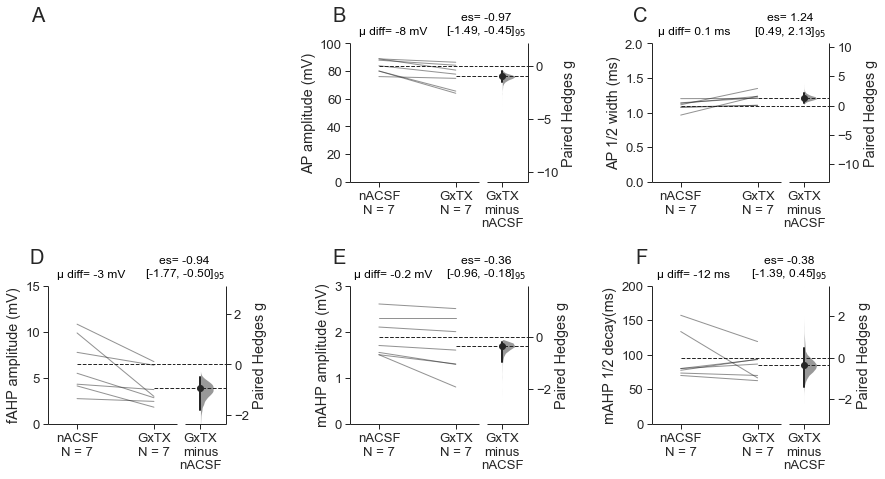

In [155]:
sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.5 ,rc={"lines.linewidth": 1.6})
f, axx = plt.subplots(nrows=2, ncols=3, figsize=(14,7),gridspec_kw={'wspace': 0.7, 'hspace':0.75, 'height_ratios': [1,1]}, sharex=False)

AP_HW = dabest.load(Gxtx_WT_Cortical_Mature, idx=("nACSF", "GxTX"),x="rel_cond", y="AP_HW",paired=True, id_col="Cell_ID")
fAHP = dabest.load(Gxtx_WT_Cortical_Mature, idx=("nACSF", "GxTX"),x="rel_cond", y="fAHP_AMP",paired=True, id_col="Cell_ID")
AP_Amp = dabest.load(Gxtx_WT_Cortical_Mature, idx=("nACSF", "GxTX"),x="rel_cond", y="AP_AMP",paired=True, id_col="Cell_ID")
mAHP_Amp = dabest.load(Gxtx_WT_Cortical_Mature, idx=("nACSF", "GxTX"),x="rel_cond", y="mAHP_AMP",paired=True, id_col="Cell_ID")
mAHP_Duration = dabest.load(Gxtx_WT_Cortical_Mature, idx=("nACSF", "GxTX"),x="rel_cond", y="mAHP_half_Duration",paired=True, id_col="Cell_ID")



AP_Amp.hedges_g.plot(ax=axx.flat[1],swarm_ylim=(0,100),swarm_label='AP amplitude (mV)', es_marker_size=6,
                     contrast_ylim=(-1,1),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
AP_HW.hedges_g.plot(ax=axx.flat[2],swarm_ylim=(0,2),swarm_label='AP 1/2 width (ms)', es_marker_size=6,
                    contrast_ylim=(-1,1),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
fAHP.hedges_g.plot(ax=axx.flat[3],swarm_ylim=(0,15),swarm_label='fAHP amplitude (mV)', es_marker_size=6,
                   contrast_ylim=(-1,1),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
mAHP_Amp.hedges_g.plot(ax=axx.flat[4],swarm_ylim=(0,3),swarm_label='mAHP amplitude (mV)', es_marker_size=6
                       , contrast_ylim=(-3,3),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
mAHP_Duration.hedges_g.plot(ax=axx.flat[5],swarm_ylim=(0,200),swarm_label='mAHP 1/2 decay(ms)', es_marker_size=6,
                            contrast_ylim=(-1,1),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));



Stats_text_paired_onegroup(1,0.18,106.25,1.4, '\u03BC diff= -8 mV',"es= -0.97\n[-1.49, -0.45]$_{95}$",12,'center','black')
Stats_text_paired_onegroup(2,0.17,2.124,1.42, '\u03BC diff= 0.1 ms',"es= 1.24\n[0.49, 2.13]$_{95}$",12,'center','black')
Stats_text_paired_onegroup(3,0.18,15.93,1.4, '\u03BC diff= -3 mV',"es= -0.94\n[-1.77, -0.50]$_{95}$",12,'center','black')
Stats_text_paired_onegroup(4,0.18,3.18,1.4, '\u03BC diff= -0.2 mV',"es= -0.36\n[-0.96, -0.18]$_{95}$",12,'center','black')
Stats_text_paired_onegroup(5,0.17,212.5,1.41, '\u03BC diff= -12 ms',"es= -0.38\n[-1.39, 0.45]$_{95}$",12,'center','black')

axx.flat[0].annotate('A', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[1].annotate('B', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[2].annotate('C', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[3].annotate('D', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[4].annotate('E', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[5].annotate('F', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')

RM_allspines(0) #removing the 1st plot for example traces

#plt.savefig(r"C:\Users\csmith\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\GXTX_Firing_PYD_APS.svg", dpi=300,bbox_inches='tight')



## Cortical Neuron Stats: Hedges G for effects of GxTX on AP characteristics


AP 1/2 width

In [156]:
pyN_AP_HW_Stats_gxtx=STAT_hedges(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","AP_HW",'AP HW',True,"Cell_ID","PyN")


fAHP amplitude

In [157]:
pyN_fAHP_Stats_gxtx=STAT_hedges(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","fAHP_AMP",'fAHP amp',True,"Cell_ID","PyN")


AP amplitude

In [158]:
pyN_AP_AMP_AMP_Stats_gxtx=STAT_hedges(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","AP_AMP",'AP amp',True,"Cell_ID","PyN")


mAHP amplitude

In [159]:
pyN_mAHP_AMP_Stats_gxtx=STAT_hedges(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","mAHP_AMP",'mAHP amp',True,"Cell_ID","PyN")


mAHP 1/2 duration 

In [160]:
pyN_mAHP_half_Duration_Stats_gxtx=STAT_hedges(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","mAHP_half_Duration",'mAHP half duration',True,"Cell_ID","PyN")


AP 1/2 width at 3 X

In [161]:
pyN_Mean_AP_3x_thresh_Stats_gxtx_hedges=STAT_hedges(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","Mean_AP_3x_thresh",'Mean AP HW 3T',True,"Cell_ID","PyN")


C:\Users\Calvi\anaconda3\lib\site-packages\dabest\_classes.py:774: UserWarning: The lower limit of the interval was in the bottom 10 values. The result should be considered unstable.
  warnings.warn(err_temp.substitute(lim_type="lower",


Trough potential at 3X

In [162]:
pyN_Mean_trough_3x_thresh_Stats_gxtx_hedges=STAT_hedges(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","Mean_trough_3x_thresh",'Mean trough amp 3T',True,"Cell_ID","PyN")


AP amplitude at 3 X

In [163]:
pyN_Apamp_mean_Stats_gxtx_hedges=STAT_hedges(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","Apamp_mean",'mean AP amp 3T',True,"Cell_ID","PyN")


In [164]:
#Combining all firing and AP charactaristics into single DF
to_concat=[pyN_AP_HW_Stats_gxtx,pyN_fAHP_Stats_gxtx,pyN_AP_AMP_AMP_Stats_gxtx,pyN_mAHP_AMP_Stats_gxtx,pyN_mAHP_half_Duration_Stats_gxtx,
           pyN_Mean_AP_3x_thresh_Stats_gxtx_hedges,pyN_Mean_trough_3x_thresh_Stats_gxtx_hedges,pyN_Apamp_mean_Stats_gxtx_hedges]
ALL_pyN_AP_Stats=pd.concat(to_concat)
ALL_pyN_AP_Stats



,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,gxtx-1E,7,7,Hedges' g,True,1.246747,95,0.499760,2.137975,0.0000,0.015625,0.0,0.040552,-2.602031,AP HW,PyN
0,nACSF,gxtx-1E,7,7,Hedges' g,True,-0.942421,95,-1.777121,-0.500499,0.0000,0.015625,0.0,0.023771,3.007688,fAHP amp,PyN
0,nACSF,gxtx-1E,7,7,Hedges' g,True,-0.976977,95,-1.495799,-0.457393,0.0000,0.015625,0.0,0.014817,3.382248,AP amp,PyN
0,nACSF,gxtx-1E,7,7,Hedges' g,True,-0.366279,95,-0.966720,-0.188814,0.0000,0.027708,0.0,0.054914,2.378048,mAHP amp,PyN
0,nACSF,gxtx-1E,7,7,Hedges' g,True,-0.381948,95,-1.393066,0.450502,0.4134,0.687500,11.0,0.355455,1.001037,mAHP half duration,PyN
0,nACSF,gxtx-1E,7,7,Hedges' g,True,1.071911,95,0.516364,1.695062,0.0106,0.031250,1.0,0.041896,-2.577745,Mean AP HW 3T,PyN
0,nACSF,gxtx-1E,7,7,Hedges' g,True,-1.198552,95,-2.403073,-0.079372,0.0340,0.046875,2.0,0.029276,2.847549,Mean trough amp 3T,PyN
0,nACSF,gxtx-1E,7,7,Hedges' g,True,-1.756041,95,-2.789357,-1.055464,0.0122,0.015625,0.0,0.010226,3.688570,mean AP amp 3T,PyN


## Cortical Neuron Mean Diff Stats for effects of GxTX on AP characteristics

AP 1/2 width

In [165]:
pyN_AP_HW_Stats_gxtx_DIFF=STAT_mean(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","AP_HW",'AP HW',True,"Cell_ID","PyN")


fAHP amplitude

In [166]:
pyN_fAHP_Stats_gxtx_DIFF=STAT_mean(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","fAHP_AMP",'fAHP amp',True,"Cell_ID","PyN")


AP amplitude

In [167]:
pyN_AP_AMP_AMP_Stats_gxtx_DIFF=STAT_mean(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","AP_AMP",'AP amp',True,"Cell_ID","PyN")


mAHP amplitude

In [168]:
pyN_mAHP_AMP_Stats_gxtx_DIFF=STAT_mean(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","mAHP_AMP",'mAHP amp',True,"Cell_ID","PyN")


C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


mAHP 1/2 duration

In [169]:
pyN_mAHP_half_Duration_Stats_gxtx_DIFF=STAT_mean(Gxtx_WT_Cortical_Mature,"nACSF", "gxtx-1E","condition","mAHP_half_Duration",'mAHP half duration',True,"Cell_ID","PyN")


In [170]:
#Combining all firing and AP charactaristics into single DF
to_concat=[pyN_AP_HW_Stats_gxtx_DIFF,pyN_fAHP_Stats_gxtx_DIFF,pyN_AP_AMP_AMP_Stats_gxtx_DIFF,pyN_mAHP_AMP_Stats_gxtx_DIFF,pyN_mAHP_half_Duration_Stats_gxtx_DIFF]
ALL_pyN_AP_Stats_DIFF=pd.concat(to_concat)
ALL_pyN_AP_Stats_DIFF

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,gxtx-1E,7,7,mean difference,True,0.105750,95,0.040718,0.191964,0.0000,0.015625,0.0,0.040552,-2.602031,AP HW,PyN
0,nACSF,gxtx-1E,7,7,mean difference,True,-2.595664,95,-4.590068,-1.357826,0.0000,0.015625,0.0,0.023771,3.007688,fAHP amp,PyN
0,nACSF,gxtx-1E,7,7,mean difference,True,-7.459430,95,-12.045574,-3.971033,0.0000,0.015625,0.0,0.014817,3.382248,AP amp,PyN
0,nACSF,gxtx-1E,7,7,mean difference,True,-0.208571,95,-0.465714,-0.100000,0.0000,0.027708,0.0,0.054914,2.378048,mAHP amp,PyN
0,nACSF,gxtx-1E,7,7,mean difference,True,-11.500000,95,-38.214286,4.714286,0.4134,0.687500,11.0,0.355455,1.001037,mAHP half duration,PyN


Combining stats data frames for control, KO MNs and pyramidal neurons

In [171]:
ALL_Control_effect_sizes=pd.concat([ALL_MN_Mat_Con_firing_Stats_Hedges, ALL_MN_Mat_Con_AP_Stats_GXTX_Hedges])
ALL_KO_effect_sizes=pd.concat([ALL_KO_MN_Mat_Con_firing_Stats_HedgesG, ALL_MN_Mat_KO_AP_Stats_GXTX_Hedges])
ALL_PYN_effect_sizes=pd.concat([ALL_pyN_firing_Stats_hedges, ALL_pyN_AP_Stats])


In [172]:
ALL_PYN_effect_sizes

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,gxtx-1E,7,7,Hedges' g,True,0.847207,95,0.444481,1.533519,0.0000,0.015625,0.0,0.011773,-3.570755,mean freq FI,PyN
0,nACSF,gxtx-1E,7,7,Hedges' g,True,1.205741,95,0.562804,2.074996,0.0000,0.015625,0.0,0.039898,-2.614148,initial FI,PyN
0,nACSF,gxtx-1E,7,7,Hedges' g,True,0.357033,95,-0.492725,1.329033,0.3912,0.375000,8.0,0.369961,-0.969013,Peak mean freq,PyN
0,nACSF,gxtx-1E,7,7,Hedges' g,True,0.267753,95,-0.729493,1.167228,0.5252,0.812500,12.0,0.549631,-0.633740,Peak init freq,PyN
0,nACSF,gxtx-1E,7,7,Hedges' g,True,-1.113143,95,-1.784753,-0.720313,0.0000,0.015625,0.0,0.003379,4.684913,block thresh nA,PyN
0,nACSF,gxtx-1E,7,7,Hedges' g,True,1.246747,95,0.499760,2.137975,0.0000,0.015625,0.0,0.040552,-2.602031,AP HW,PyN
0,nACSF,gxtx-1E,7,7,Hedges' g,True,-0.942421,95,-1.777121,-0.500499,0.0000,0.015625,0.0,0.023771,3.007688,fAHP amp,PyN
0,nACSF,gxtx-1E,7,7,Hedges' g,True,-0.976977,95,-1.495799,-0.457393,0.0000,0.015625,0.0,0.014817,3.382248,AP amp,PyN
0,nACSF,gxtx-1E,7,7,Hedges' g,True,-0.366279,95,-0.966720,-0.188814,0.0000,0.027708,0.0,0.054914,2.378048,mAHP amp,PyN
0,nACSF,gxtx-1E,7,7,Hedges' g,True,-0.381948,95,-1.393066,0.450502,0.4134,0.687500,11.0,0.355455,1.001037,mAHP half duration,PyN


In [173]:
ALL_ALL_firing_Stats=pd.concat([ALL_Control_effect_sizes, ALL_KO_effect_sizes, ALL_PYN_effect_sizes])
ALL_ALL_firing_Stats_sorted = ALL_ALL_firing_Stats.sort_values(by='difference',ascending=True)

### Panel for figure 6 comparing differences in effect sizes

([<matplotlib.axis.XTick at 0x24b6ec46040>,
 [Text(0.5, 0, 'Control\nMotoneuron'),
  Text(1.5, 0, 'Layer 5\nPyramidal Neuron'),
  Text(2.5, 0, 'ChAT-K$_V$2.1$^{OFF}$\nMotoneuron')])

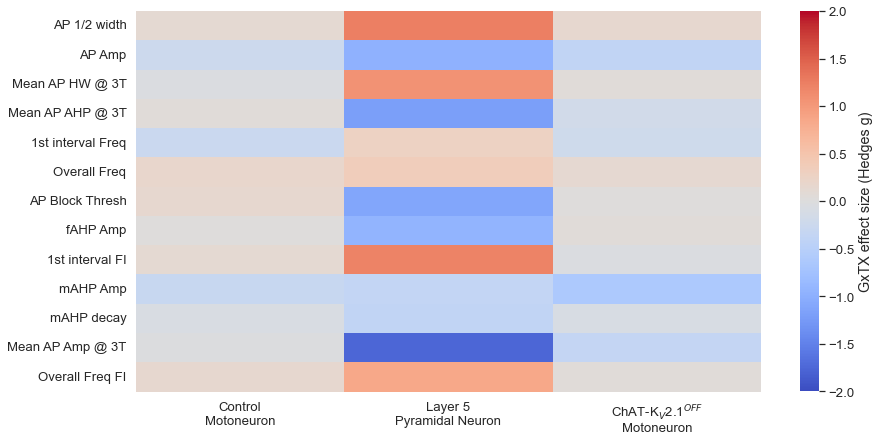

In [174]:


sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(14,7))
labels=['Control\nMotoneuron', 'Layer 5\nPyramidal Neuron', 'ChAT-K$_V$2.1$^{OFF}$\nMotoneuron']
pyNplot = ALL_ALL_firing_Stats.pivot( "parameter","group", "difference")
ax = sns.heatmap(pyNplot,cmap="coolwarm",vmin=-2, vmax=2,cbar_kws={'label': 'GxTX effect size (Hedges g)'},yticklabels=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set(xlabel=(''))
ax.set(ylabel=(''))
ax.set_yticklabels(('AP 1/2 width', 'AP Amp','Mean AP HW @ 3T','Mean AP AHP @ 3T',
                   '1st interval Freq','Overall Freq', 'AP Block Thresh', 'fAHP Amp', '1st interval FI', 'mAHP Amp',
                    'mAHP decay', 'Mean AP Amp @ 3T', 'Overall Freq FI'))
#plt.xticks(rotation=20)
plt.xticks([0.5,1.5,2.5], labels, rotation=0, ha='center')
#plt.savefig(r"C:\Users\csmith\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\GXTX_Firing_Jun_21_Effectsize.svg", dpi=300,bbox_inches='tight')




### Developmental clustering of K$_V$2.1 channels does not reduce their contribution to motoneuron firing.

#### Importing anatomy data

In [175]:
%matplotlib inline
sheet="Sheet4"
KV2_dev= pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_paper_Allfiles_for_jupyterNB\VAChT_Kv2.1_Shireen_final.xlsx", sheet_name=sheet) #importing sheet2 from excel file.
KV2_dev1=KV2_dev[KV2_dev.loc[:]!=0].dropna()# dropping Kv2.1 negative cells



#### Normalising data and changing units/labels for plotting


In [176]:
#normalising and changing units
KV2_dev1['VaCHTnorm'] = KV2_dev1['no VAChT'] / KV2_dev1['Cell Area']
KV2_dev1['kv2spot/100um'] = (KV2_dev1['Kv2.1 spots'] / KV2_dev1['Cell Area'])*100
KV2_dev1['Kv2.1_area'] = KV2_dev1['Kv2.1_area'] *100

In [177]:
# changing column names for the graphs 
KV2_dev1=KV2_dev1.rename(columns={'Cell Area':'Cell Area (\u03BCm$^2$)', 'Kv2.1_area':'No Kv2.1/100 \u03BCm$^2$', 'Vacht_area':'No VAChT punta/100 \u03BCm$^2$','percent_Kv2_Coloc':'% Kv2.1 colocalised to VAChT'})



Separating lumbar and cervical from data frame-Only used lumbar in this study


In [178]:
lumbar_only=KV2_dev1[KV2_dev1.neuraxis == "Lumbar"]

Defining scatter plot parameters (note that these are different to the same function defined earlier)

In [179]:
def Scatter_params_1group(Dat,y,x,YLIM1,YLIM2,XLIM1,XLIM2,XLAB,YLAB,Clr,num,alph,linecol,lw):
    sns.regplot(data=Dat,y=y,x=x, color=Clr,n_boot=1000, ci=95,robust=True,x_jitter=1,
                scatter_kws={"s": 30,'alpha':alph,'fc':'none', 'ec':'black','linewidth':0.5},line_kws={'lw': lw, 'color': linecol})
    sns.despine(trim=False)
    plt.legend([],[], frameon=False)
    num.set_ylim(YLIM1,YLIM2)
    num.set_xlim(XLIM1,XLIM2)
    num.set(xlabel=(XLAB))
    num.set(ylabel=(YLAB))


Function to calculate spearman's correlation


In [180]:
def spearman(Data,x,y):
    coef, p = spearmanr(Data[x], Data[y],nan_policy='omit')
    print('Spearmans correlation coefficient: %.3f' % coef)
    # interpret the significance
    alpha = 0.05
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.50f' % p)

Spearmans correlations for immunos lumbar only


In [181]:
##Vacht
print('Vacht density')
spearman(lumbar_only,'Age','No VAChT punta/100 \u03BCm$^2$')
##Kv density
print('Kv density')
spearman(lumbar_only,'Age','No Kv2.1/100 μm$^2$')
##Kv coloc
print('percent Kv2.1 Coloc')
spearman(lumbar_only,'Age','percent Kv2.1 Coloc')

Vacht density
Spearmans correlation coefficient: 0.490
Samples are correlated (reject H0) p=0.00000000122472499446052697581827419930381936619135
Kv density
Spearmans correlation coefficient: -0.173
Samples are correlated (reject H0) p=0.04277693871192882191234474476004834286868572235107
percent Kv2.1 Coloc
Spearmans correlation coefficient: 0.733
Samples are correlated (reject H0) p=0.00000000000000000000000238935327268641337230207502


Importing data for P3 and P21 distance/intensity plots


In [182]:
KV2_dev_intensity_plots_P3= pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_paper_Allfiles_for_jupyterNB\Kv2.1_dev_intensity_plots.xlsx", sheet_name="Sheet1") #importing sheet2 from excel file.
#importing data for P21 distance/intensity plots
KV2_dev_intensity_plots_P21= pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_paper_Allfiles_for_jupyterNB\Kv2.1_dev_intensity_plots.xlsx", sheet_name="Sheet2") #importing sheet2 from excel file.


Setting style for line plots


In [183]:
def line_plots(Dat,y,x,hue,pal,pal1,alph,num,text_pos1,text_pos2,TIT,YLIM1,YLIM2, protein1,protein2):
    sns.lineplot(data=Dat,y=y,x=x,hue=hue,palette=(pal,pal1),alpha=alph)
    sns.despine(trim=False)
    plt.legend([],[], frameon=False)
    plt.text(text_pos1, 1, protein1,fontsize=12,color="0.1")
    plt.text(text_pos2, 1, protein2,fontsize=12,color="red")
    num.set(xlabel=('Normalised Distance'))
    num.set(ylabel=('Intensity'))
    plt.xticks([], [])
    num.set_ylim(0,1)
    plt.title(TIT)
    num.set_ylim(YLIM1,YLIM2)

Creating developmental DF, with __only Control motoneurons__ that were used in __GXTX experiments__


In [184]:
Dev_seek=ALL_with_Perc_change.drop(ALL_with_Perc_change[(ALL_with_Perc_change['genotype'] == "cKO")].index)
Dev_seek=Dev_seek.drop(Dev_seek[(Dev_seek['celltype'] == "Cortical_L5_Pyramidal")].index)
Dev_seek=Dev_seek.drop(Dev_seek[(Dev_seek['Compound'] != "gxtx-1E")].index)



In [185]:
Dev_seek_young=Dev_seek.drop(Dev_seek[(Dev_seek['agegroup'] == 'P13plus')].index)
Dev_seek_mature=Dev_seek.drop(Dev_seek[(Dev_seek['agegroup'] == 'P7less')].index)

Adding new label column for proper labeling of graphs


In [186]:
Dev_seek_young['rel_cond']= np.where(Dev_seek_young['condition']=='nACSF', 'Pre$_{<P7}$', "GxTX")
#creating new column to match with the KO DF
Dev_seek_mature=Gxtx_WT_Mature
Dev_seek_mature['rel_cond']= np.where(Dev_seek_mature['condition']=='nACSF', 'Pre $_{P13+}$', "GxTX ")

# combining Dfs
Dev_seek_combine=pd.concat([Dev_seek_young, Dev_seek_mature])

### Young MN Hedges G estimation statistics

Overall frequency slope

In [187]:
YOUNG_slope_mean_Stats_gxtx=STAT_hedges(Dev_seek_young,"nACSF", "gxtx-1E","condition","slope_mean",'mean freq FI',True,"Cell_ID","Con MN (mature)")


1st interval frequency slope

In [188]:
YOUNG_slope_max_Stats_gxtx=STAT_hedges(Dev_seek_young,"nACSF", "gxtx-1E","condition","slope_max",'initial FI',True,"Cell_ID","Con MN (mature)")


Overall frequency

In [189]:
YOUNG_Mean_FF_Stats_gxtx=STAT_hedges(Dev_seek_young,"nACSF", "gxtx-1E","condition","Mean_FF",'Peak mean freq',True,"Cell_ID","Con MN (mature)")


1st interval frequency

In [190]:
YOUNG_Max_FF_Stats_gxtx=STAT_hedges(Dev_seek_young,"nACSF", "gxtx-1E","condition","Max_FF",'Peak init freq',True,"Cell_ID","Con MN (mature)")


AP 1/2 width 

In [ ]:
YOUNG_AP_HW_Stats_gxtx=STAT_hedges(Dev_seek_young,"nACSF", "gxtx-1E","condition","AP_HW",'AP HW',True,"Cell_ID","Con MN (mature)")


fAHP amplitude 

In [191]:
YOUNG_fAHP_Stats_gxtx=STAT_hedges(Dev_seek_young,"nACSF", "gxtx-1E","condition","fAHP_AMP",'fAHP amp',True,"Cell_ID","Con MN (mature)")


Combining stats

In [192]:
ALL_YOUNG_firing_Hedges_Stats=pd.concat([YOUNG_slope_mean_Stats_gxtx,YOUNG_slope_max_Stats_gxtx,YOUNG_Mean_FF_Stats_gxtx,YOUNG_Max_FF_Stats_gxtx,YOUNG_fAHP_Stats_gxtx])
ALL_YOUNG_firing_Hedges_Stats

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,gxtx-1E,18,18,Hedges' g,True,-0.089881,95,-0.272998,0.143227,0.3218,0.442299,67.0,0.347321,0.966545,mean freq FI,Con MN (mature)
0,nACSF,gxtx-1E,18,18,Hedges' g,True,-0.243800,95,-0.431624,0.021305,0.0364,0.012032,29.0,0.034841,2.293432,initial FI,Con MN (mature)
0,nACSF,gxtx-1E,18,18,Hedges' g,True,-0.081019,95,-0.349475,0.204230,0.5222,0.550873,71.0,0.525415,0.648358,Peak mean freq,Con MN (mature)
0,nACSF,gxtx-1E,18,18,Hedges' g,True,-0.352438,95,-0.687981,-0.075978,0.0176,0.034233,37.0,0.016451,2.661263,Peak init freq,Con MN (mature)
0,nACSF,gxtx-1E,14,14,Hedges' g,True,-0.187214,95,-0.896350,0.233328,0.6308,0.625732,44.0,0.521203,0.659314,fAHP amp,Con MN (mature)


### Young motoneuron mean differnces

Overall frequency slope

In [193]:
YOUNG_slope_mean_Stats_gxtx_DIFF=STAT_mean(Dev_seek_young,"nACSF", "gxtx-1E","condition","slope_mean",'mean freq FI',True,"Cell_ID","Con MN (mature)")


1st interval frequency slope

In [194]:
YOUNG_slope_max_Stats_gxtx_DIFF=STAT_mean(Dev_seek_young,"nACSF", "gxtx-1E","condition","slope_max",'initial FI',True,"Cell_ID","Con MN (mature)")


Overall frequency

In [195]:
YOUNG_Mean_FF_Stats_gxtx_DIFF=STAT_mean(Dev_seek_young,"nACSF", "gxtx-1E","condition","Mean_FF",'Peak mean freq',True,"Cell_ID","Con MN (mature)")


1st interval frequency

In [196]:
YOUNG_Max_FF_Stats_gxtx_DIFF=STAT_mean(Dev_seek_young,"nACSF", "gxtx-1E","condition","Max_FF",'Peak init freq',True,"Cell_ID","Con MN (mature)")


AP 1/2 width

In [197]:
YOUNG_AP_HW_Stats_gxtx_DIFF=STAT_mean(Dev_seek_young,"nACSF", "gxtx-1E","condition","AP_HW",'AP HW',True,"Cell_ID","Con MN (mature)")


fAHP amplitude

In [198]:
YOUNG_fAHP_Stats_gxtx_DIFF=STAT_mean(Dev_seek_young,"nACSF", "gxtx-1E","condition","fAHP_AMP",'fAHP amp',True,"Cell_ID","Con MN (mature)")


In [199]:
ALL_YOUNG_firing_Stats_MeanDIffs=pd.concat([YOUNG_slope_mean_Stats_gxtx_DIFF,YOUNG_slope_max_Stats_gxtx_DIFF,YOUNG_Mean_FF_Stats_gxtx_DIFF,YOUNG_Max_FF_Stats_gxtx_DIFF,
                                  YOUNG_AP_HW_Stats_gxtx_DIFF,YOUNG_fAHP_Stats_gxtx_DIFF])
ALL_YOUNG_firing_Stats_MeanDIffs

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,gxtx-1E,18,18,mean difference,True,-1.345919,95,-3.855508,1.521415,0.3218,0.442299,67.0,0.347321,0.966545,mean freq FI,Con MN (mature)
0,nACSF,gxtx-1E,18,18,mean difference,True,-10.456588,95,-18.503055,-0.961542,0.0364,0.012032,29.0,0.034841,2.293432,initial FI,Con MN (mature)
0,nACSF,gxtx-1E,18,18,mean difference,True,-0.701357,95,-2.591328,1.619364,0.5222,0.550873,71.0,0.525415,0.648358,Peak mean freq,Con MN (mature)
0,nACSF,gxtx-1E,18,18,mean difference,True,-9.290484,95,-16.310535,-3.198547,0.0176,0.034233,37.0,0.016451,2.661263,Peak init freq,Con MN (mature)
0,nACSF,gxtx-1E,16,16,mean difference,True,0.101625,95,0.047445,0.181128,0.0024,0.002686,13.0,0.010402,-2.927314,AP HW,Con MN (mature)
0,nACSF,gxtx-1E,14,14,mean difference,True,-0.829788,95,-4.229268,0.817890,0.6308,0.625732,44.0,0.521203,0.659314,fAHP amp,Con MN (mature)


### 📊 Figure 7. Developmental clustering of KV2.1 channels does not reduce their contribution to motoneuron firing. 

Text(-4, 4, 'L')

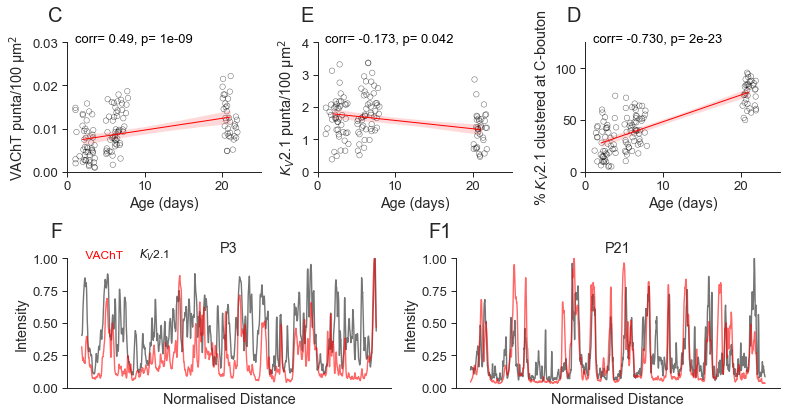

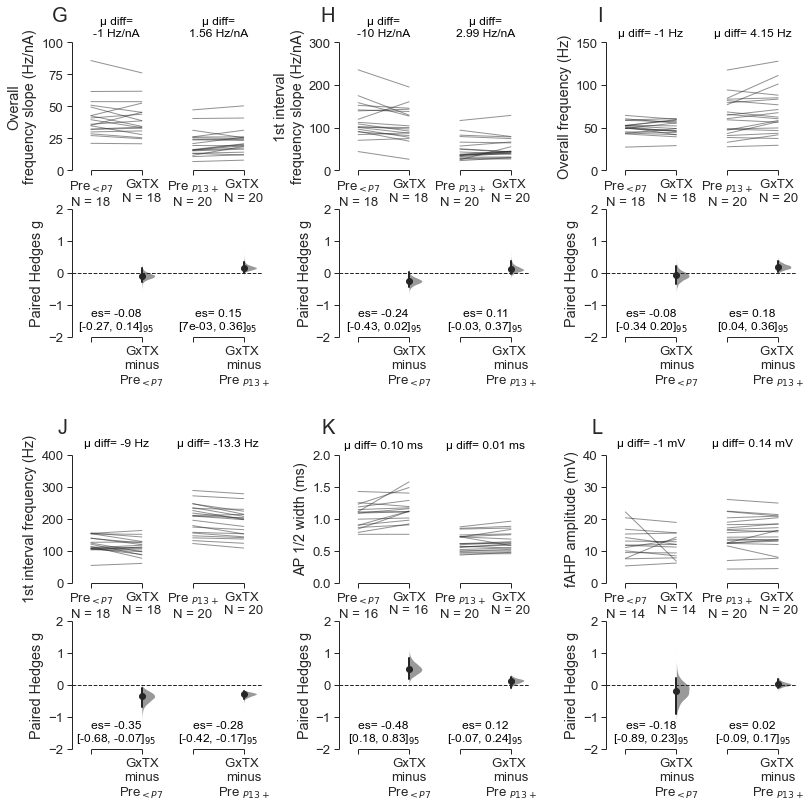

In [200]:
## vacht puncta  ###
sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.5 ,rc={"lines.linewidth": 1.4})


ax0 = plt.axes([-1.2,0.8, 0.45, 0.45])
Scatter_params_1group(lumbar_only,"No VAChT punta/100 \u03BCm$^2$","Age",
                      0,0.03,0,25,"Age (days)",'VAChT punta/100 \u03BCm$^2$',"grey",ax0,0.6, 'red',1)
plt.text(1, 0.03, 'corr= 0.49, p= 1e-09',fontsize=13,color="black")
## Kv2 puncta  ###
ax1a = plt.axes([-0.62,0.8, 0.45, 0.45])
Scatter_params_1group(lumbar_only,"No Kv2.1/100 μm$^2$","Age",
                      0,4,0,25,"Age (days)",'$K_{V}$2.1 punta/100 \u03BCm$^2$',"grey",ax1a,0.6, 'red',1)
plt.text(1, 4, 'corr= -0.173, p= 0.042',fontsize=13,color="black")

## kv2 coloc  ###
ax1b = plt.axes([0,0.8, 0.45, 0.45])
Scatter_params_1group(lumbar_only,"percent Kv2.1 Coloc","Age",
                      0,125,0,25,"Age (days)",'% $K_{V}$2.1 clustered at C-bouton',"grey",ax1b,0.6, 'red',1)
plt.text(1, 125, 'corr= -0.730, p= 2e-23',fontsize=13,color="black")


####line intensity plots########
ax6= plt.axes([-1.2,0.05, 0.75, 0.45])
line_plots(KV2_dev_intensity_plots_P3,"Intensity","x","Protein","0.1","red",0.6,ax6,300,1,"P3",0,1, '$K_{V}$2.1',' VAChT')

ax7= plt.axes([-0.3,0.05, 0.75, 0.45])
line_plots(KV2_dev_intensity_plots_P21,"Intensity","x","Protein","0.1","red",0.6,ax7,400,1,"P21",0,1,'','')


#plt.savefig(r"C:\Users\csmith\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\GXTX_Dev_corrs.png", dpi=300,bbox_inches='tight')

f, axx = plt.subplots(nrows=2, ncols=3, figsize=(13,13),gridspec_kw={'wspace': 0.4, 'hspace':0.4})

Mean_FI = dabest.load(Dev_seek_combine, idx=(('Pre$_{<P7}$', "GxTX"),('Pre $_{P13+}$', "GxTX ")),
                      x="rel_cond", y="slope_mean",paired=True, id_col="Cell_ID")
intial_FI = dabest.load(Dev_seek_combine, idx=(('Pre$_{<P7}$', "GxTX"),('Pre $_{P13+}$', "GxTX ")),
                      x="rel_cond", y="slope_max",paired=True, id_col="Cell_ID")
Mean_max = dabest.load(Dev_seek_combine, idx=(('Pre$_{<P7}$', "GxTX"),('Pre $_{P13+}$', "GxTX ")),
                      x="rel_cond", y="Mean_FF",paired=True, id_col="Cell_ID")
Initial_max = dabest.load(Dev_seek_combine, idx=(('Pre$_{<P7}$', "GxTX"),('Pre $_{P13+}$', "GxTX ")),
                      x="rel_cond", y="Max_FF",paired=True, id_col="Cell_ID")
AP_HW = dabest.load(Dev_seek_combine, idx=(('Pre$_{<P7}$', "GxTX"),('Pre $_{P13+}$', "GxTX ")),
                      x="rel_cond", y="AP_HW",paired=True, id_col="Cell_ID") 
fAHP = dabest.load(Dev_seek_combine, idx=(('Pre$_{<P7}$', "GxTX"),('Pre $_{P13+}$', "GxTX ")),
                      x="rel_cond", y="fAHP_AMP",paired=True, id_col="Cell_ID") 
   
    
Mean_FI.hedges_g.plot(ax=axx.flat[0],swarm_ylim=(0,100),swarm_label='Overall\nfrequency slope (Hz/nA)', 
                      es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
intial_FI.hedges_g.plot(ax=axx.flat[1],swarm_ylim=(0,300),swarm_label='1st interval\nfrequency slope (Hz/nA)',
                       es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
Mean_max.hedges_g.plot(ax=axx.flat[2],swarm_ylim=(0,150),swarm_label='Overall frequency (Hz)', 
                      es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
Initial_max.hedges_g.plot(ax=axx.flat[3],swarm_ylim=(0,400),swarm_label='1st interval frequency (Hz)', 
                         es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
AP_HW.hedges_g.plot(ax=axx.flat[4],swarm_ylim=(0,2),swarm_label='AP 1/2 width (ms)', 
                         es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
fAHP.hedges_g.plot(ax=axx.flat[5],swarm_ylim=(0,40),swarm_label='fAHP amplitude (mV)', 
                         es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));

###Adding text with mean differences and ES values
#text for hedges g plot always 43.75% lower that diff
#MeanSlope
Stats_text_paired(0,0.5,2.5, 105, -125,'\u03BC diff=\n-1 Hz/nA','\u03BC diff=\n1.56 Hz/nA', "es= -0.08\n[-0.27, 0.14]$_{95}$", "es= 0.15\n[7e-03, 0.36]$_{95}$",12,'center','black')
#MaxSlope
Stats_text_paired(1,0.5,2.5, 315, -375,'\u03BC diff=\n-10 Hz/nA','\u03BC diff=\n2.99 Hz/nA', "es= -0.24\n[-0.43, 0.02]$_{95}$", "es= 0.11\n[-0.03, 0.37]$_{95}$",12,'center','black')
#mean frequency
Stats_text_paired(2,0.5,2.5, 157.5, -187.5,'\u03BC diff= -1 Hz','\u03BC diff= 4.15 Hz', "es= -0.08\n[-0.34 0.20]$_{95}$", "es= 0.18\n[0.04, 0.36]$_{95}$",12,'center','black')

#initial freq
Stats_text_paired(3,0.5,2.5, 425, -500,'\u03BC diff= -9 Hz','\u03BC diff= -13.3 Hz', "es= -0.35\n[-0.68, -0.07]$_{95}$", "es= -0.28\n[-0.42, -0.17]$_{95}$",12,'center','black')
#HW

Stats_text_paired(4,0.5,2.5, 2.1, -2.5,'\u03BC diff= 0.10 ms','\u03BC diff= 0.01 ms', "es= -0.48\n[0.18, 0.83]$_{95}$", "es= 0.12\n[-0.07, 0.24]$_{95}$",12,'center','black')
#fAHP

Stats_text_paired(5,0.5,2.5, 42.5, -50,'\u03BC diff= -1 mV','\u03BC diff= 0.14 mV', "es= -0.18\n[-0.89, 0.23]$_{95}$", "es= 0.02\n[-0.09, 0.17]$_{95}$",12,'center','black')

#adding labels

ax0.annotate('C', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
ax1b.annotate('D', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
ax1a.annotate('E', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
ax6.annotate('F', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
ax7.annotate('F1', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[0].annotate('G', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[1].annotate('H', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[2].annotate('I', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[3].annotate('J', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[4].annotate('K', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[5].annotate('L', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')



Scatter and line graphs for exporting to excel

Text(-4, 4, 'F1')

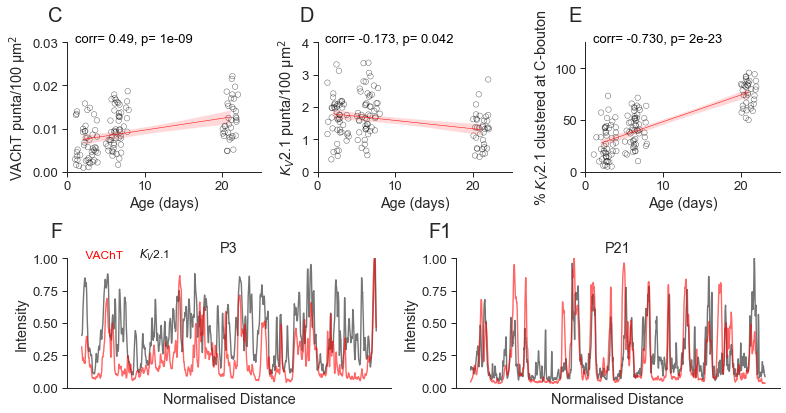

In [201]:
## vacht puncta  ###
sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.5 ,rc={"lines.linewidth": 1.4})


ax0 = plt.axes([-1.2,0.8, 0.45, 0.45])
Scatter_params_1group(lumbar_only,"No VAChT punta/100 \u03BCm$^2$","Age",
                      0,0.03,0,25,"Age (days)",'VAChT punta/100 \u03BCm$^2$',"grey",ax0,0.6, 'red',0.5)
plt.text(1, 0.03, 'corr= 0.49, p= 1e-09',fontsize=13,color="black")
## Kv2 puncta  ###
ax1a = plt.axes([-0.62,0.8, 0.45, 0.45])
Scatter_params_1group(lumbar_only,"No Kv2.1/100 μm$^2$","Age",
                      0,4,0,25,"Age (days)",'$K_{V}$2.1 punta/100 \u03BCm$^2$',"grey",ax1a,0.6, 'red',0.5)
plt.text(1, 4, 'corr= -0.173, p= 0.042',fontsize=13,color="black")

## kv2 coloc  ###
ax1b = plt.axes([0,0.8, 0.45, 0.45])
Scatter_params_1group(lumbar_only,"percent Kv2.1 Coloc","Age",
                      0,125,0,25,"Age (days)",'% $K_{V}$2.1 clustered at C-bouton',"grey",ax1b,0.6, 'red',0.5)
plt.text(1, 125, 'corr= -0.730, p= 2e-23',fontsize=13,color="black")


####line intensity plots########
ax6= plt.axes([-1.2,0.05, 0.75, 0.45])
line_plots(KV2_dev_intensity_plots_P3,"Intensity","x","Protein","0.1","red",0.6,ax6,300,1,"P3",0,1, '$K_{V}$2.1',' VAChT')

ax7= plt.axes([-0.3,0.05, 0.75, 0.45])
line_plots(KV2_dev_intensity_plots_P21,"Intensity","x","Protein","0.1","red",0.6,ax7,400,1,"P21",0,1,'','')

ax0.annotate('C', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
ax1a.annotate('D', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')

ax1b.annotate('E', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
ax6.annotate('F', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
ax7.annotate('F1', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')



#plt.savefig(r"C:\Users\csmith\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\GXTX_Dev_Scatter_line.svg", dpi=300,bbox_inches='tight')


Text(-4, 4, 'L')

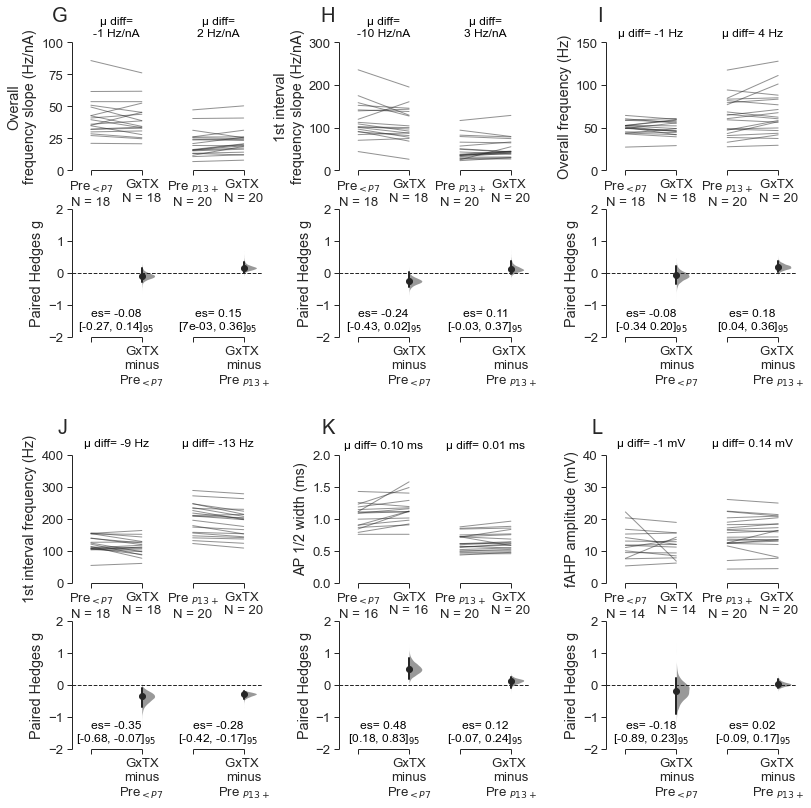

In [202]:
f, axx = plt.subplots(nrows=2, ncols=3, figsize=(13,13),gridspec_kw={'wspace': 0.4, 'hspace':0.4})

Mean_FI = dabest.load(Dev_seek_combine, idx=(('Pre$_{<P7}$', "GxTX"),('Pre $_{P13+}$', "GxTX ")),
                      x="rel_cond", y="slope_mean",paired=True, id_col="Cell_ID")
intial_FI = dabest.load(Dev_seek_combine, idx=(('Pre$_{<P7}$', "GxTX"),('Pre $_{P13+}$', "GxTX ")),
                      x="rel_cond", y="slope_max",paired=True, id_col="Cell_ID")
Mean_max = dabest.load(Dev_seek_combine, idx=(('Pre$_{<P7}$', "GxTX"),('Pre $_{P13+}$', "GxTX ")),
                      x="rel_cond", y="Mean_FF",paired=True, id_col="Cell_ID")
Initial_max = dabest.load(Dev_seek_combine, idx=(('Pre$_{<P7}$', "GxTX"),('Pre $_{P13+}$', "GxTX ")),
                      x="rel_cond", y="Max_FF",paired=True, id_col="Cell_ID")
AP_HW = dabest.load(Dev_seek_combine, idx=(('Pre$_{<P7}$', "GxTX"),('Pre $_{P13+}$', "GxTX ")),
                      x="rel_cond", y="AP_HW",paired=True, id_col="Cell_ID") 
fAHP = dabest.load(Dev_seek_combine, idx=(('Pre$_{<P7}$', "GxTX"),('Pre $_{P13+}$', "GxTX ")),
                      x="rel_cond", y="fAHP_AMP",paired=True, id_col="Cell_ID") 
   
    
Mean_FI.hedges_g.plot(ax=axx.flat[0],swarm_ylim=(0,100),swarm_label='Overall\nfrequency slope (Hz/nA)', 
                      es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
intial_FI.hedges_g.plot(ax=axx.flat[1],swarm_ylim=(0,300),swarm_label='1st interval\nfrequency slope (Hz/nA)',
                       es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
Mean_max.hedges_g.plot(ax=axx.flat[2],swarm_ylim=(0,150),swarm_label='Overall frequency (Hz)', 
                      es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
Initial_max.hedges_g.plot(ax=axx.flat[3],swarm_ylim=(0,400),swarm_label='1st interval frequency (Hz)', 
                         es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
AP_HW.hedges_g.plot(ax=axx.flat[4],swarm_ylim=(0,2),swarm_label='AP 1/2 width (ms)', 
                         es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
fAHP.hedges_g.plot(ax=axx.flat[5],swarm_ylim=(0,40),swarm_label='fAHP amplitude (mV)', 
                         es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired Hedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));

###Adding text with mean differences and ES values
#text for hedges g plot always 43.75% lower that diff
#MeanSlope
Stats_text_paired(0,0.5,2.5, 105, -125,'\u03BC diff=\n-1 Hz/nA','\u03BC diff=\n2 Hz/nA', "es= -0.08\n[-0.27, 0.14]$_{95}$", "es= 0.15\n[7e-03, 0.36]$_{95}$",12,'center','black')
#MaxSlope
Stats_text_paired(1,0.5,2.5, 315, -375,'\u03BC diff=\n-10 Hz/nA','\u03BC diff=\n3 Hz/nA', "es= -0.24\n[-0.43, 0.02]$_{95}$", "es= 0.11\n[-0.03, 0.37]$_{95}$",12,'center','black')
#mean frequency
Stats_text_paired(2,0.5,2.5, 157.5, -187.5,'\u03BC diff= -1 Hz','\u03BC diff= 4 Hz', "es= -0.08\n[-0.34 0.20]$_{95}$", "es= 0.18\n[0.04, 0.36]$_{95}$",12,'center','black')

#initial freq
Stats_text_paired(3,0.5,2.5, 425, -500,'\u03BC diff= -9 Hz','\u03BC diff= -13 Hz', "es= -0.35\n[-0.68, -0.07]$_{95}$", "es= -0.28\n[-0.42, -0.17]$_{95}$",12,'center','black')
#HW

Stats_text_paired(4,0.5,2.5, 2.1, -2.5,'\u03BC diff= 0.10 ms','\u03BC diff= 0.01 ms', "es= 0.48\n[0.18, 0.83]$_{95}$", "es= 0.12\n[-0.07, 0.24]$_{95}$",12,'center','black')
#fAHP

Stats_text_paired(5,0.5,2.5, 42.5, -50,'\u03BC diff= -1 mV','\u03BC diff= 0.14 mV', "es= -0.18\n[-0.89, 0.23]$_{95}$", "es= 0.02\n[-0.09, 0.17]$_{95}$",12,'center','black')

#adding labels
axx.flat[0].annotate('G', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[1].annotate('H', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[2].annotate('I', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[3].annotate('J', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[4].annotate('K', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[5].annotate('L', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')

#plt.savefig(r"C:\Users\csmith\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\GXTX_Dev_corrs_Ephys.svg", dpi=300,bbox_inches='tight')


### 📊 Figure 8. Supplement 1 Muscarine depolarises RMP in neonatal but not mature MNs

In [203]:
Musc_dev_dat = pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_paper_Allfiles_for_jupyterNB\Musc_dev.xlsx",sheet_name='Sheet1')

Creating new column for labeling of graphs

In [204]:
Musc_young=Musc_dev_dat.drop(Musc_dev_dat[(Musc_dev_dat['AgeGroup'] == 'P13+')].index)
Musc_mature=Musc_dev_dat.drop(Musc_dev_dat[(Musc_dev_dat['AgeGroup'] == 'P2-7')].index)

In [205]:
Musc_young

,file,AnimalID,Age,Sex,AgeGroup,CellID,Condition,RMP_mV,I_Hold_pA
0,CK_15_08_18_C2_rheo.cfs,CK,2,f,P2-7,CK_15_08_18_C2,nACSF,-67.0,0
1,CK_15_08_18_C2_rheo_musc.cfs,CK,2,f,P2-7,CK_15_08_18_C2,Musc,-51.6,-143
2,CL_18_08_C3_rheo_.cfs,CL,6,f,P2-7,CL_18_08_C3,nACSF,-63.0,0
3,CL_18_08_C3_rheo_musc.cfs,CL,6,f,P2-7,CL_18_08_C3,Musc,-53.0,-255
4,CL_18_08_C1_sag.cfs,CL,6,f,P2-7,CL_18_08_C1,nACSF,-66.0,0
5,CL_18_08_C1_sag_musc.cfs,CL,6,f,P2-7,CL_18_08_C1,Musc,-63.0,-163
6,BZ_26_07_18_C3_sag.cfs,BZ,6,m,P2-7,BZ_26_07_18_C3,nACSF,NaN,0
7,BZ_26_07_18_C3_single20musc,BZ,6,m,P2-7,BZ_26_07_18_C3,Musc,NaN,-279
8,BZ_26_07_18_C4_sag.cfs,BZ,6,m,P2-7,BZ_26_07_18_C4,nACSF,-65.0,0
9,BZ_26_07_18_C4_if.cfs,BZ,6,m,P2-7,BZ_26_07_18_C4,Musc,-56.0,-100


In [206]:
Musc_young['rel_cond']= np.where(Musc_young['Condition']=='nACSF', 'Pre$_{<P7}$', "Musc")
#creating new column to match with the KO DF

Musc_mature['rel_cond']= np.where(Musc_mature['Condition']=='nACSF', 'Pre $_{P13+}$', "Musc ")

# combining Dfs
Musc_combine=pd.concat([Musc_young, Musc_mature])

In [207]:
Cell_Count=Musc_dev_dat.groupby(['Sex', 'AnimalID', 'AgeGroup'],as_index=False).agg(['count'])
Cell_Count.Age

count
Sex AnimalID AgeGroup       
f   ADB      P2-7          4
    ADK      P13+          6
    ADM      P13+          2
    AX       P2-7          2
    CI       P2-7          4
    CJ       P2-7          2
    CK       P2-7          2
    CL       P2-7          4
m   ADF      P13+          6
    ADI      P13+          2
    ADL      P13+          2
    ADN      P13+          2
    BZ       P2-7          4

In [208]:
Musc_dev_descript= Musc_dev_dat.groupby(['Condition','AgeGroup']).agg(['mean','std'])
Musc_dev_descript

Age               RMP_mV             I_Hold_pA  \
                         mean       std       mean       std        mean   
Condition AgeGroup                                                         
Musc      P13+      14.444444  2.351123 -68.000000  2.598076    0.000000   
Musc      P13+      13.000000       NaN -67.000000       NaN    0.000000   
          P2-7       5.727273  1.272078 -55.622222  3.726184 -200.727273   
nACSF     P13+      14.300000  2.263233 -67.400000  2.633122    0.000000   
          P2-7       5.727273  1.272078 -65.111111  1.900292    0.000000   

                               
                          std  
Condition AgeGroup             
Musc      P13+       0.000000  
Musc      P13+            NaN  
          P2-7      94.643638  
nACSF     P13+       0.000000  
          P2-7       0.000000

In [209]:
Musc_combine

,file,AnimalID,Age,Sex,AgeGroup,CellID,Condition,RMP_mV,I_Hold_pA,rel_cond
0,CK_15_08_18_C2_rheo.cfs,CK,2,f,P2-7,CK_15_08_18_C2,nACSF,-67.0,0,Pre$_{<P7}$
1,CK_15_08_18_C2_rheo_musc.cfs,CK,2,f,P2-7,CK_15_08_18_C2,Musc,-51.6,-143,Musc
2,CL_18_08_C3_rheo_.cfs,CL,6,f,P2-7,CL_18_08_C3,nACSF,-63.0,0,Pre$_{<P7}$
3,CL_18_08_C3_rheo_musc.cfs,CL,6,f,P2-7,CL_18_08_C3,Musc,-53.0,-255,Musc
4,CL_18_08_C1_sag.cfs,CL,6,f,P2-7,CL_18_08_C1,nACSF,-66.0,0,Pre$_{<P7}$
5,CL_18_08_C1_sag_musc.cfs,CL,6,f,P2-7,CL_18_08_C1,Musc,-63.0,-163,Musc
6,BZ_26_07_18_C3_sag.cfs,BZ,6,m,P2-7,BZ_26_07_18_C3,nACSF,NaN,0,Pre$_{<P7}$
7,BZ_26_07_18_C3_single20musc,BZ,6,m,P2-7,BZ_26_07_18_C3,Musc,NaN,-279,Musc
8,BZ_26_07_18_C4_sag.cfs,BZ,6,m,P2-7,BZ_26_07_18_C4,nACSF,-65.0,0,Pre$_{<P7}$
9,BZ_26_07_18_C4_if.cfs,BZ,6,m,P2-7,BZ_26_07_18_C4,Musc,-56.0,-100,Musc


C:\Users\Calvi\anaconda3\lib\site-packages\dabest\_classes.py:774: UserWarning: The lower limit of the interval was in the bottom 10 values. The result should be considered unstable.
  warnings.warn(err_temp.substitute(lim_type="lower",
C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\Calvi\AppData\Local\Temp/ipykernel_3448/2337364662.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\Musc_RMP_Change.svg", dpi=300,bbox_

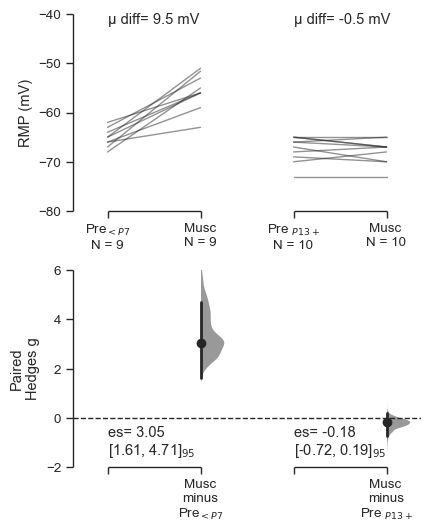

In [210]:
sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.1 ,rc={"lines.linewidth": 1.4})

RMP = dabest.load(Musc_combine, idx=(("Pre$_{<P7}$", "Musc"),('Pre $_{P13+}$', 'Musc ')),x="rel_cond", y="RMP_mV",paired=True, id_col="CellID")


RMP.hedges_g.plot(swarm_ylim=(-80,-40),swarm_label='RMP (mV)', es_marker_size=6, contrast_ylim=(-2,6),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));



#Mean diff
plt.text(0, 16, '\u03BC diff= 9.5 mV')
plt.text(2, 16, '\u03BC diff= -0.5 mV')

#ES
plt.text(0, -1.5, 'es= 3.05\n[1.61, 4.71]$_{95}$')
plt.text(2, -1.5, 'es= -0.18\n[-0.72, 0.19]$_{95}$')

#RM_allspines(2) #removing the 1st plot for example traces
#RM_allspines(3) #removing the 1st plot for example traces
#Stats_text_paired(4,0.5,2.5, 200, -250,'\u03BC diff= 18 Hz/nA','\u03BC diff= 13 Hz/nA', "es= 0.42\n[0.16, 0.75]$_{95}$", "es= 0.53\n[0.34, 1.32]$_{95}$",12,'center','black')




#'plt.savefig(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\Musc_RMP_Change.svg", dpi=300,bbox_inches='tight')

In [211]:
Musc_young_RMP_Hedges=STAT_hedges(Musc_young,"Pre$_{<P7}$", "Musc","rel_cond","RMP_mV",'RMP',True,"CellID","P2-7")
Musc_young_RMP_Hedges



,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,Pre$_{<P7}$,Musc,9,9,Hedges' g,True,3.055056,95,1.613906,4.710107,0.0,0.003906,0.0,0.000108,-7.039843,RMP,P2-7


In [212]:
Musc_young_RMP_Mean_Diff=STAT_mean(Musc_young,"Pre$_{<P7}$", "Musc","rel_cond","RMP_mV",'RMP',True,"CellID","P2-7")
Musc_young_RMP_Mean_Diff


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,Pre$_{<P7}$,Musc,9,9,mean difference,True,9.488889,95,7.0,11.911111,0.0,0.003906,0.0,0.000108,-7.039843,RMP,P2-7


In [213]:
Musc_mature_RMP_Hedges=STAT_hedges(Musc_mature,'Pre $_{P13+}$', "Musc ","rel_cond","RMP_mV",'RMP',True,"CellID","P13+")
Musc_mature_RMP_Hedges

C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,Pre $_{P13+}$,Musc,10,10,Hedges' g,True,-0.18757,95,-0.728962,0.19949,0.353,0.318542,11.0,0.343436,1.0,RMP,P13+


In [214]:
Musc_mature_RMP_Mean_Diff=STAT_mean(Musc_mature,'Pre $_{P13+}$', "Musc ","rel_cond","RMP_mV",'RMP',True,"CellID","P13")
Musc_mature_RMP_Mean_Diff

C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,Pre $_{P13+}$,Musc,10,10,mean difference,True,-0.5,95,-1.5,0.3,0.2494,0.318542,11.0,0.343436,1.0,RMP,P13


### 📊 Figure 8. Muscarine increases excitability in K$_V$2.1$^{OFF}$ motoneurons

Creating DF with only Mature, __control__ motoneurons treated with Muscarine


In [215]:
Musc_WT_Mature=ALL_with_Perc_change.drop(ALL_with_Perc_change[(ALL_with_Perc_change['genotype'] == "cKO")].index)
Musc_WT_Mature=Musc_WT_Mature.drop(Musc_WT_Mature[(Musc_WT_Mature['agegroup'] != "P13plus")].index)
Musc_WT_Mature=Musc_WT_Mature.drop(Musc_WT_Mature[(Musc_WT_Mature['Compound'] != "muscarine")].index)


Creating DF with only Mature, __K$_V$2.1$^{OFF}$__  motneurons treated with muscarine


In [216]:
Musc_KO_Mature=ALL_with_Perc_change.drop(ALL_with_Perc_change[(ALL_with_Perc_change['genotype'] == "Con")].index)
Musc_KO_Mature=Musc_KO_Mature.drop(Musc_KO_Mature[(Musc_KO_Mature['agegroup'] != "P13plus")].index)
Musc_KO_Mature=Musc_KO_Mature.drop(Musc_KO_Mature[(Musc_KO_Mature['Compound'] != "muscarine")].index)


Adding new columns to   and control DFs which contains appropriate labels for plotting


In [217]:
Musc_KO_Mature['rel_cond']= np.where(Musc_KO_Mature['condition']=='nACSF', 'nACSF$_{KO}$', 'Musc$_{KO}$')
Musc_WT_Mature['rel_cond']= np.where(Musc_WT_Mature['condition']=='nACSF', 'nACSF', 'Musc')

Creating combined DF with K$_V$2.1$^{OFF}$ and control data


In [218]:
to_concat1=[Musc_WT_Mature,Musc_KO_Mature]
ALL_Mature_MN_KO_Musc=pd.concat(to_concat1)

Males vs females numbers for control

In [219]:
AP_menasWT=Musc_WT_Mature.groupby(['gender', 'Animal'],as_index=False).agg(['count'])
AP_menasWT.block_thresh_nA

count
gender Animal       
F      ADK         4
       AEE         0
M      ADI         2
       ADL         2
       ADN         2
       ADU         2
       ADZ         0
       AEG         4

Males vs females numbers for KO

In [220]:
AP_menasKO=Musc_KO_Mature.groupby(['gender', 'Animal'],as_index=False).agg(['count'])
AP_menasKO.block_thresh_nA

count
gender Animal       
F      ADT         2
       AEC         2
M      ADR         4
       ADS         4
       ADW         4
       AEB         2

C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


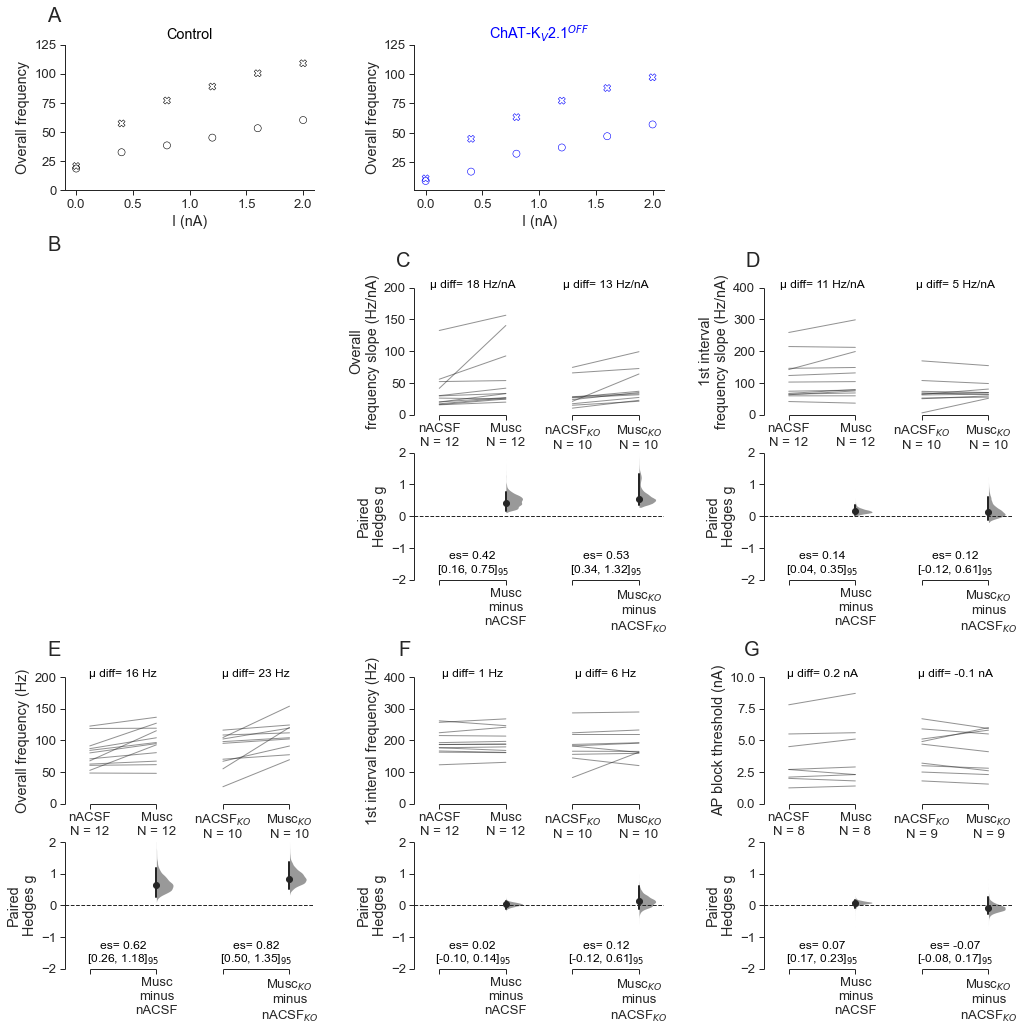

In [221]:
sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.5 ,rc={"lines.linewidth": 1.4})

f, axx = plt.subplots(nrows=3, ncols=3, figsize=(17,17),gridspec_kw={'wspace': 0.4, 'hspace':0.4, 'height_ratios': [0.5,1,1] })

MeanSlope = dabest.load(ALL_Mature_MN_KO_Musc, idx=(("nACSF", "Musc"),('nACSF$_{KO}$', 'Musc$_{KO}$')),x="rel_cond", y="slope_mean",paired=True, id_col="Cell_ID")
MaxSlope = dabest.load(ALL_Mature_MN_KO_Musc, idx=(("nACSF", "Musc"),('nACSF$_{KO}$', 'Musc$_{KO}$')),x="rel_cond", y="slope_max",paired=True, id_col="Cell_ID")
MeanFrq = dabest.load(ALL_Mature_MN_KO_Musc, idx=(("nACSF", "Musc"),('nACSF$_{KO}$', 'Musc$_{KO}$')),x="rel_cond", y="Mean_FF",paired=True, id_col="Cell_ID")
MaxAPs = dabest.load(ALL_Mature_MN_KO_Musc, idx=(("nACSF", "Musc"),('nACSF$_{KO}$', 'Musc$_{KO}$')),x="rel_cond", y="Max_Spikes",paired=True, id_col="Cell_ID")
InitialFrq = dabest.load(ALL_Mature_MN_KO_Musc, idx=(("nACSF", "Musc"),('nACSF$_{KO}$', 'Musc$_{KO}$')),x="rel_cond", y="Max_FF",paired=True, id_col="Cell_ID")
AP_Block = dabest.load(ALL_Mature_MN_KO_Musc, idx=(("nACSF", "Musc"),('nACSF$_{KO}$', 'Musc$_{KO}$')),x="rel_cond", y="block_thresh_nA",paired=True, id_col="Cell_ID")


Example_FI_plots = pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_paper_Allfiles_for_jupyterNB\Example_F_I_plots_paper.xlsx",
                         sheet_name='ADI_C2')

##overall frequency ADI_C2-control###
ax = axx.flat[0]
Scatter_params(0,Example_FI_plots,"Mean frequency (Hz)","I (nA)","condition","black","black","upper right",1.35, 0.7
               ,0,125,-0.1,2.1,"condition",50, "Overall frequency",'none','black')
ax.set_title('Control', x=0.5, y=1,color='black')
axx.flat[0].get_legend().remove()
#legend_elements = [Line2D([0], [0], marker='o', color='0.1', lw=0, label='nACSF'),
#                   Line2D([0], [0], marker='x', color='0.1',lw=0, label='GxTX')]            #defining custom legend params


##Max spikes AEB_C2_cKO###
Example_FI_plots = pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_paper_Allfiles_for_jupyterNB\Example_F_I_plots_paper.xlsx",
                         sheet_name='AEB_C2')
ax = axx.flat[1]
Scatter_params(1,Example_FI_plots,"Mean frequency (Hz)","I (nA)","condition","blue","blue","upper left",0, 1
               ,1,125,-0.1,2.1,"condition",50,"Overall frequency", 'none', 'blue')
axx.flat[1].get_legend().remove()
ax.set_title("ChAT-K$_V$2.1$^{OFF}$", x=0.5, y=1, color='blue')
plt.legend([],[], frameon=False)


MeanSlope.hedges_g.plot(ax=axx.flat[4],swarm_ylim=(0,200),swarm_label='Overall\nfrequency slope (Hz/nA)', es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
MaxSlope.hedges_g.plot(ax=axx.flat[5],swarm_ylim=(0,400),swarm_label='1st interval\nfrequency slope (Hz/nA)', es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
MeanFrq.hedges_g.plot(ax=axx.flat[6],swarm_ylim=(0,200),swarm_label='Overall frequency (Hz)', es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
#MaxAPs.hedges_g.plot(ax=axx.flat[3],swarm_ylim=(0,100),swarm_label='Maximum spikes', es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired\nHedges g',
#                        reflines_kwargs=dict(linestyle='--', linewidth=1));
InitialFrq.hedges_g.plot(ax=axx.flat[7],swarm_ylim=(0,400),swarm_label='1st interval frequency (Hz)', es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
AP_Block.hedges_g.plot(ax=axx.flat[8],swarm_ylim=(0,10),swarm_label='AP block threshold (nA)', es_marker_size=6, contrast_ylim=(-2,2),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));



#MeanSlope
Stats_text_paired(4,0.5,2.5, 200, -250,'\u03BC diff= 18 Hz/nA','\u03BC diff= 13 Hz/nA', "es= 0.42\n[0.16, 0.75]$_{95}$", "es= 0.53\n[0.34, 1.32]$_{95}$",12,'center','black')

#MaxSlope
Stats_text_paired(5,0.5,2.5, 400, -500,'\u03BC diff= 11 Hz/nA','\u03BC diff= 5 Hz/nA', "es= 0.14\n[0.04, 0.35]$_{95}$", "es= 0.12\n[-0.12, 0.61]$_{95}$",12,'center','black')

#mean frequency
Stats_text_paired(6,0.5,2.5, 200, -250,'\u03BC diff= 16 Hz','\u03BC diff= 23 Hz', "es= 0.62\n[0.26, 1.18]$_{95}$", "es= 0.82\n[0.50, 1.35]$_{95}$",12,'center','black')

#initial freq
Stats_text_paired(7,0.5,2.5, 400, -500,'\u03BC diff= 1 Hz','\u03BC diff= 6 Hz', "es= 0.02\n[-0.10, 0.14]$_{95}$", "es= 0.12\n[-0.12, 0.61]$_{95}$",12,'center','black')

#AP block
Stats_text_paired(8,0.5,2.5, 10, -12.5,'\u03BC diff= 0.2 nA','\u03BC diff= -0.1 nA', "es= 0.07\n[0.17, 0.23]$_{95}$", "es= -0.07\n[-0.08, 0.17]$_{95}$",12,'center','black')

#adding labels
axx.flat[0].annotate('A', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[3].annotate('B', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[4].annotate('C', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[5].annotate('D', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[6].annotate('E', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[7].annotate('F', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[8].annotate('G', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')





RM_allspines(2) #removing the 1st plot for example traces
RM_allspines(3) #removing the 1st plot for example traces






#plt.savefig(r"C:\Users\csmith\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\Musc_Firing_ES_plots.svg", dpi=300,bbox_inches='tight')

### Hedges g estimation statistics for effects of muscarine on control motoneurons

Control Overall frequency slope

In [222]:
WT_MN_Mat_slope_mean_Stats_Musc=STAT_hedges(Musc_WT_Mature,"nACSF", "musc","condition","slope_mean",'mean freq FI',True,"Cell_ID","Con MN Musc (mature)")


Control 1st interval frequency slope

In [223]:
WT_MN_Mat_slope_max_Stats_Musc=STAT_hedges(Musc_WT_Mature,"nACSF", "musc","condition","slope_max",'initial FI',True,"Cell_ID","Con MN Musc (mature)")


Control Overall frequency

In [224]:
WT_MN_Mat_Mean_FF_Stats_Musc=STAT_hedges(Musc_WT_Mature,"nACSF", "musc","condition","Mean_FF",'Peak mean freq',True,"Cell_ID","Con MN Musc (mature)")


Control 1st interval frequency

In [225]:
WT_MN_Mat_Max_FF_Stats_Musc=STAT_hedges(Musc_WT_Mature,"nACSF", "musc","condition","Max_FF",'Peak init freq',True,"Cell_ID","Con MN Musc (mature)")


Control AP block threshold

In [226]:
WT_MN_Mat_block_thresh_nA_Stats_Musc=STAT_hedges(Musc_WT_Mature,"nACSF", "musc","condition","block_thresh_nA",'block thresh nA',True,"Cell_ID","Con MN Musc (mature)")


In [227]:
#Combining all firing and AP charactaristics into single DF
to_concat=[WT_MN_Mat_slope_mean_Stats_Musc,WT_MN_Mat_slope_max_Stats_Musc,WT_MN_Mat_Mean_FF_Stats_Musc,WT_MN_Mat_Max_FF_Stats_Musc,WT_MN_Mat_block_thresh_nA_Stats_Musc]
ALL_WT_MN_Mat_MUSC_firing_Stats_hedges=pd.concat(to_concat)
ALL_WT_MN_Mat_MUSC_firing_Stats_hedges

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,musc,12,12,Hedges' g,True,0.429339,95,0.164928,0.758831,0.0006,0.000977,1.0,0.043071,-2.286112,mean freq FI,Con MN Musc (mature)
0,nACSF,musc,12,12,Hedges' g,True,0.147204,95,0.048686,0.352866,0.0182,0.020996,10.0,0.061910,-2.078013,initial FI,Con MN Musc (mature)
0,nACSF,musc,12,12,Hedges' g,True,0.623646,95,0.262889,1.181601,0.0012,0.001465,2.0,0.004873,-3.511181,Peak mean freq,Con MN Musc (mature)
0,nACSF,musc,12,12,Hedges' g,True,0.027486,95,-0.103270,0.140007,0.6612,0.677246,33.0,0.658190,-0.454668,Peak init freq,Con MN Musc (mature)
0,nACSF,musc,8,8,Hedges' g,True,0.077591,95,-0.085966,0.175154,0.2324,0.382812,11.0,0.224124,-1.333499,block thresh nA,Con MN Musc (mature)


### Mean difference estimation statistics for effects of muscarine on control motoneurons

Overall frequency slope

In [228]:
WT_MN_Mat_slope_mean_Stats_Musc_mean=STAT_mean(Musc_WT_Mature,"nACSF", "musc","condition","slope_mean",'mean freq FI',True,"Cell_ID","WT MN Musc (mature)")


1st interval frequency slope

In [229]:
WT_MN_Mat_slope_max_Stats_Musc_mean=STAT_mean(Musc_WT_Mature,"nACSF", "musc","condition","slope_max",'initial FI',True,"Cell_ID","WT MN Musc (mature)")


Overall frequency 

In [230]:
WT_MN_Mat_Mean_FF_Stats_Musc_mean=STAT_mean(Musc_WT_Mature,"nACSF", "musc","condition","Mean_FF",'Peak mean freq',True,"Cell_ID","WT MN Musc (mature)")


1st interval frequency 

In [231]:
WT_MN_Mat_Max_FF_Stats_Musc_mean=STAT_mean(Musc_WT_Mature,"nACSF", "musc","condition","Max_FF",'Peak init freq',True,"Cell_ID","WT MN Musc (mature)")


AP block threshold

In [232]:
WT_MN_Mat_block_thresh_nA_Stats_Musc_mean=STAT_mean(Musc_WT_Mature,"nACSF", "musc","condition","block_thresh_nA",'block thresh nA',True,"Cell_ID","WT MN Musc (mature)")


In [233]:
#Combining all firing and AP charactaristics into single DF
to_concat=[WT_MN_Mat_slope_mean_Stats_Musc_mean,WT_MN_Mat_slope_max_Stats_Musc_mean,WT_MN_Mat_Mean_FF_Stats_Musc_mean,WT_MN_Mat_Max_FF_Stats_Musc_mean,
           WT_MN_Mat_block_thresh_nA_Stats_Musc_mean]
ALL_WT_MN_Mat_MUSC_firing_Stats_mean=pd.concat(to_concat)
ALL_WT_MN_Mat_MUSC_firing_Stats_mean

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,musc,12,12,mean difference,True,18.167006,95,8.414919,44.640250,0.0006,0.000977,1.0,0.043071,-2.286112,mean freq FI,WT MN Musc (mature)
0,nACSF,musc,12,12,mean difference,True,11.116663,95,3.604769,25.654153,0.0182,0.020996,10.0,0.061910,-2.078013,initial FI,WT MN Musc (mature)
0,nACSF,musc,12,12,mean difference,True,16.437337,95,9.287091,26.988498,0.0012,0.001465,2.0,0.004873,-3.511181,Peak mean freq,WT MN Musc (mature)
0,nACSF,musc,12,12,mean difference,True,1.138603,95,-3.582024,5.928568,0.6612,0.677246,33.0,0.658190,-0.454668,Peak init freq,WT MN Musc (mature)
0,nACSF,musc,8,8,mean difference,True,0.193750,95,-0.056250,0.487500,0.2324,0.382812,11.0,0.224124,-1.333499,block thresh nA,WT MN Musc (mature)


### Hedges g for muscarine effect on K$_V$2.1$^{OFF}$ motoneurons firing

Overall frequency slope

In [234]:
KO_MN_Mat_slope_mean_Stats_Musc=STAT_hedges(Musc_KO_Mature,"nACSF", "musc","condition","slope_mean",'mean freq FI',True,"Cell_ID","KO MN Musc (mature)")


1st interval frequency slope

In [235]:
KO_MN_Mat_slope_max_Stats_Musc=STAT_hedges(Musc_KO_Mature,"nACSF", "musc","condition","slope_max",'initial FI',True,"Cell_ID","KO MN Musc (mature)")


Overall frequency

In [236]:
KO_MN_Mat_Mean_FF_Stats_Musc=STAT_hedges(Musc_KO_Mature,"nACSF", "musc","condition","Mean_FF",'Peak mean freq',True,"Cell_ID","KO MN Musc (mature)")


1st interval frequency

In [237]:
KO_MN_Mat_Max_FF_Stats_Musc=STAT_hedges(Musc_KO_Mature,"nACSF", "musc","condition","Max_FF",'Peak init freq',True,"Cell_ID","KO MN Musc (mature)")


C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


AP block threshol

In [238]:
KO_MN_Mat_block_thresh_nA_Stats_Musc=STAT_hedges(Musc_KO_Mature,"nACSF", "musc","condition","block_thresh_nA",'block thresh nA',True,"Cell_ID","KO MN Musc (mature)")

In [239]:
#Combining all KO charactaristics into single DF
to_concat=[KO_MN_Mat_Max_FF_Stats_Musc,KO_MN_Mat_slope_max_Stats_Musc,KO_MN_Mat_block_thresh_nA_Stats_Musc,
           KO_MN_Mat_Mean_FF_Stats_Musc,KO_MN_Mat_slope_mean_Stats_Musc]
ALL_KO_MN_Mat_MUSC_firing_Stats_hedges=pd.concat(to_concat)
ALL_KO_MN_Mat_MUSC_firing_Stats_hedges

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,musc,10,10,Hedges' g,True,0.120953,95,-0.125613,0.598953,0.6796,0.441268,16.0,0.488234,-0.722672,Peak init freq,KO MN Musc (mature)
0,nACSF,musc,10,10,Hedges' g,True,0.123867,95,-0.124688,0.612133,0.4632,0.695312,23.0,0.398858,-0.885636,initial FI,KO MN Musc (mature)
0,nACSF,musc,9,9,Hedges' g,True,-0.075107,95,-0.260698,0.259474,0.4940,0.496094,16.0,0.535089,0.648077,block thresh nA,KO MN Musc (mature)
0,nACSF,musc,10,10,Hedges' g,True,0.829868,95,0.500511,1.352684,0.0000,0.001953,0.0,0.008843,-3.326891,Peak mean freq,KO MN Musc (mature)
0,nACSF,musc,10,10,Hedges' g,True,0.539652,95,0.341334,1.321630,0.0000,0.001953,0.0,0.006381,-3.533324,mean freq FI,KO MN Musc (mature)


###  Mean Differences for Muscarine effect on K$_V$2.1$^{OFF}$ motoneuron Firing

Overall frequency slope

In [240]:
KO_MN_Mat_slope_mean_Stats_Musc_mean=STAT_mean(Musc_KO_Mature,"nACSF", "musc","condition","slope_mean",'mean freq FI',True,"Cell_ID","KO MN Musc (mature)")


1st interval frequency slope

In [241]:
KO_MN_Mat_slope_max_Stats_Musc_mean=STAT_mean(Musc_KO_Mature,"nACSF", "musc","condition","slope_max",'initial FI',True,"Cell_ID","KO MN Musc (mature)")


Overall frequency

In [242]:
KO_MN_Mat_Mean_FF_Stats_Musc_mean=STAT_mean(Musc_KO_Mature,"nACSF", "musc","condition","Mean_FF",'Peak mean freq',True,"Cell_ID","KO MN Musc (mature)")


1st interval frequency

In [243]:
KO_MN_Mat_Max_FF_Stats_Musc_mean=STAT_mean(Musc_KO_Mature,"nACSF", "musc","condition","Max_FF",'Peak init freq',True,"Cell_ID","KO MN Musc (mature)")


C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


AP block threshold

In [244]:
KO_MN_Mat_block_thresh_nA_Stats_Musc_mean=STAT_mean(Musc_KO_Mature,"nACSF", "musc","condition","block_thresh_nA",'block thresh nA',True,"Cell_ID","KO MN Musc (mature)")


In [245]:
#Combining all KO firing stats into single DF
to_concat=[KO_MN_Mat_slope_mean_Stats_Musc_mean,KO_MN_Mat_slope_max_Stats_Musc_mean,KO_MN_Mat_Mean_FF_Stats_Musc_mean,
           KO_MN_Mat_Max_FF_Stats_Musc_mean,KO_MN_Mat_block_thresh_nA_Stats_Musc_mean]
ALL_KO_MN_Mat_MUSC_Firing_Stats_Mean=pd.concat(to_concat)
ALL_KO_MN_Mat_MUSC_Firing_Stats_Mean

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,musc,10,10,mean difference,True,13.371946,95,8.534387,24.665288,0.0000,0.001953,0.0,0.006381,-3.533324,mean freq FI,KO MN Musc (mature)
0,nACSF,musc,10,10,mean difference,True,4.781668,95,-2.597016,18.952703,0.4632,0.695312,23.0,0.398858,-0.885636,initial FI,KO MN Musc (mature)
0,nACSF,musc,10,10,mean difference,True,23.009502,95,12.312674,38.671540,0.0000,0.001953,0.0,0.008843,-3.326891,Peak mean freq,KO MN Musc (mature)
0,nACSF,musc,10,10,mean difference,True,6.455223,95,-4.964654,32.854698,0.6796,0.441268,16.0,0.488234,-0.722672,Peak init freq,KO MN Musc (mature)
0,nACSF,musc,9,9,mean difference,True,-0.135556,95,-0.446667,0.342222,0.4940,0.496094,16.0,0.535089,0.648077,block thresh nA,KO MN Musc (mature)


### 📊 Figure 8- Supplement 1. Muscarine reduces mAHP amplitude and duration in control and K$_V$2.1$^{OFF}$ MNs

C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Calvi\anaconda3\lib\site-packages\dabest\_classes.py:779: UserWarning: The upper limit of the interval was in the top 10 values. The result should be considered unstable.
  warnings.warn(err_temp.substitute(lim_type="upper",


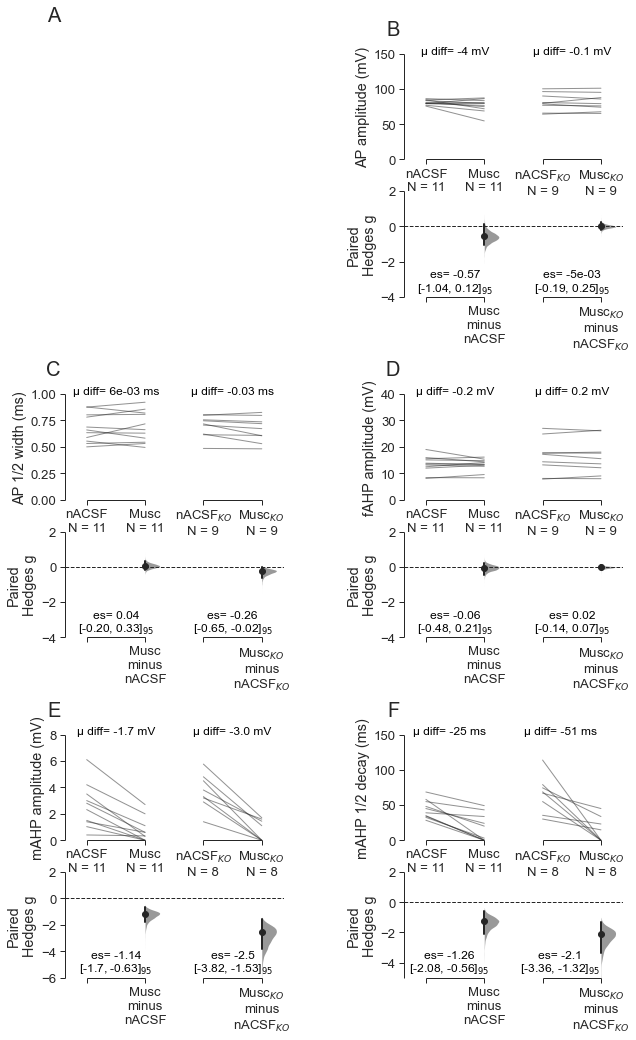

In [246]:
f, axx = plt.subplots(nrows=3, ncols=2, figsize=(10,17),gridspec_kw={'wspace': 0.55, 'hspace':0.4 })

AP_Amp = dabest.load(ALL_Mature_MN_KO_Musc, idx=(("nACSF", "Musc"),('nACSF$_{KO}$', "Musc$_{KO}$")),x="rel_cond", y="AP_AMP",paired=True, id_col="Cell_ID")
AP_HW = dabest.load(ALL_Mature_MN_KO_Musc, idx=(("nACSF", "Musc"),('nACSF$_{KO}$', "Musc$_{KO}$")),x="rel_cond", y="AP_HW",paired=True, id_col="Cell_ID")
fAHP = dabest.load(ALL_Mature_MN_KO_Musc, idx=(("nACSF", "Musc"),('nACSF$_{KO}$', "Musc$_{KO}$")),x="rel_cond", y="fAHP_AMP",paired=True, id_col="Cell_ID")
mAHP_amp = dabest.load(ALL_Mature_MN_KO_Musc, idx=(("nACSF", "Musc"),('nACSF$_{KO}$', "Musc$_{KO}$")),x="rel_cond", y="mAHP_AMP",paired=True, id_col="Cell_ID")
mAHP_Dur = dabest.load(ALL_Mature_MN_KO_Musc, idx=(("nACSF", "Musc"),('nACSF$_{KO}$', "Musc$_{KO}$")),x="rel_cond", y="mAHP_half_Duration",paired=True, id_col="Cell_ID")

AP_Amp.hedges_g.plot(ax=axx.flat[1],swarm_ylim=(0,150),swarm_label='AP amplitude (mV)', es_marker_size=6, contrast_ylim=(-4,2),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
AP_HW.hedges_g.plot(ax=axx.flat[2],swarm_ylim=(0,1),swarm_label='AP 1/2 width (ms)', es_marker_size=6, contrast_ylim=(-4,2),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
fAHP.hedges_g.plot(ax=axx.flat[3],swarm_ylim=(0,40),swarm_label='fAHP amplitude (mV)', es_marker_size=6, contrast_ylim=(-4,2),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
mAHP_amp.hedges_g.plot(ax=axx.flat[4],swarm_ylim=(0,8),swarm_label='mAHP amplitude (mV)', es_marker_size=6, contrast_ylim=(-6,2),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));
mAHP_Dur.hedges_g.plot(ax=axx.flat[5],swarm_ylim=(0,150),swarm_label='mAHP 1/2 decay (ms)', es_marker_size=6, contrast_ylim=(-5,2),contrast_label='Paired\nHedges g',
                        reflines_kwargs=dict(linestyle='--', linewidth=1));


#AP_AMP
Stats_text_paired(1,0.5,2.5, 150, -187.5,'\u03BC diff= -4 mV','\u03BC diff= -0.1 mV', "es= -0.57\n[-1.04, 0.12]$_{95}$", "es= -5e-03\n[-0.19, 0.25]$_{95}$",12,'center','black')

#HW

Stats_text_paired(2,0.5,2.5, 1, -1.25,'\u03BC diff= 6e-03 ms','\u03BC diff= -0.03 ms', "es= 0.04\n[-0.20, 0.33]$_{95}$", "es= -0.26\n[-0.65, -0.02]$_{95}$",12,'center','black')
#fAHP

Stats_text_paired(3,0.5,2.5, 40, -50,'\u03BC diff= -0.2 mV','\u03BC diff= 0.2 mV', "es= -0.06\n[-0.48, 0.21]$_{95}$", "es= 0.02\n[-0.14, 0.07]$_{95}$",12,'center','black')


#mAHP
Stats_text_paired(4,0.5,2.5, 8, -10,'\u03BC diff= -1.7 mV','\u03BC diff= -3.0 mV', "es= -1.14\n[-1.7, -0.63]$_{95}$", "es= -2.5\n[-3.82, -1.53]$_{95}$",12,'center','black')

#mAHP duration
Stats_text_paired(5,0.4,2.3, 150, -187.5,'\u03BC diff= -25 ms','\u03BC diff= -51 ms', "es= -1.26\n[-2.08, -0.56]$_{95}$", "es= -2.1\n[-3.36, -1.32]$_{95}$",12,'center','black')

axx.flat[0].annotate('A', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[1].annotate('B', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[2].annotate('C', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[3].annotate('D', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[4].annotate('E', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[5].annotate('F', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')


RM_allspines(0) #removing the 1st plot for example traces


#plt.savefig(r"C:\Users\csmith\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\MUSC_APs_Con_KO_Dabest.svg", dpi=300,bbox_inches='tight')
#multi_2group_paired.mean_diff.plot(swarm_ylim=(0,1),swarm_label='AP HW (ms)', es_marker_size=6);
#plt.tight_layout()
#find out how graphs are labelled in script

### Hedges g for Muscarine on control motoneuron AP charactaristics 

AP 1/2 width

In [247]:
WT_MN_Mat_AP_HW_Stats_Musc=STAT_hedges(Musc_WT_Mature,"nACSF", "musc","condition","AP_HW",'AP HW',True,"Cell_ID","WT MN Musc (mature)")


fAHP amplitude

In [248]:
WT_MN_Mat_fAHP_Stats_Musc=STAT_hedges(Musc_WT_Mature,"nACSF", "musc","condition","fAHP_AMP",'fAHP amp',True,"Cell_ID","WT MN Musc (mature)")


AP amplitude

In [249]:
WT_MN_Mat_AP_AMP_AMP_Stats_Musc=STAT_hedges(Musc_WT_Mature,"nACSF", "musc","condition","AP_AMP",'AP amp',True,"Cell_ID","WT MN Musc (mature)")


mAHP amplitude

In [250]:
WT_MN_Mat_mAHP_AMP_Stats_Musc=STAT_hedges(Musc_WT_Mature,"nACSF", "musc","condition","mAHP_AMP",'mAHP amp',True,"Cell_ID","WT MN Musc (mature)")


mAHP 1/2 width

In [251]:
WT_MN_Mat_mAHP_half_Duration_Stats_Musc=STAT_hedges(Musc_WT_Mature,"nACSF", "musc","condition",'mAHP_half_Duration','mAHP half duration',True,"Cell_ID","WT MN Musc (mature)")


In [252]:
#Combining all firing and AP charactaristics into single DF
to_concat=[WT_MN_Mat_AP_HW_Stats_Musc,WT_MN_Mat_fAHP_Stats_Musc,WT_MN_Mat_AP_AMP_AMP_Stats_Musc,WT_MN_Mat_mAHP_AMP_Stats_Musc,WT_MN_Mat_mAHP_half_Duration_Stats_Musc]
ALL_WT_MN_Mat_MUSC_AP_Stats_hedges=pd.concat(to_concat)
ALL_WT_MN_Mat_MUSC_AP_Stats_hedges


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,musc,11,11,Hedges' g,True,0.046156,95,-0.200699,0.337550,0.7326,0.898438,31.0,0.726125,-0.360288,AP HW,WT MN Musc (mature)
0,nACSF,musc,11,11,Hedges' g,True,-0.061118,95,-0.481592,0.216855,0.7348,0.831055,30.0,0.702680,0.392842,fAHP amp,WT MN Musc (mature)
0,nACSF,musc,11,11,Hedges' g,True,-0.576473,95,-1.088529,0.108615,0.1040,0.123047,15.0,0.104042,1.788135,AP amp,WT MN Musc (mature)
0,nACSF,musc,11,11,Hedges' g,True,-1.148486,95,-1.783940,-0.635371,0.0016,0.005034,0.0,0.000589,4.938008,mAHP amp,WT MN Musc (mature)
0,nACSF,musc,11,11,Hedges' g,True,-1.266089,95,-2.084020,-0.561918,0.0000,0.005062,0.0,0.000459,5.106946,mAHP half duration,WT MN Musc (mature)


### Mean Differences for Muscarine on control motoneuron AP charactaristics 

AP 1/2 width 

In [253]:
WT_MN_Mat_AP_HW_Stats_Musc_mean=STAT_mean(Musc_WT_Mature,"nACSF", "musc","condition","AP_HW",'AP HW',True,"Cell_ID","WT MN Musc (mature)")


fAHP amplitude

In [254]:
WT_MN_Mat_fAHP_Stats_Musc_mean=STAT_mean(Musc_WT_Mature,"nACSF", "musc","condition","fAHP_AMP",'fAHP amp',True,"Cell_ID","WT MN Musc (mature)")


AP amplitude

In [255]:
WT_MN_Mat_AP_AMP_AMP_Stats_Musc_mean=STAT_mean(Musc_WT_Mature,"nACSF", "musc","condition","AP_AMP",'AP amp',True,"Cell_ID","WT MN Musc (mature)")


mAHP amplitude

In [ ]:
WT_MN_Mat_mAHP_AMP_Stats_Musc_mean=STAT_mean(Musc_WT_Mature,"nACSF", "musc","condition","mAHP_AMP",'mAHP amp',True,"Cell_ID","WT MN Musc (mature)")


C:\Users\Calvi\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


mAHP 1/2 duration

In [ ]:
WT_MN_Mat_mAHP_half_Duration_Stats_Musc_mean=STAT_mean(Musc_WT_Mature,"nACSF", "musc","condition",'mAHP_half_Duration','mAHP half duration',True,"Cell_ID","WT MN Musc (mature)")

In [ ]:
#Combining all firing and AP charactaristics into single DF
to_concat=[WT_MN_Mat_AP_HW_Stats_Musc_mean,WT_MN_Mat_fAHP_Stats_Musc_mean,WT_MN_Mat_AP_AMP_AMP_Stats_Musc_mean,WT_MN_Mat_mAHP_AMP_Stats_Musc_mean,WT_MN_Mat_mAHP_half_Duration_Stats_Musc_mean]
ALL_WT_MN_Mat_MUSC_AP_Stats_MEAN_Diff=pd.concat(to_concat)
ALL_WT_MN_Mat_MUSC_AP_Stats_MEAN_Diff


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,musc,11,11,mean difference,True,0.006759,95,-0.025746,0.045406,0.7326,0.898438,31.0,0.726125,-0.360288,AP HW,WT MN Musc (mature)
0,nACSF,musc,11,11,mean difference,True,-0.178492,95,-1.214722,0.523033,0.7348,0.831055,30.0,0.702680,0.392842,fAHP amp,WT MN Musc (mature)
0,nACSF,musc,11,11,mean difference,True,-4.169760,95,-9.511260,-0.483597,0.1040,0.123047,15.0,0.104042,1.788135,AP amp,WT MN Musc (mature)
0,nACSF,musc,11,11,mean difference,True,-1.693636,95,-2.321818,-1.037273,0.0016,0.005034,0.0,0.000589,4.938008,mAHP amp,WT MN Musc (mature)
0,nACSF,musc,11,11,mean difference,True,-24.563636,95,-34.154545,-16.222727,0.0000,0.005062,0.0,0.000459,5.106946,mAHP half duration,WT MN Musc (mature)


### Hedges g for Muscarine effect on K$_V$2.1$^{OFF}$ motoneuron AP characteristics

AP 1/2 width

In [ ]:
KO_MN_Mat_AP_HW_Stats_Musc=STAT_hedges(Musc_KO_Mature,"nACSF", "musc","condition","AP_HW",'AP HW',True,"Cell_ID","KO MN Musc (mature)")


fAHP amplitude

In [ ]:
KO_MN_Mat_fAHP_Stats_Musc=STAT_hedges(Musc_KO_Mature,"nACSF", "musc","condition","fAHP_AMP",'fAHP amp',True,"Cell_ID","KO MN Musc (mature)")


AP amplitude

In [ ]:
KO_MN_Mat_AP_AMP_AMP_Stats_Musc=STAT_hedges(Musc_KO_Mature,"nACSF", "musc","condition","AP_AMP",'AP amp',True,"Cell_ID","KO MN Musc (mature)")


mAHP amplitude

In [262]:
KO_MN_Mat_mAHP_AMP_Stats_Musc=STAT_hedges(Musc_KO_Mature,"nACSF", "musc","condition","mAHP_AMP",'mAHP amp',True,"Cell_ID","KO MN Musc (mature)")


C:\Users\Calvi\anaconda3\lib\site-packages\dabest\_classes.py:779: UserWarning: The upper limit of the interval was in the top 10 values. The result should be considered unstable.
  warnings.warn(err_temp.substitute(lim_type="upper",


mAHP 1/2 duration

In [263]:
KO_MN_Mat_mAHP_half_Duration_Stats_Musc=STAT_hedges(Musc_KO_Mature,"nACSF", "musc","condition",'mAHP_half_Duration','mAHP half duration',True,"Cell_ID","KO MN Musc (mature)")


In [264]:
#Combining all AP charactaristics into single DF
to_concat=[KO_MN_Mat_AP_HW_Stats_Musc,KO_MN_Mat_fAHP_Stats_Musc,KO_MN_Mat_AP_AMP_AMP_Stats_Musc,
           KO_MN_Mat_mAHP_AMP_Stats_Musc,KO_MN_Mat_mAHP_half_Duration_Stats_Musc]
ALL_KO_MN_Mat_MUSC_AP_Stats_Hedges=pd.concat(to_concat)
ALL_KO_MN_Mat_MUSC_AP_Stats_Hedges


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,musc,9,9,Hedges' g,True,-0.261110,95,-0.650766,-0.021042,0.0574,0.054688,6.0,0.074127,2.053302,AP HW,KO MN Musc (mature)
0,nACSF,musc,9,9,Hedges' g,True,-0.027216,95,-0.146938,0.073075,0.6004,0.652344,18.0,0.605086,0.538198,fAHP amp,KO MN Musc (mature)
0,nACSF,musc,9,9,Hedges' g,True,-0.005168,95,-0.194538,0.258951,0.9664,0.652344,18.0,0.960879,0.050608,AP amp,KO MN Musc (mature)
0,nACSF,musc,8,8,Hedges' g,True,-2.560722,95,-3.827446,-1.538349,0.0000,0.007812,0.0,0.000140,7.473356,mAHP amp,KO MN Musc (mature)
0,nACSF,musc,8,8,Hedges' g,True,-2.135490,95,-3.365367,-1.326584,0.0096,0.007812,0.0,0.004809,4.060018,mAHP half duration,KO MN Musc (mature)


### Mean Differences for Muscarine effect on K$_V$2.1$^{OFF}$ motoneuron AP characteristics

AP 1/2 width

In [265]:
KO_MN_Mat_AP_HW_Stats_Musc_mean=STAT_mean(Musc_KO_Mature,"nACSF", "musc","condition","AP_HW",'AP HW',True,"Cell_ID","KO MN Musc (mature)")


fAHP amplitude

In [266]:
KO_MN_Mat_fAHP_Stats_Musc_mean=STAT_mean(Musc_KO_Mature,"nACSF", "musc","condition","fAHP_AMP",'fAHP amp',True,"Cell_ID","KO MN Musc (mature)")


AP amplitude

In [267]:
KO_MN_Mat_AP_AMP_AMP_Stats_Musc_mean=STAT_mean(Musc_KO_Mature,"nACSF", "musc","condition","AP_AMP",'AP amp',True,"Cell_ID","KO MN Musc (mature)")


mAHP amplitude

In [268]:
KO_MN_Mat_mAHP_AMP_Stats_Musc_mean=STAT_mean(Musc_KO_Mature,"nACSF", "musc","condition","mAHP_AMP",'mAHP amp',True,"Cell_ID","KO MN Musc (mature)")


mAHP 1/2 duration

In [269]:
KO_MN_Mat_mAHP_half_Duration_Stats_Musc_mean=STAT_mean(Musc_KO_Mature,"nACSF", "musc","condition",'mAHP_half_Duration','mAHP half duration',True,"Cell_ID","KO MN Musc (mature)")


In [270]:
#Combining all AP charactaristics into single DF
to_concat=[KO_MN_Mat_AP_HW_Stats_Musc_mean,KO_MN_Mat_fAHP_Stats_Musc_mean,KO_MN_Mat_AP_AMP_AMP_Stats_Musc_mean,KO_MN_Mat_mAHP_AMP_Stats_Musc_mean,KO_MN_Mat_mAHP_half_Duration_Stats_Musc_mean]
ALL_KO_MN_Mat_MUSC_AP_Stats_mean=pd.concat(to_concat)
ALL_KO_MN_Mat_MUSC_AP_Stats_mean

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t,parameter,group
0,nACSF,musc,9,9,mean difference,True,-0.030347,95,-0.063627,-0.008018,0.0574,0.054688,6.0,0.074127,2.053302,AP HW,KO MN Musc (mature)
0,nACSF,musc,9,9,mean difference,True,-0.188259,95,-0.776963,0.482926,0.6004,0.652344,18.0,0.605086,0.538198,fAHP amp,KO MN Musc (mature)
0,nACSF,musc,9,9,mean difference,True,-0.066374,95,-2.023979,2.843506,0.9664,0.652344,18.0,0.960879,0.050608,AP amp,KO MN Musc (mature)
0,nACSF,musc,8,8,mean difference,True,-2.977500,95,-3.722500,-2.252500,0.0000,0.007812,0.0,0.000140,7.473356,mAHP amp,KO MN Musc (mature)
0,nACSF,musc,8,8,mean difference,True,-50.812500,95,-77.562500,-30.293750,0.0096,0.007812,0.0,0.004809,4.060018,mAHP half duration,KO MN Musc (mature)


### 📊 Figure 9 Supplement 1. Comparing behaviour in control and K$_V$2.1$^{OFF}$ mice


In [271]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib.lines import Line2D

In [273]:
# Loading the data for female wheel experiments 
Run_dat = pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_paper_Allfiles_for_jupyterNB\ChATkcnb1_Running_wheels_winter_21_group1_females_Feb_21.xlsx",sheet_name='females')
Run_dat = Run_dat.dropna()  #dropping NA rows

In [274]:
Run_5=Run_dat.drop(Run_dat[Run_dat['sample']==1].index)
Run_1=Run_dat.drop(Run_dat[Run_dat['sample']==5].index)

In [275]:
# Loading the data for female wheel experiments 
Run_dat = pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_paper_Allfiles_for_jupyterNB\ChATkcnb1_Running_wheels_winter_21_group1_females_Feb_21.xlsx",sheet_name='females')
Run_dat = Run_dat.dropna()  #dropping NA rows

In [276]:
#by day
Mean_daily_distance_byDay=Run_dat.groupby(['animal', 'genotype','Day',],as_index=False).mean()
Max_daily_distance_byDay=Run_dat.groupby(['animal', 'genotype','Day',],as_index=False).max()

In [277]:
## Setting parameters for strip polots-mainly the mean line
sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.5 ,rc={"lines.linewidth": 1.6})
meanpointprops = dict(marker='-', markeredgecolor='r',
                      markerfacecolor='none',markeredgewidth=2,markersize=8)
medianprops = dict(linestyle='-.', linewidth=0, color='firebrick')
meanlineprops = dict(linestyle='-', linewidth=1.5, color='black')

In [278]:
Max_distance_1min=Run_1.groupby(['animal', 'genotype'],as_index=False).max()
Max_distance_5min=Run_5.groupby(['animal', 'genotype'],as_index=False).max()
Max_distance=Run_dat.groupby(['animal', 'genotype'],as_index=False).max()


In [279]:
#function for point plots
Leg=["x","y"]#defining legend labels
def point(pltnYpos,pltnXpos,pltnXsize,pltnYsize,yLAB,ylimL,ylimH,legpos1,legpos2,pal1,pal2,Dat,hue,x,y,dodge,Leg,Title,Ttsize,Ttpos,XLab,s,alpha):
    pltn = plt.axes([pltnYpos,pltnXpos, pltnXsize,pltnYsize])
    pltn = sns.pointplot(x=x, y=y,hue=hue,data=Dat,palette=[pal1,pal2],dodge=dodge,s=s,alpha=alpha)
    pltn.legend(Leg,bbox_to_anchor=(legpos1,legpos2), loc='upper left', ncol=1,frameon=False)
    plt.ylim(ylimL,ylimH)
    sns.despine(offset=0, trim=False)
    pltn.set(ylabel=(yLAB))
    pltn.set_title(Title,fontsize=Ttsize,y=Ttpos)
    pltn.set(xlabel=(XLab))
    
    


In [280]:
### Function for doing repeated measure ANOVAS
def RM_ANOVA_2way(VARs,Dat,param,gender):
    model = ols(VARs, Dat).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_table['parameter']=param
    anova_table['gender']=gender
    return anova_table

In [281]:
# creating function for stats on Con vs KO W/O drugs-using cohens D
def STAT_mean(Dat,lab1,lab2,xVal,yVal,param,P,ID,Group_param):
    df = dabest.load(Dat, idx=(lab1, lab2),x=xVal, y=yVal,paired=P,id_col=ID)
    df=df.mean_diff.statistical_tests
    df=df.assign(parameter=param)
    df=df.assign(group=Group_param)
    return df

## Male Wheel data

In [282]:
# Loading the data for male wheel experiments 
Run_datM = pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_paper_Allfiles_for_jupyterNB\ChATkcnb1_Running_wheels_winter_21_group1_females_Feb_21.xlsx",sheet_name='all_males')
Run_datM = Run_datM.dropna()  #dropping NA rows

In [283]:
# removing non-complient animals ones values low due to recording issues
Run_datM=Run_datM.drop(Run_datM[Run_datM['maxrev']<10].index)
Run_datM=Run_datM.drop(Run_datM[Run_datM['animal']==4].index)

In [284]:
Mean_daily_distance_byWeekM=Run_datM.groupby(['animal', 'genotype','Week',],as_index=False).mean()
Max_daily_distance_byWeekM=Run_datM.groupby(['animal', 'genotype','Week',],as_index=False).max()

In [285]:
#by day
Mean_daily_distance_bydayM=Run_datM.groupby(['animal', 'genotype','Day',],as_index=False).mean()
Max_daily_distance_bydayM=Run_datM.groupby(['animal', 'genotype','Day',],as_index=False).max()

In [286]:
Max_distance=Run_datM.groupby(['animal', 'genotype'],as_index=False).max()

## Treadmill data 

In [287]:
# Loading the data for grip strength
Treadmill_dat = pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_paper_Allfiles_for_jupyterNB\Final_treadmill_Data_KCNB1_KO_CCS_2021.xlsx",sheet_name='Sheet1')
#Treadmill_dat = Treadmill_dat .dropna()  #dropping NA rows

In [288]:
# Calculating means by animal and genotype
Mean_Treadmill=Treadmill_dat.groupby(['Animal','Genotype', 'gender'],as_index=False).mean()

In [289]:
Treadmill_males=Mean_Treadmill.drop(Mean_Treadmill[Mean_Treadmill['gender']=='F'].index)
Treadmill_fmales=Mean_Treadmill.drop(Mean_Treadmill[Mean_Treadmill['gender']=='M'].index)

## Grip strength results

### importing grip strength data

In [290]:
# Loading the data for grip strength
Grip_dat = pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_paper_Allfiles_for_jupyterNB\ChATcre_grip_strength.xlsx",sheet_name='Sheet3')
Grip_dat = Grip_dat.dropna()  #dropping NA rows

In [291]:
# Calculating means by animal and genotype
Mean_grip=Grip_dat.groupby(['ID', 'condition', 'gender'],as_index=False).mean()

In [292]:
#separating male and female data
Grip_males=Mean_grip.drop(Mean_grip[Mean_grip['gender']=='F'].index)
Grip_fmales=Mean_grip.drop(Mean_grip[Mean_grip['gender']=='M'].index)

In [293]:
Treadmill_males['rel_cond']= np.where(Treadmill_males['Genotype']=='Con', 'Con', "K$_V$2.1$^{OFF}$")
Treadmill_fmales['rel_cond']= np.where(Treadmill_fmales['Genotype']=='Con', 'Con', "K$_V$2.1$^{OFF}$")

In [294]:
Grip_males['rel_cond']= np.where(Grip_males['condition']=='Con', 'Con', "K$_V$2.1$^{OFF}$")
Grip_fmales['rel_cond']= np.where(Grip_fmales['condition']=='Con', 'Con', "K$_V$2.1$^{OFF}$")

In [295]:
Treadmill_males['max_distance']= Treadmill_males['max_distance'] / 1000
Treadmill_fmales['max_distance']= Treadmill_fmales['max_distance']/ 1000

Text(2, 12, 'K$_V$2.1$^{OFF}$')

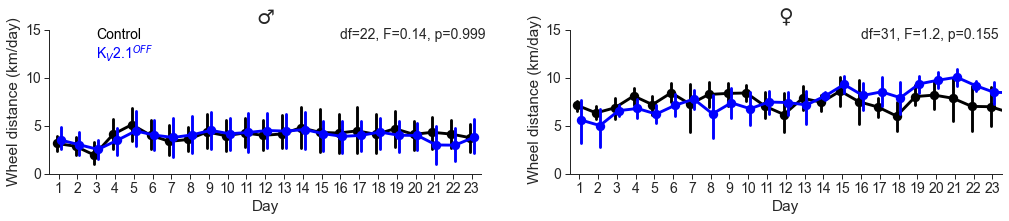

In [296]:
sns.set_context("paper", font_scale=1.6,rc={"lines.linewidth": 1.6})
my_color_palette = {"Con" : "black",
                      "K$_V$2.1$^{OFF}$" : "blue"}

#Female Max Distance (km/day)
point(1.205,-0.75, 1, 0.5,' Wheel distance (km/day)',0,15,0,0,"black", "blue",Max_daily_distance_byDay,
      "genotype","Day","totalDistance",0.2,'','$\u2640$',20,1.0,'Day',0.5, 0.5)
plt.text(15, 14, 'df=31, F=1.2, p=0.155',fontsize=14)  
plt.xlim([-0.5, 22.5]) 

#Male Max Distance (km/day)
point(0,-0.75, 1, 0.5,'Wheel distance (km/day)',0,15,0,0,"black", "blue",Max_daily_distance_bydayM,
      "genotype","Day","totalDistance",0.2,'','$\u2642$',20,1.0,'Day',0.5,0.5)
plt.text(15, 14, 'df=22, F=0.14, p=0.999',fontsize=14) 
plt.text(2, 14, 'Control',fontsize=14, c='black') 
plt.text(2, 12, 'K$_V$2.1$^{OFF}$',fontsize=14, c='blue') 

#plt.savefig(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\Behaviour_line_plot.svg", dpi=400,bbox_inches='tight')

Text(-4, 4, 'H')

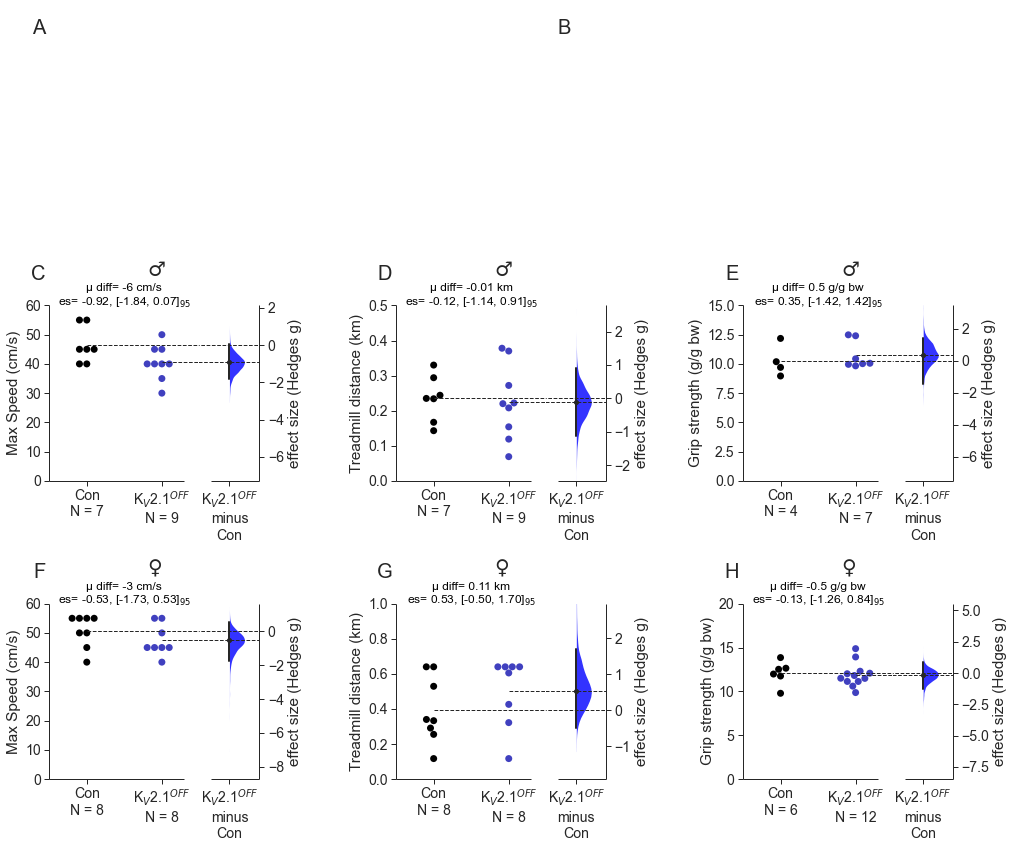

In [297]:
sns.set_context("paper", font_scale=1.6,rc={"lines.linewidth": 1.6})
my_color_palette = {"Con" : "black",
                      "K$_V$2.1$^{OFF}$" : "blue"}

f, axx = plt.subplots(nrows=3, ncols=3, figsize=(16.2,14.2),gridspec_kw={'wspace': 0.65, 'hspace':0.7})


RM_allspines(0) #removing the last plot for example traces
RM_allspines(1) #removing the last plot for example traces
RM_allspines(2) #removing the last plot for example traces


MaxSpeedM = dabest.load(Treadmill_males, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="max_speedcm_s",id_col="Animal")
MaxDistanceM = dabest.load(Treadmill_males, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="max_distance",id_col="Animal")
GripM = dabest.load(Grip_males, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="max_gram",id_col="ID")

MaxSpeedF  = dabest.load(Treadmill_fmales, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="max_speedcm_s",id_col="Animal")
MaxDistanceF = dabest.load(Treadmill_fmales, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="max_distance",id_col="Animal")
GripF = dabest.load(Grip_fmales, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="max_gram",id_col="ID")

##### males ####
MaxSpeedM .hedges_g.plot(ax=axx.flat[3],swarm_label='Max Speed (cm/s)', es_marker_size=4,
                  raw_marker_size=7,custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                  swarm_ylim=(0,60), contrast_ylim = (-1, 1),reflines_kwargs=dict(linestyle='--', linewidth=1),
                  swarmplot_kwargs=dict(clip_on=False));
axx.flat[3].text(0.8, 70, '$\u2642$',fontsize=20)

MaxDistanceM.hedges_g.plot(ax=axx.flat[4],swarm_label='Treadmill distance (km)', es_marker_size=4,
                 raw_marker_size=7, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                  swarm_ylim=(0,0.5),contrast_ylim=(-1,1),reflines_kwargs=dict(linestyle='--', linewidth=1),
                  swarmplot_kwargs=dict(clip_on=False));
axx.flat[4].text(0.8, 0.583, '$\u2642$',fontsize=20)

GripM.hedges_g.plot(ax=axx.flat[5],swarm_label='Grip strength (g/g bw)', es_marker_size=4,
                 raw_marker_size=7, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                  swarm_ylim=(0,15),contrast_ylim=(-1,1),reflines_kwargs=dict(linestyle='--', linewidth=1),
                  swarmplot_kwargs=dict(clip_on=False));
axx.flat[5].text(0.8, 17.49, '$\u2642$',fontsize=20)
#### females ####

MaxSpeedF.hedges_g.plot(ax=axx.flat[6],swarm_label='Max Speed (cm/s)', es_marker_size=4,
                  raw_marker_size=7,custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                  swarm_ylim=(0,60), contrast_ylim = (-1, 1),reflines_kwargs=dict(linestyle='--', linewidth=1),
                  swarmplot_kwargs=dict(clip_on=False));
axx.flat[6].text(0.8, 70, '$\u2640$',fontsize=20)

MaxDistanceF.hedges_g.plot(ax=axx.flat[7],swarm_label='Treadmill distance (km)', es_marker_size=4,
                 raw_marker_size=7, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                  swarm_ylim=(0,1),contrast_ylim=(-1,1),reflines_kwargs=dict(linestyle='--', linewidth=1),
                  swarmplot_kwargs=dict(clip_on=False));
axx.flat[7].text(0.8, 1.166, '$\u2640$',fontsize=20)

GripF.hedges_g.plot(ax=axx.flat[8],swarm_label='Grip strength (g/g bw)', es_marker_size=4,
                 raw_marker_size=7, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                  swarm_ylim=(0,20),contrast_ylim=(-1,1),reflines_kwargs=dict(linestyle='--', linewidth=1),
                  swarmplot_kwargs=dict(clip_on=True));
axx.flat[8].text(0.8, 23.32, '$\u2640$',fontsize=20)


Stats_text(3,0.5, 60, '\u03BC diff= -6 cm/s\nes= -0.92, [-1.84, 0.07]$_{95}$',12,'center','black')
Stats_text(4,0.5, 0.5,'\u03BC diff= -0.01 km\nes= -0.12, [-1.14, 0.91]$_{95}$',12,'center','black')
Stats_text(5,0.5, 15, '\u03BC diff= 0.5 g/g bw\nes= 0.35, [-1.42, 1.42]$_{95}$',12,'center','black')

Stats_text(6,0.5, 60,'\u03BC diff= -3 cm/s\nes= -0.53, [-1.73, 0.53]$_{95}$',12,'center','black')
Stats_text(7,0.5, 1, '\u03BC diff= 0.11 km\nes= 0.53, [-0.50, 1.70]$_{95}$',12,'center','black')
Stats_text(8,0.5, 20,'\u03BC diff= -0.5 g/g bw\nes= -0.13, [-1.26, 0.84]$_{95}$',12,'center','black')


axx.flat[0].annotate('A', xy=(0,0.8), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[1].annotate('', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[2].annotate('B', xy=(-0.8,0.8), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[3].annotate('C', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[4].annotate('D', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[5].annotate('E', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[6].annotate('F', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[7].annotate('G', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')
axx.flat[8].annotate('H', xy=(0,1.1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=20, va='bottom', ha='right')


#plt.savefig(r"C:\Users\csmith\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\Behaviour_ES_plot.svg", dpi=400,bbox_inches='tight')

### Stats for behavioural analysis

ANOVAs for male wheel running


In [298]:
Max_Distance_anova_Male=RM_ANOVA_2way('totalDistance ~ C(genotype) + C(Day) + C(genotype):C(Day)',Max_daily_distance_bydayM,"Max distance","Males")


ANOVAs for female wheel running

In [299]:
Max_Distance_anova_FMale=RM_ANOVA_2way('totalDistance ~ C(genotype) + C(Day) + C(genotype):C(Day)',Max_daily_distance_byDay,"Max distance","Fmales")


Combining all wheel running ANOVA data into single  DF


In [300]:
to_concat=[Max_Distance_anova_Male,Max_Distance_anova_FMale]
ALL_Wheel_ANOVA=pd.concat(to_concat)

In [301]:
ALL_Wheel_ANOVA

,sum_sq,df,F,PR(>F),parameter,gender
C(genotype),0.567727,1.0,0.110231,0.740220,Max distance,Males
C(Day),77.620998,22.0,0.685050,0.851669,Max distance,Males
C(genotype):C(Day),16.127697,22.0,0.142336,0.999999,Max distance,Males
Residual,1055.814998,205.0,NaN,NaN,Max distance,Males
C(genotype),24.542180,1.0,5.663246,0.017913,Max distance,Fmales
C(Day),202.907771,31.0,1.510391,0.043744,Max distance,Fmales
C(genotype):C(Day),171.263394,31.0,1.274838,0.155291,Max distance,Fmales
Residual,1378.081280,318.0,NaN,NaN,Max distance,Fmales


### Hedges G stats for Behaviour

Treadmill speed

In [302]:
M_Tread_max_speed_Stat=STAT_hedges(Treadmill_males,"Con","cKO","Genotype","max_speedcm_s","Max Speed (cm/s)",False,"Animal","Treadmill max speed (M)")
FM_Tread_max_speed_Stat=STAT_hedges(Treadmill_fmales,"Con","cKO","Genotype","max_speedcm_s","Max Speed (cm/s)",False,"Animal","Treadmill max speed (F)")

Treadmill endurance-distance

In [303]:
M_Tread_max_distance_Stat=STAT_hedges(Treadmill_males,"Con","cKO","Genotype","max_distance","Max Distance (m)",False,"Animal","Treadmill max distance (M)")
FM_Tread_max_distance_Stat=STAT_hedges(Treadmill_fmales,"Con","cKO","Genotype","max_distance","Max Distance (m)",False,"Animal","Treadmill max distance (F)")

Grip strength

In [304]:
M_grip_Stat=STAT_hedges(Grip_males,"Con","cKO","condition","max_gram","Grip strength (g/g bw)",False,"Animal","Grip strength (M)")
FM_grip_Stat=STAT_hedges(Grip_fmales,"Con","cKO","condition","max_gram","Grip strength (g/g bw)",False,"Animal","Grip strength (F)")


In [305]:
#Combining all into single DF
to_concat=[M_Tread_max_speed_Stat,FM_Tread_max_speed_Stat,M_Tread_max_distance_Stat,FM_Tread_max_distance_Stat,M_grip_Stat,FM_grip_Stat]
ALL_Behave=pd.concat(to_concat)

In [306]:
ALL_Behave

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,parameter,group
0,Con,cKO,7,9,Hedges' g,False,-0.921689,95,-1.845397,0.073941,0.0606,0.078406,1.916269,0.073485,1.934776,0.097422,47.0,Max Speed (cm/s),Treadmill max speed (M)
0,Con,cKO,8,8,Hedges' g,False,-0.538129,95,-1.733028,0.538129,0.1726,0.274050,1.138550,0.273999,1.138550,0.271396,42.5,Max Speed (cm/s),Treadmill max speed (F)
0,Con,cKO,7,9,Hedges' g,False,-0.123294,95,-1.143251,0.919474,0.7956,0.787928,0.274399,0.799546,0.258813,0.606469,37.0,Max Distance (m),Treadmill max distance (M)
0,Con,cKO,8,8,Hedges' g,False,0.539646,95,-0.503557,1.706423,0.2816,0.272736,-1.141760,0.272707,-1.141760,0.280514,21.5,Max Distance (m),Treadmill max distance (F)
0,Con,cKO,4,7,Hedges' g,False,0.354089,95,-1.420979,1.426028,0.5240,0.578385,-0.589980,0.551784,-0.618170,0.412121,9.0,Grip strength (g/g bw),Grip strength (M)
0,Con,cKO,6,12,Hedges' g,False,-0.136950,95,-1.262172,0.849209,0.7754,0.778275,0.289099,0.777320,0.287632,0.553221,43.0,Grip strength (g/g bw),Grip strength (F)


### Mean difference stats for behaviour

Treadmill Speed

In [307]:
M_Tread_max_speed_Stat_MEAN_DIFF=STAT_mean(Treadmill_males,"Con","cKO","Genotype","max_speedcm_s","Max Speed (cm/s)",False,"Animal","Treadmill max speed (M)")
FM_Tread_max_speed_Stat_MEAN_DIFF=STAT_mean(Treadmill_fmales,"Con","cKO","Genotype","max_speedcm_s","Max Speed (cm/s)",False,"Animal","Treadmill max speed (F)")

Treadmill endurance-distance

In [308]:
M_Tread_max_distance_Stat_MEAN_DIFF=STAT_mean(Treadmill_males,"Con","cKO","Genotype","max_distance","Max Distance (m)",False,"Animal","Treadmill max distance (M)")
FM_Tread_max_distance_Stat_MEAN_DIFF=STAT_mean(Treadmill_fmales,"Con","cKO","Genotype","max_distance","Max Distance (m)",False,"Animal","Treadmill max distance (F)")

Grip strength

In [309]:
M_grip_Stat_MEAN_DIFF=STAT_mean(Grip_males,"Con","cKO","condition","max_gram","Grip strength (g/g bw)",False,"Animal","Grip strength (M)")
FM_grip_Stat_MEAN_DIFF=STAT_mean(Grip_fmales,"Con","cKO","condition","max_gram","Grip strength (g/g bw)",False,"Animal","Grip strength (F)")


In [310]:
#Combining all passve into single DF
to_concat=[M_Tread_max_speed_Stat_MEAN_DIFF,FM_Tread_max_speed_Stat_MEAN_DIFF,M_Tread_max_distance_Stat_MEAN_DIFF,FM_Tread_max_distance_Stat_MEAN_DIFF,M_grip_Stat_MEAN_DIFF,FM_grip_Stat_MEAN_DIFF]
ALL_Behave_Mean_DIFF=pd.concat(to_concat)

In [311]:
ALL_Behave_Mean_DIFF

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,parameter,group
0,Con,cKO,7,9,mean difference,False,-5.873016,95,-12.063492,-1.031746,0.0602,0.078406,1.916269,0.073485,1.934776,0.097422,47.0,Max Speed (cm/s),Treadmill max speed (M)
0,Con,cKO,8,8,mean difference,False,-3.125000,95,-8.125000,1.875000,0.1726,0.274050,1.138550,0.273999,1.138550,0.271396,42.5,Max Speed (cm/s),Treadmill max speed (F)
0,Con,cKO,7,9,mean difference,False,-0.011730,95,-0.087222,0.072778,0.7956,0.787928,0.274399,0.799546,0.258813,0.606469,37.0,Max Distance (m),Treadmill max distance (M)
0,Con,cKO,8,8,mean difference,False,0.110625,95,-0.080000,0.265000,0.2816,0.272736,-1.141760,0.272707,-1.141760,0.280514,21.5,Max Distance (m),Treadmill max distance (F)
0,Con,cKO,4,7,mean difference,False,0.483159,95,-1.101521,1.743939,0.5240,0.578385,-0.589980,0.551784,-0.618170,0.412121,9.0,Grip strength (g/g bw),Grip strength (M)
0,Con,cKO,6,12,mean difference,False,-0.195397,95,-1.273114,1.183389,0.7754,0.778275,0.289099,0.777320,0.287632,0.553221,43.0,Grip strength (g/g bw),Grip strength (F)


### 📊 Figure 9. Motoneuron amplification is preserved in ChAT-KV2.1 off mice. 

### loading EMG data

In [312]:
# Loading the data for grip strength
EMG_dat = pd.read_excel(r"C:\Users\Calvi\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_paper_Allfiles_for_jupyterNB\EMG_Analysis_Final_July_21.xlsx",sheet_name='Sheet1')
#EMG_dat = EMG_dat.dropna()  #dropping NA rows

In [313]:
# Calculating means by animal and genotype
Mean_EMG_dat=EMG_dat.groupby(['muscle1','Animal','group'],as_index=False).agg('mean')

In [314]:
EMG_TA=Mean_EMG_dat.drop(Mean_EMG_dat[Mean_EMG_dat['muscle1']=='MG'].index)
EMG_MG=Mean_EMG_dat.drop(Mean_EMG_dat[Mean_EMG_dat['muscle1']=='TA'].index)

In [315]:
EMG_TA['rel_cond']= np.where(EMG_TA['group']=='Con', 'Con', "K$_V$2.1$^{OFF}$")
EMG_MG['rel_cond']= np.where(EMG_TA['group']=='Con', 'Con', "K$_V$2.1$^{OFF}$")

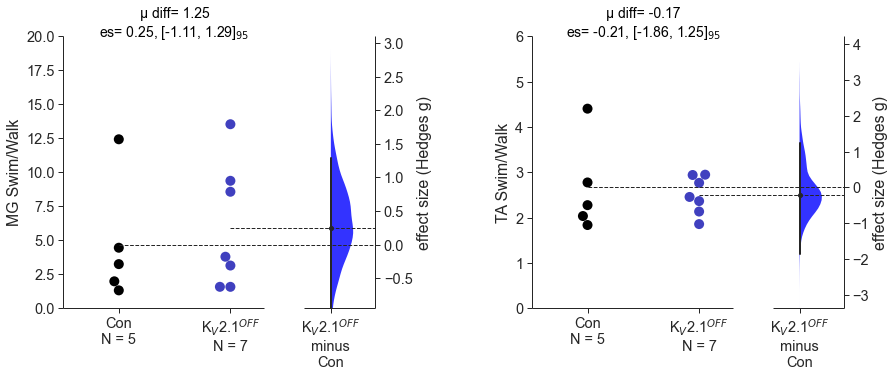

In [316]:
sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.65 ,rc={"lines.linewidth": 1.4})
my_color_palette = {"Con" : "black",
                      "K$_V$2.1$^{OFF}$" : "blue"}
    
f, axx = plt.subplots(nrows=1, ncols=2, figsize=(14,5),gridspec_kw={'wspace': 0.5, 'hspace':0.45
                                                                  })

Res = dabest.load(EMG_MG, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="amp",id_col="Animal")
Cap = dabest.load(EMG_TA, idx=("Con","K$_V$2.1$^{OFF}$"),x="rel_cond", y="amp",id_col="Animal")



Res.hedges_g.plot(ax=axx.flat[0],swarm_label='MG Swim/Walk', es_marker_size=4,
                  raw_marker_size=10,custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                  swarm_ylim=(0,20), contrast_ylim = (-1, 1),reflines_kwargs=dict(linestyle='--', linewidth=1),
                  swarmplot_kwargs=dict(clip_on=False));

Cap.hedges_g.plot(ax=axx.flat[1],swarm_label='TA Swim/Walk', es_marker_size=4,
                 raw_marker_size=10, custom_palette=my_color_palette, contrast_label='effect size (Hedges g)',
                  swarm_ylim=(0,6),contrast_ylim=(-1,1),reflines_kwargs=dict(linestyle='--', linewidth=1),
                  swarmplot_kwargs=dict(clip_on=False));


Stats_text(0,0.5, 20, '\u03BC diff= 1.25\nes= 0.25, [-1.11, 1.29]$_{95}$',14,'center','black')
Stats_text(1,0.5, 6,'\u03BC diff= -0.17\nes= -0.21, [-1.86, 1.25]$_{95}$',14,'center','black')


#plt.savefig(r"C:\Users\csmith\OneDrive\UCL_one_drive_clone\KV2.1_project_data\KV2_2021_Figs\EMG_ES_plot.svg", dpi=300,bbox_inches='tight')

### Hedges G for EMG amplification

In [317]:
MG_EMG_AMpP_StATS=STAT_hedges(EMG_MG,"Con","KO","group","amp","swim/walk ratio",False,"Animal","swim/walk ratio")
TA_EMG_AMpP_StATS=STAT_hedges(EMG_TA,"Con","KO","group","amp","swim/walk ratio",False,"Animal","swim/walk ratio")


In [318]:
TA_EMG_AMpP_StATS          

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,parameter,group
0,Con,KO,5,7,Hedges' g,False,-0.215534,95,-1.865449,1.250881,0.7568,0.741789,0.348588,0.698344,0.398912,0.755051,15.0,swim/walk ratio,swim/walk ratio


### Mean Differences for EMG amplification

In [319]:
MG_EMG_AMpP_StATS_MEAN=STAT_mean(EMG_MG,"Con","KO","group","amp","swim/walk ratio",False,"Animal","swim/walk ratio")
TA_EMG_AMpP_StATS_MEAN=STAT_mean(EMG_TA,"Con","KO","group","amp","swim/walk ratio",False,"Animal","swim/walk ratio")


In [320]:
MG_EMG_AMpP_StATS_MEAN

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,parameter,group
0,Con,KO,5,7,mean difference,False,1.253496,95,-4.107302,5.351301,0.6564,0.648578,-0.471566,0.648754,-0.469541,0.755051,15.0,swim/walk ratio,swim/walk ratio


In [321]:
TA_EMG_AMpP_StATS_MEAN

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,parameter,group
0,Con,KO,5,7,mean difference,False,-0.170196,95,-1.374316,0.46388,0.7568,0.741789,0.348588,0.698344,0.398912,0.755051,15.0,swim/walk ratio,swim/walk ratio
